In [4]:
import sys
sys.path.append('../')
sys.path.append('./')

In [16]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import sklearn.metrics

from sklearn.model_selection import train_test_split
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import classification_report

from catboost import Pool, CatBoostClassifier

from tqdm import tqdm

from collections import defaultdict
from collections import OrderedDict

import json
import time
import timeit

from utils.plot import plot_acc_and_time
from utils.config import DATASET_PATH

%matplotlib inline
sns.set(style='darkgrid', font_scale=1.5)

In [2]:
def getBestModelCB(X_train, X_test, y_train, y_test, params_grid,
                   cat_feature=None, plot=False, verbose=False, logging_level='Silent', **kwargs):
    
    train_pool = Pool(X_train, label=y_train, cat_features=cat_feature, 
                      feature_names=list(X_train.columns))
    test_pool = Pool(X_test, label=y_test, cat_features=cat_feature, 
                     feature_names=list(X_test.columns))
    
    model = CatBoostClassifier(logging_level='Silent', **kwargs)
    
    results = model.grid_search(
        param_grid=params_grid,
        X=train_pool,
        plot=plot,
        verbose=verbose
    )
    
    best_params = results['params']
    
    model = CatBoostClassifier(use_best_model=True, random_seed=0, 
                           **best_params, **kwargs)

    model.fit(train_pool, eval_set=test_pool, metric_period=100)
    
    return model

**План:**
1. Получение топ метрик из определения горбатости в ходьбе, так как это самая сложная задача.
2. Вывод графиков точности и времени исполнения по мере добавления метрик. Графики строятся для всех предсказания (позиции, горбатости в сидячем, стоячем и ходячем положениях).
3. Исследование влияния размера окна.

### Без известной позиции

In [19]:
data = pd.read_csv('../'+DATASET_PATH, index_col=[0, 1])
data = data.reset_index(drop=True)
data = data.drop(['position', 'age'], axis=1)
data.head()

,x_mean,x_std,x_max,x_min,x_energy,x_iqr,y_mean,y_std,y_max,y_min,y_energy,y_iqr,z_mean,z_std,z_max,z_min,z_energy,z_iqr,sma,xy_corr,xz_corr,yz_corr,x_mean_pos1,x_std_pos1,x_max_pos1,x_min_pos1,y_mean_pos1,y_std_pos1,y_max_pos1,y_min_pos1,z_mean_pos1,z_std_pos1,z_max_pos1,z_min_pos1,sma_pos1,x_energy_pos1,y_energy_pos1,z_energy_pos1,x_iqr_pos1,y_iqr_pos1,z_iqr_pos1,xy_corr_pos1,xz_corr_pos1,yz_corr_pos1,height,mass,is_valid,sex
0,11156.76,123.532772,11380.0,10836.0,1.244884e+08,177.0,1158.80,73.172275,1348.0,920.0,1348118.08,90.0,-12156.36,133.564763,-11808.0,-12528.0,1.477947e+08,177.0,16541.684983,0.149271,0.770160,0.165917,15146.131868,160.385778,16424.0,12984.0,-1865.611722,122.331084,-1588.0,-3500.0,-6243.567766,290.745677,-5008.0,-7132.0,16491.939761,2.294310e+08,3.495458e+06,3.906659e+07,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1
1,11156.88,128.858961,11380.0,10836.0,1.244924e+08,193.0,1137.96,69.416023,1300.0,920.0,1299723.36,100.0,-12157.04,135.868766,-11808.0,-12476.0,1.478119e+08,181.0,16540.861298,0.342194,0.781109,0.295006,15146.131868,160.385778,16424.0,12984.0,-1865.611722,122.331084,-1588.0,-3500.0,-6243.567766,290.745677,-5008.0,-7132.0,16491.939761,2.294310e+08,3.495458e+06,3.906659e+07,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1
2,11154.36,134.410311,11532.0,10836.0,1.244376e+08,190.0,1088.32,171.829072,1380.0,164.0,1213670.40,110.0,-12157.28,142.634242,-11808.0,-12476.0,1.478196e+08,201.0,16536.815163,-0.006212,0.758313,0.130504,15146.131868,160.385778,16424.0,12984.0,-1865.611722,122.331084,-1588.0,-3500.0,-6243.567766,290.745677,-5008.0,-7132.0,16491.939761,2.294310e+08,3.495458e+06,3.906659e+07,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1
3,10998.28,415.506022,11532.0,9384.0,1.211331e+08,323.0,853.36,499.190851,1380.0,-1032.0,974922.88,359.0,-12289.64,361.460157,-11808.0,-13644.0,1.511646e+08,338.0,16530.673643,0.686037,0.935952,0.697673,15146.131868,160.385778,16424.0,12984.0,-1865.611722,122.331084,-1588.0,-3500.0,-6243.567766,290.745677,-5008.0,-7132.0,16491.939761,2.294310e+08,3.495458e+06,3.906659e+07,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1
4,10883.04,409.575930,11532.0,9384.0,1.186066e+08,543.0,537.68,622.192456,1380.0,-1032.0,672352.00,1157.0,-12397.88,355.243302,-11824.0,-13644.0,1.538324e+08,480.0,16525.683692,0.539045,0.910812,0.570233,15146.131868,160.385778,16424.0,12984.0,-1865.611722,122.331084,-1588.0,-3500.0,-6243.567766,290.745677,-5008.0,-7132.0,16491.939761,2.294310e+08,3.495458e+06,3.906659e+07,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1


In [6]:
y = data['is_valid']
X = data.drop('is_valid', axis=1)

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=1234
)

params_grid = {
            'n_estimators': [100, 200, 300, 500],
            'max_depth' : np.arange(3, 7),
            'learning_rate': np.linspace(0.0125, 0.6, 10)
        }

In [8]:
best_model = getBestModelCB(X_train, X_test, y_train, y_test,
                        params_grid=params_grid)

0:	learn: 0.4177733	test: 0.4235110	best: 0.4235110 (0)	total: 3.59ms	remaining: 1.79s
100:	learn: 0.0035488	test: 0.0153408	best: 0.0153408 (100)	total: 501ms	remaining: 1.98s
200:	learn: 0.0027845	test: 0.0142262	best: 0.0142262 (200)	total: 966ms	remaining: 1.44s
300:	learn: 0.0027416	test: 0.0140779	best: 0.0140779 (300)	total: 1.32s	remaining: 877ms
400:	learn: 0.0026433	test: 0.0140614	best: 0.0140614 (400)	total: 1.66s	remaining: 410ms
499:	learn: 0.0026404	test: 0.0140528	best: 0.0140528 (499)	total: 2.02s	remaining: 0us

bestTest = 0.01405284612
bestIteration = 499



In [9]:
best_model.get_params()

{'iterations': 500,
 'learning_rate': 0.3388888888888889,
 'depth': 6,
 'random_seed': 0,
 'use_best_model': True}

In [8]:
print(classification_report(y_test, best_model.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00      1372
           1       0.99      1.00      1.00      1443

    accuracy                           1.00      2815
   macro avg       1.00      1.00      1.00      2815
weighted avg       1.00      1.00      1.00      2815



In [9]:
sorted_metrics = []

for value, name in sorted(
    zip(best_model.get_feature_importance(fstr_type="FeatureImportance"), 
        X_train.columns), 
    reverse=True
):
    sorted_metrics.append(name)
    print("{}\t{:.2f}".format(name, value))

z_mean	11.28
y_mean	9.67
z_energy	8.08
x_mean_pos1	6.70
y_energy	4.97
sma	3.82
z_min	3.62
y_min_pos1	3.18
x_min_pos1	2.99
x_energy	2.90
y_mean_pos1	2.64
y_max_pos1	2.53
x_mean	2.34
mass	2.30
y_iqr_pos1	2.22
y_min	2.13
xz_corr_pos1	2.06
sma_pos1	1.86
y_max	1.85
z_max	1.82
x_min	1.62
y_iqr	1.60
z_iqr_pos1	1.56
x_iqr	1.35
z_max_pos1	1.20
x_iqr_pos1	1.16
xy_corr_pos1	1.16
x_max_pos1	0.94
xz_corr	0.93
z_std_pos1	0.90
z_min_pos1	0.87
x_energy_pos1	0.85
x_std_pos1	0.84
yz_corr_pos1	0.83
y_std	0.79
z_std	0.66
x_std	0.60
xy_corr	0.58
x_max	0.52
z_iqr	0.49
z_energy_pos1	0.48
z_mean_pos1	0.38
y_std_pos1	0.28
height	0.25
yz_corr	0.16
y_energy_pos1	0.06
sex	0.00


In [35]:
history = defaultdict(list)

params_grid = {
            'n_estimators': [100, 200, 300, 500],
            'max_depth' : np.arange(3, 7),
            'learning_rate': np.linspace(0.0125, 0.6, 10)
        }

In [36]:
for i in tqdm(range(5, len(sorted_metrics))):
    metrics = sorted_metrics[:i]
    X_train_cut = X_train[metrics]
    X_test_cut = X_test[metrics]
    
    model = getBestModelCB(X_train_cut, X_test_cut, y_train, y_test,
                        params_grid=params_grid)
    
    X_test_cut = X_test_cut.to_numpy()
    time_predict = min(timeit.Timer('model.predict(X_test_cut[0])', globals=globals()).repeat(repeat=100, number=1))
    history['time_predict'].append(time_predict)
    
    y_pred = model.predict(X_test_cut)
    accuracy = accuracy_score(y_test, y_pred)
    history['accuracy'].append(accuracy)

  0%|          | 0/42 [00:00<?, ?it/s]

0:	learn: 0.4196906	test: 0.4236843	best: 0.4236843 (0)	total: 2.19ms	remaining: 1.09s
100:	learn: 0.0113592	test: 0.0359566	best: 0.0359566 (100)	total: 177ms	remaining: 699ms
200:	learn: 0.0061378	test: 0.0323676	best: 0.0323676 (200)	total: 369ms	remaining: 548ms
300:	learn: 0.0056638	test: 0.0322536	best: 0.0322536 (300)	total: 516ms	remaining: 341ms
400:	learn: 0.0052067	test: 0.0324102	best: 0.0322536 (300)	total: 691ms	remaining: 171ms
499:	learn: 0.0051300	test: 0.0324871	best: 0.0322536 (300)	total: 847ms	remaining: 0us

bestTest = 0.0322535779
bestIteration = 300

Shrink model to first 301 iterations.


  2%|▏         | 1/42 [01:49<1:14:57, 109.69s/it]

0:	learn: 0.5236425	test: 0.5240765	best: 0.5240765 (0)	total: 2.4ms	remaining: 1.2s
100:	learn: 0.0220401	test: 0.0379682	best: 0.0379682 (100)	total: 317ms	remaining: 1.25s
200:	learn: 0.0087671	test: 0.0264829	best: 0.0264829 (200)	total: 671ms	remaining: 999ms
300:	learn: 0.0068482	test: 0.0245548	best: 0.0245548 (300)	total: 916ms	remaining: 606ms
400:	learn: 0.0055240	test: 0.0235713	best: 0.0235713 (400)	total: 1.11s	remaining: 275ms
499:	learn: 0.0053631	test: 0.0234392	best: 0.0234392 (499)	total: 1.71s	remaining: 0us

bestTest = 0.02343920509
bestIteration = 499



  5%|▍         | 2/42 [04:53<1:42:13, 153.34s/it]

0:	learn: 0.4549382	test: 0.4604375	best: 0.4604375 (0)	total: 4.1ms	remaining: 2.05s
100:	learn: 0.0097838	test: 0.0252715	best: 0.0252715 (100)	total: 199ms	remaining: 788ms
200:	learn: 0.0047347	test: 0.0192021	best: 0.0192021 (200)	total: 384ms	remaining: 571ms
300:	learn: 0.0044633	test: 0.0192576	best: 0.0192021 (200)	total: 550ms	remaining: 364ms
400:	learn: 0.0042252	test: 0.0188174	best: 0.0188174 (400)	total: 722ms	remaining: 178ms
499:	learn: 0.0042188	test: 0.0188062	best: 0.0188062 (499)	total: 894ms	remaining: 0us

bestTest = 0.01880624038
bestIteration = 499



  7%|▋         | 3/42 [06:49<1:28:41, 136.45s/it]

0:	learn: 0.3876897	test: 0.3914930	best: 0.3914930 (0)	total: 9.39ms	remaining: 4.69s
100:	learn: 0.0052412	test: 0.0194625	best: 0.0194625 (100)	total: 315ms	remaining: 1.24s
200:	learn: 0.0039643	test: 0.0184653	best: 0.0184653 (200)	total: 576ms	remaining: 858ms
300:	learn: 0.0035757	test: 0.0178785	best: 0.0178785 (300)	total: 748ms	remaining: 495ms
400:	learn: 0.0032239	test: 0.0174052	best: 0.0174052 (400)	total: 941ms	remaining: 232ms
499:	learn: 0.0030629	test: 0.0174787	best: 0.0174052 (400)	total: 1.12s	remaining: 0us

bestTest = 0.01740523002
bestIteration = 400

Shrink model to first 401 iterations.


 10%|▉         | 4/42 [08:45<1:21:06, 128.08s/it]

0:	learn: 0.3923665	test: 0.3995620	best: 0.3995620 (0)	total: 10.2ms	remaining: 5.08s
100:	learn: 0.0047004	test: 0.0191813	best: 0.0191813 (100)	total: 280ms	remaining: 1.1s
200:	learn: 0.0031826	test: 0.0169905	best: 0.0169905 (200)	total: 539ms	remaining: 802ms
300:	learn: 0.0029272	test: 0.0163772	best: 0.0163772 (300)	total: 737ms	remaining: 487ms
400:	learn: 0.0029198	test: 0.0163766	best: 0.0163766 (400)	total: 976ms	remaining: 241ms
499:	learn: 0.0027339	test: 0.0159314	best: 0.0159314 (499)	total: 1.17s	remaining: 0us

bestTest = 0.01593141993
bestIteration = 499



 12%|█▏        | 5/42 [11:08<1:22:25, 133.67s/it]

0:	learn: 0.5275599	test: 0.5279684	best: 0.5279684 (0)	total: 4.92ms	remaining: 2.46s
100:	learn: 0.0119465	test: 0.0237169	best: 0.0237169 (100)	total: 774ms	remaining: 3.06s
200:	learn: 0.0039382	test: 0.0170523	best: 0.0170523 (200)	total: 1.43s	remaining: 2.13s
300:	learn: 0.0034471	test: 0.0166318	best: 0.0166318 (300)	total: 2.41s	remaining: 1.59s
400:	learn: 0.0034027	test: 0.0165170	best: 0.0165170 (400)	total: 3.92s	remaining: 967ms
499:	learn: 0.0033341	test: 0.0165681	best: 0.0165170 (400)	total: 5.36s	remaining: 0us

bestTest = 0.01651697291
bestIteration = 400

Shrink model to first 401 iterations.


 14%|█▍        | 6/42 [15:33<1:46:59, 178.31s/it]

0:	learn: 0.4296867	test: 0.4295911	best: 0.4295911 (0)	total: 4.57ms	remaining: 2.28s
100:	learn: 0.0048589	test: 0.0182839	best: 0.0182839 (100)	total: 1.03s	remaining: 4.08s
200:	learn: 0.0039335	test: 0.0175565	best: 0.0175565 (200)	total: 2.04s	remaining: 3.04s
300:	learn: 0.0036041	test: 0.0172811	best: 0.0172811 (300)	total: 3s	remaining: 1.98s
400:	learn: 0.0034309	test: 0.0170844	best: 0.0170844 (400)	total: 4s	remaining: 988ms
499:	learn: 0.0034079	test: 0.0170607	best: 0.0170607 (499)	total: 5.26s	remaining: 0us

bestTest = 0.01706065128
bestIteration = 499



 17%|█▋        | 7/42 [23:03<2:35:42, 266.93s/it]

0:	learn: 0.5477464	test: 0.5486269	best: 0.5486269 (0)	total: 22.4ms	remaining: 11.2s
100:	learn: 0.0274821	test: 0.0375246	best: 0.0375246 (100)	total: 1.16s	remaining: 4.57s
200:	learn: 0.0108133	test: 0.0220776	best: 0.0220776 (200)	total: 2.14s	remaining: 3.18s
300:	learn: 0.0063709	test: 0.0176731	best: 0.0176731 (300)	total: 3.04s	remaining: 2.01s
400:	learn: 0.0051673	test: 0.0159984	best: 0.0159984 (400)	total: 3.96s	remaining: 977ms
499:	learn: 0.0048953	test: 0.0157896	best: 0.0157896 (499)	total: 4.91s	remaining: 0us

bestTest = 0.01578962569
bestIteration = 499



 19%|█▉        | 8/42 [30:39<3:05:22, 327.14s/it]

0:	learn: 0.4836997	test: 0.4871839	best: 0.4871839 (0)	total: 10.2ms	remaining: 5.08s
100:	learn: 0.0110252	test: 0.0238538	best: 0.0238538 (100)	total: 1.52s	remaining: 6.01s
200:	learn: 0.0043966	test: 0.0179623	best: 0.0179623 (200)	total: 3.06s	remaining: 4.55s
300:	learn: 0.0043245	test: 0.0179124	best: 0.0179124 (300)	total: 4.51s	remaining: 2.98s
400:	learn: 0.0042954	test: 0.0178269	best: 0.0178269 (400)	total: 5.61s	remaining: 1.39s
499:	learn: 0.0042929	test: 0.0178176	best: 0.0178176 (499)	total: 7.28s	remaining: 0us

bestTest = 0.01781755925
bestIteration = 499



 21%|██▏       | 9/42 [34:53<2:47:24, 304.38s/it]

0:	learn: 0.4205989	test: 0.4220097	best: 0.4220097 (0)	total: 2.61ms	remaining: 1.3s
100:	learn: 0.0053449	test: 0.0182100	best: 0.0182100 (100)	total: 242ms	remaining: 957ms
200:	learn: 0.0041298	test: 0.0168248	best: 0.0168248 (200)	total: 468ms	remaining: 696ms
300:	learn: 0.0039857	test: 0.0168689	best: 0.0168248 (200)	total: 664ms	remaining: 439ms
400:	learn: 0.0034996	test: 0.0162710	best: 0.0162710 (400)	total: 866ms	remaining: 214ms


 24%|██▍       | 10/42 [37:53<2:21:52, 266.01s/it]

499:	learn: 0.0032424	test: 0.0161363	best: 0.0161363 (499)	total: 1.1s	remaining: 0us

bestTest = 0.01613628981
bestIteration = 499

0:	learn: 0.4390284	test: 0.4421241	best: 0.4421241 (0)	total: 9.35ms	remaining: 4.67s
100:	learn: 0.0091478	test: 0.0236320	best: 0.0236320 (100)	total: 219ms	remaining: 865ms
200:	learn: 0.0046836	test: 0.0199240	best: 0.0199240 (200)	total: 376ms	remaining: 559ms
300:	learn: 0.0045060	test: 0.0195607	best: 0.0195607 (300)	total: 540ms	remaining: 357ms
400:	learn: 0.0044947	test: 0.0195344	best: 0.0195344 (400)	total: 703ms	remaining: 174ms


 26%|██▌       | 11/42 [41:51<2:12:55, 257.28s/it]

499:	learn: 0.0039370	test: 0.0187724	best: 0.0187724 (499)	total: 870ms	remaining: 0us

bestTest = 0.01877236079
bestIteration = 499

0:	learn: 0.5283357	test: 0.5285181	best: 0.5285181 (0)	total: 2.64ms	remaining: 1.32s
100:	learn: 0.0113895	test: 0.0221820	best: 0.0221820 (100)	total: 225ms	remaining: 889ms
200:	learn: 0.0044968	test: 0.0157382	best: 0.0157382 (200)	total: 441ms	remaining: 656ms
300:	learn: 0.0041859	test: 0.0153195	best: 0.0153195 (300)	total: 640ms	remaining: 423ms
400:	learn: 0.0041262	test: 0.0152291	best: 0.0152291 (400)	total: 841ms	remaining: 208ms
499:	learn: 0.0040953	test: 0.0151585	best: 0.0151585 (499)	total: 1.04s	remaining: 0us

bestTest = 0.01515845491
bestIteration = 499



 29%|██▊       | 12/42 [43:50<1:47:36, 215.22s/it]

0:	learn: 0.4584142	test: 0.4651826	best: 0.4651826 (0)	total: 2.77ms	remaining: 551ms
100:	learn: 0.0058752	test: 0.0203820	best: 0.0203820 (100)	total: 222ms	remaining: 217ms


 31%|███       | 13/42 [45:29<1:27:00, 180.01s/it]

199:	learn: 0.0033527	test: 0.0181919	best: 0.0181919 (199)	total: 423ms	remaining: 0us

bestTest = 0.01819194157
bestIteration = 199

0:	learn: 0.4923873	test: 0.4958642	best: 0.4958642 (0)	total: 2.37ms	remaining: 1.18s
100:	learn: 0.0090758	test: 0.0206349	best: 0.0206349 (100)	total: 199ms	remaining: 786ms
200:	learn: 0.0061925	test: 0.0178896	best: 0.0178896 (200)	total: 383ms	remaining: 570ms
300:	learn: 0.0042246	test: 0.0159460	best: 0.0159460 (300)	total: 560ms	remaining: 370ms
400:	learn: 0.0038257	test: 0.0154816	best: 0.0154816 (400)	total: 730ms	remaining: 180ms
499:	learn: 0.0035033	test: 0.0152022	best: 0.0152022 (499)	total: 898ms	remaining: 0us

bestTest = 0.01520219317
bestIteration = 499



 33%|███▎      | 14/42 [47:24<1:14:51, 160.41s/it]

0:	learn: 0.3339726	test: 0.3363145	best: 0.3363145 (0)	total: 2.79ms	remaining: 1.39s
100:	learn: 0.0036862	test: 0.0159955	best: 0.0159955 (100)	total: 224ms	remaining: 885ms
200:	learn: 0.0033444	test: 0.0156825	best: 0.0156825 (200)	total: 432ms	remaining: 643ms
300:	learn: 0.0029193	test: 0.0150439	best: 0.0150439 (300)	total: 636ms	remaining: 421ms
400:	learn: 0.0027045	test: 0.0148889	best: 0.0148889 (400)	total: 836ms	remaining: 206ms


 36%|███▌      | 15/42 [49:23<1:06:37, 148.05s/it]

499:	learn: 0.0024837	test: 0.0147368	best: 0.0147368 (499)	total: 1.03s	remaining: 0us

bestTest = 0.01473675528
bestIteration = 499

0:	learn: 0.4496354	test: 0.4492434	best: 0.4492434 (0)	total: 2.71ms	remaining: 1.35s
100:	learn: 0.0052648	test: 0.0148385	best: 0.0148385 (100)	total: 246ms	remaining: 971ms
200:	learn: 0.0036529	test: 0.0127968	best: 0.0127968 (200)	total: 475ms	remaining: 707ms
300:	learn: 0.0036476	test: 0.0127763	best: 0.0127763 (300)	total: 692ms	remaining: 457ms
400:	learn: 0.0031953	test: 0.0119897	best: 0.0119897 (400)	total: 911ms	remaining: 225ms


 38%|███▊      | 16/42 [51:23<1:00:29, 139.59s/it]

499:	learn: 0.0031507	test: 0.0119263	best: 0.0119263 (499)	total: 1.11s	remaining: 0us

bestTest = 0.01192633012
bestIteration = 499

0:	learn: 0.3394579	test: 0.3512703	best: 0.3512703 (0)	total: 2.42ms	remaining: 1.21s
100:	learn: 0.0036977	test: 0.0164981	best: 0.0164981 (100)	total: 189ms	remaining: 748ms
200:	learn: 0.0036950	test: 0.0164888	best: 0.0164888 (200)	total: 359ms	remaining: 534ms
300:	learn: 0.0036901	test: 0.0164839	best: 0.0164839 (300)	total: 530ms	remaining: 351ms
400:	learn: 0.0034852	test: 0.0160665	best: 0.0160665 (400)	total: 703ms	remaining: 173ms
499:	learn: 0.0031997	test: 0.0161951	best: 0.0160665 (400)	total: 873ms	remaining: 0us

bestTest = 0.0160664897
bestIteration = 400

Shrink model to first 401 iterations.


 40%|████      | 17/42 [53:15<54:44, 131.37s/it]  

0:	learn: 0.4691856	test: 0.4732907	best: 0.4732907 (0)	total: 2.86ms	remaining: 1.43s
100:	learn: 0.0040756	test: 0.0150446	best: 0.0150446 (100)	total: 254ms	remaining: 1s
200:	learn: 0.0031851	test: 0.0136383	best: 0.0136383 (200)	total: 478ms	remaining: 711ms
300:	learn: 0.0031849	test: 0.0136388	best: 0.0136383 (200)	total: 697ms	remaining: 461ms
400:	learn: 0.0031803	test: 0.0136464	best: 0.0136383 (200)	total: 914ms	remaining: 226ms


 43%|████▎     | 18/42 [55:13<50:55, 127.32s/it]

499:	learn: 0.0031393	test: 0.0136250	best: 0.0136250 (499)	total: 1.13s	remaining: 0us

bestTest = 0.01362503959
bestIteration = 499

0:	learn: 0.5244603	test: 0.5244815	best: 0.5244815 (0)	total: 2.19ms	remaining: 1.09s
100:	learn: 0.0169089	test: 0.0302812	best: 0.0302812 (100)	total: 178ms	remaining: 703ms
200:	learn: 0.0057865	test: 0.0172774	best: 0.0172774 (200)	total: 349ms	remaining: 519ms
300:	learn: 0.0048490	test: 0.0160950	best: 0.0160950 (300)	total: 500ms	remaining: 331ms
400:	learn: 0.0048483	test: 0.0160955	best: 0.0160950 (300)	total: 648ms	remaining: 160ms
499:	learn: 0.0048459	test: 0.0160970	best: 0.0160950 (300)	total: 793ms	remaining: 0us

bestTest = 0.01609504498
bestIteration = 300

Shrink model to first 301 iterations.


 45%|████▌     | 19/42 [57:06<47:09, 123.04s/it]

0:	learn: 0.3597446	test: 0.3642915	best: 0.3642915 (0)	total: 10.8ms	remaining: 5.4s
100:	learn: 0.0034334	test: 0.0140482	best: 0.0140482 (100)	total: 277ms	remaining: 1.09s
200:	learn: 0.0027556	test: 0.0131120	best: 0.0131120 (200)	total: 503ms	remaining: 748ms
300:	learn: 0.0027514	test: 0.0131051	best: 0.0131051 (300)	total: 729ms	remaining: 482ms
400:	learn: 0.0026916	test: 0.0129574	best: 0.0129574 (400)	total: 949ms	remaining: 234ms


 48%|████▊     | 20/42 [59:05<44:37, 121.71s/it]

499:	learn: 0.0025128	test: 0.0128276	best: 0.0128276 (499)	total: 1.15s	remaining: 0us

bestTest = 0.01282755329
bestIteration = 499

0:	learn: 0.3165024	test: 0.3241850	best: 0.3241850 (0)	total: 2.77ms	remaining: 551ms
100:	learn: 0.0034275	test: 0.0168372	best: 0.0168372 (100)	total: 228ms	remaining: 223ms


 50%|█████     | 21/42 [1:00:44<40:10, 114.79s/it]

199:	learn: 0.0032513	test: 0.0164092	best: 0.0164092 (199)	total: 437ms	remaining: 0us

bestTest = 0.01640916538
bestIteration = 199

0:	learn: 0.4647678	test: 0.4650169	best: 0.4650169 (0)	total: 2.4ms	remaining: 1.2s
100:	learn: 0.0059677	test: 0.0177383	best: 0.0177383 (100)	total: 212ms	remaining: 837ms
200:	learn: 0.0033756	test: 0.0142470	best: 0.0142470 (200)	total: 402ms	remaining: 599ms
300:	learn: 0.0032554	test: 0.0139957	best: 0.0139957 (300)	total: 591ms	remaining: 391ms
400:	learn: 0.0031215	test: 0.0138160	best: 0.0138160 (400)	total: 776ms	remaining: 192ms


 52%|█████▏    | 22/42 [1:02:42<38:35, 115.78s/it]

499:	learn: 0.0030281	test: 0.0136051	best: 0.0136051 (499)	total: 959ms	remaining: 0us

bestTest = 0.01360512722
bestIteration = 499

0:	learn: 0.4607970	test: 0.4623542	best: 0.4623542 (0)	total: 2.21ms	remaining: 1.1s
100:	learn: 0.0063289	test: 0.0225475	best: 0.0225475 (100)	total: 184ms	remaining: 726ms
200:	learn: 0.0036200	test: 0.0178770	best: 0.0178770 (200)	total: 351ms	remaining: 521ms
300:	learn: 0.0030362	test: 0.0169188	best: 0.0169188 (300)	total: 516ms	remaining: 341ms
400:	learn: 0.0030297	test: 0.0169114	best: 0.0169114 (400)	total: 679ms	remaining: 168ms
499:	learn: 0.0030131	test: 0.0168941	best: 0.0168941 (499)	total: 841ms	remaining: 0us

bestTest = 0.01689410409
bestIteration = 499



 55%|█████▍    | 23/42 [1:04:33<36:13, 114.41s/it]

0:	learn: 0.5424448	test: 0.5417135	best: 0.5417135 (0)	total: 2.82ms	remaining: 1.41s
100:	learn: 0.0142281	test: 0.0252835	best: 0.0252835 (100)	total: 241ms	remaining: 950ms
200:	learn: 0.0049817	test: 0.0152236	best: 0.0152236 (200)	total: 480ms	remaining: 714ms
300:	learn: 0.0040375	test: 0.0142680	best: 0.0142680 (300)	total: 704ms	remaining: 465ms
400:	learn: 0.0039874	test: 0.0142011	best: 0.0142011 (400)	total: 911ms	remaining: 225ms


 57%|█████▋    | 24/42 [1:06:30<34:34, 115.25s/it]

499:	learn: 0.0037329	test: 0.0140821	best: 0.0140821 (499)	total: 1.12s	remaining: 0us

bestTest = 0.01408211858
bestIteration = 499

0:	learn: 0.4541310	test: 0.4582601	best: 0.4582601 (0)	total: 2.6ms	remaining: 1.3s
100:	learn: 0.0035172	test: 0.0167107	best: 0.0167107 (100)	total: 231ms	remaining: 914ms
200:	learn: 0.0029860	test: 0.0166419	best: 0.0166419 (200)	total: 434ms	remaining: 645ms
300:	learn: 0.0029828	test: 0.0166476	best: 0.0166419 (200)	total: 635ms	remaining: 420ms
400:	learn: 0.0029761	test: 0.0166355	best: 0.0166355 (400)	total: 832ms	remaining: 205ms


 60%|█████▉    | 25/42 [1:08:30<33:04, 116.72s/it]

499:	learn: 0.0029002	test: 0.0166849	best: 0.0166355 (400)	total: 1.02s	remaining: 0us

bestTest = 0.01663554053
bestIteration = 400

Shrink model to first 401 iterations.
0:	learn: 0.4725254	test: 0.4672658	best: 0.4672658 (0)	total: 2.97ms	remaining: 1.48s
100:	learn: 0.0049454	test: 0.0123810	best: 0.0123810 (100)	total: 269ms	remaining: 1.06s
200:	learn: 0.0024844	test: 0.0088309	best: 0.0088309 (200)	total: 518ms	remaining: 771ms
300:	learn: 0.0024314	test: 0.0087475	best: 0.0087475 (300)	total: 746ms	remaining: 493ms
400:	learn: 0.0024154	test: 0.0087287	best: 0.0087287 (400)	total: 967ms	remaining: 239ms


 62%|██████▏   | 26/42 [1:10:36<31:52, 119.54s/it]

499:	learn: 0.0024130	test: 0.0087276	best: 0.0087276 (499)	total: 1.19s	remaining: 0us

bestTest = 0.008727554979
bestIteration = 499

0:	learn: 0.4541146	test: 0.4539739	best: 0.4539739 (0)	total: 3.02ms	remaining: 1.51s
100:	learn: 0.0048473	test: 0.0152583	best: 0.0152583 (100)	total: 257ms	remaining: 1.02s
200:	learn: 0.0030426	test: 0.0122369	best: 0.0122369 (200)	total: 487ms	remaining: 724ms
300:	learn: 0.0028607	test: 0.0119786	best: 0.0119786 (300)	total: 715ms	remaining: 473ms
400:	learn: 0.0026547	test: 0.0116850	best: 0.0116850 (400)	total: 939ms	remaining: 232ms


 64%|██████▍   | 27/42 [1:12:44<30:31, 122.11s/it]

499:	learn: 0.0025820	test: 0.0115346	best: 0.0115346 (499)	total: 1.16s	remaining: 0us

bestTest = 0.01153463595
bestIteration = 499

0:	learn: 0.4614249	test: 0.4642440	best: 0.4642440 (0)	total: 3.05ms	remaining: 1.52s
100:	learn: 0.0053565	test: 0.0141127	best: 0.0141127 (100)	total: 262ms	remaining: 1.03s
200:	learn: 0.0027238	test: 0.0105274	best: 0.0105274 (200)	total: 499ms	remaining: 743ms
300:	learn: 0.0025085	test: 0.0102423	best: 0.0102423 (300)	total: 730ms	remaining: 483ms
400:	learn: 0.0023835	test: 0.0099345	best: 0.0099345 (400)	total: 959ms	remaining: 237ms


 67%|██████▋   | 28/42 [1:14:52<28:53, 123.79s/it]

499:	learn: 0.0023813	test: 0.0099335	best: 0.0099335 (499)	total: 1.18s	remaining: 0us

bestTest = 0.009933530266
bestIteration = 499

0:	learn: 0.5395293	test: 0.5409218	best: 0.5409218 (0)	total: 2.98ms	remaining: 1.49s
100:	learn: 0.0136826	test: 0.0227506	best: 0.0227506 (100)	total: 259ms	remaining: 1.02s
200:	learn: 0.0047441	test: 0.0129459	best: 0.0129459 (200)	total: 509ms	remaining: 757ms
300:	learn: 0.0034587	test: 0.0113898	best: 0.0113898 (300)	total: 750ms	remaining: 496ms
400:	learn: 0.0030264	test: 0.0105429	best: 0.0105429 (400)	total: 998ms	remaining: 247ms


 69%|██████▉   | 29/42 [1:16:57<26:53, 124.15s/it]

499:	learn: 0.0028090	test: 0.0103942	best: 0.0103942 (499)	total: 1.24s	remaining: 0us

bestTest = 0.01039424432
bestIteration = 499

0:	learn: 0.4377356	test: 0.4398217	best: 0.4398217 (0)	total: 2.64ms	remaining: 1.31s
100:	learn: 0.0085907	test: 0.0172693	best: 0.0172693 (100)	total: 234ms	remaining: 924ms
200:	learn: 0.0037926	test: 0.0118156	best: 0.0118156 (200)	total: 452ms	remaining: 672ms
300:	learn: 0.0033236	test: 0.0108618	best: 0.0108618 (300)	total: 656ms	remaining: 434ms
400:	learn: 0.0032118	test: 0.0107220	best: 0.0107220 (400)	total: 859ms	remaining: 212ms


 71%|███████▏  | 30/42 [1:18:58<24:39, 123.29s/it]

499:	learn: 0.0032056	test: 0.0107072	best: 0.0107072 (499)	total: 1.06s	remaining: 0us

bestTest = 0.01070716085
bestIteration = 499

0:	learn: 0.5432814	test: 0.5418874	best: 0.5418874 (0)	total: 3.15ms	remaining: 1.57s
100:	learn: 0.0148194	test: 0.0240487	best: 0.0240487 (100)	total: 274ms	remaining: 1.08s
200:	learn: 0.0047073	test: 0.0131974	best: 0.0131974 (200)	total: 537ms	remaining: 799ms
300:	learn: 0.0038048	test: 0.0117754	best: 0.0117754 (300)	total: 780ms	remaining: 516ms
400:	learn: 0.0032643	test: 0.0110467	best: 0.0110467 (400)	total: 1.02s	remaining: 252ms


 74%|███████▍  | 31/42 [1:21:08<22:58, 125.31s/it]

499:	learn: 0.0032631	test: 0.0110526	best: 0.0110467 (400)	total: 1.26s	remaining: 0us

bestTest = 0.01104665447
bestIteration = 400

Shrink model to first 401 iterations.
0:	learn: 0.5637099	test: 0.5641134	best: 0.5641134 (0)	total: 3.13ms	remaining: 1.56s
100:	learn: 0.0130679	test: 0.0232988	best: 0.0232988 (100)	total: 288ms	remaining: 1.14s
200:	learn: 0.0041472	test: 0.0129016	best: 0.0129016 (200)	total: 554ms	remaining: 824ms
300:	learn: 0.0033594	test: 0.0118577	best: 0.0118577 (300)	total: 801ms	remaining: 530ms
400:	learn: 0.0030064	test: 0.0113726	best: 0.0113726 (400)	total: 1.04s	remaining: 258ms


 76%|███████▌  | 32/42 [1:23:20<21:11, 127.17s/it]

499:	learn: 0.0030036	test: 0.0113794	best: 0.0113726 (400)	total: 1.28s	remaining: 0us

bestTest = 0.01137255233
bestIteration = 400

Shrink model to first 401 iterations.
0:	learn: 0.3972823	test: 0.4025254	best: 0.4025254 (0)	total: 3.26ms	remaining: 1.63s
100:	learn: 0.0028932	test: 0.0113981	best: 0.0113981 (100)	total: 292ms	remaining: 1.15s
200:	learn: 0.0023887	test: 0.0108151	best: 0.0108151 (200)	total: 559ms	remaining: 831ms
300:	learn: 0.0023835	test: 0.0108065	best: 0.0108065 (300)	total: 827ms	remaining: 547ms
400:	learn: 0.0023428	test: 0.0107769	best: 0.0107769 (400)	total: 1.09s	remaining: 270ms


 79%|███████▊  | 33/42 [1:25:31<19:13, 128.21s/it]

499:	learn: 0.0023131	test: 0.0107182	best: 0.0107182 (499)	total: 1.36s	remaining: 0us

bestTest = 0.01071818019
bestIteration = 499

0:	learn: 0.4208261	test: 0.4193802	best: 0.4193802 (0)	total: 2.78ms	remaining: 1.39s
100:	learn: 0.0029818	test: 0.0143014	best: 0.0143014 (100)	total: 236ms	remaining: 933ms
200:	learn: 0.0021782	test: 0.0131486	best: 0.0131486 (200)	total: 453ms	remaining: 673ms
300:	learn: 0.0021710	test: 0.0131379	best: 0.0131379 (300)	total: 665ms	remaining: 440ms
400:	learn: 0.0021662	test: 0.0131269	best: 0.0131269 (400)	total: 875ms	remaining: 216ms


 81%|████████  | 34/42 [1:27:40<17:08, 128.62s/it]

499:	learn: 0.0021608	test: 0.0131137	best: 0.0131137 (499)	total: 1.09s	remaining: 0us

bestTest = 0.01311371275
bestIteration = 499

0:	learn: 0.4606018	test: 0.4651313	best: 0.4651313 (0)	total: 3.19ms	remaining: 1.59s
100:	learn: 0.0079925	test: 0.0186120	best: 0.0186120 (100)	total: 276ms	remaining: 1.09s
200:	learn: 0.0031870	test: 0.0117629	best: 0.0117629 (200)	total: 538ms	remaining: 800ms
300:	learn: 0.0031739	test: 0.0117212	best: 0.0117212 (300)	total: 789ms	remaining: 522ms
400:	learn: 0.0031424	test: 0.0116835	best: 0.0116835 (400)	total: 1.06s	remaining: 262ms


 83%|████████▎ | 35/42 [1:29:51<15:04, 129.23s/it]

499:	learn: 0.0031207	test: 0.0116554	best: 0.0116554 (499)	total: 1.33s	remaining: 0us

bestTest = 0.01165538236
bestIteration = 499

0:	learn: 0.4643438	test: 0.4631285	best: 0.4631285 (0)	total: 3.32ms	remaining: 1.66s
100:	learn: 0.0080468	test: 0.0185154	best: 0.0185154 (100)	total: 303ms	remaining: 1.2s
200:	learn: 0.0032579	test: 0.0121379	best: 0.0121379 (200)	total: 590ms	remaining: 878ms
300:	learn: 0.0029990	test: 0.0115956	best: 0.0115956 (300)	total: 866ms	remaining: 572ms
400:	learn: 0.0029606	test: 0.0116020	best: 0.0115956 (300)	total: 1.14s	remaining: 282ms


 86%|████████▌ | 36/42 [1:32:06<13:06, 131.06s/it]

499:	learn: 0.0028948	test: 0.0114691	best: 0.0114691 (499)	total: 1.41s	remaining: 0us

bestTest = 0.01146913587
bestIteration = 499

0:	learn: 0.5224160	test: 0.5228574	best: 0.5228574 (0)	total: 2.74ms	remaining: 1.37s
100:	learn: 0.0130617	test: 0.0252177	best: 0.0252177 (100)	total: 231ms	remaining: 911ms
200:	learn: 0.0039121	test: 0.0136433	best: 0.0136433 (200)	total: 464ms	remaining: 690ms
300:	learn: 0.0032653	test: 0.0125489	best: 0.0125489 (300)	total: 666ms	remaining: 440ms
400:	learn: 0.0028886	test: 0.0120863	best: 0.0120863 (400)	total: 874ms	remaining: 216ms


 88%|████████▊ | 37/42 [1:34:16<10:53, 130.63s/it]

499:	learn: 0.0025057	test: 0.0112136	best: 0.0112136 (499)	total: 1.09s	remaining: 0us

bestTest = 0.01121359301
bestIteration = 499

0:	learn: 0.3110268	test: 0.3122488	best: 0.3122488 (0)	total: 12.6ms	remaining: 6.28s
100:	learn: 0.0023935	test: 0.0114776	best: 0.0114776 (100)	total: 313ms	remaining: 1.24s
200:	learn: 0.0020626	test: 0.0109068	best: 0.0109068 (200)	total: 564ms	remaining: 839ms
300:	learn: 0.0020126	test: 0.0107011	best: 0.0107011 (300)	total: 830ms	remaining: 548ms
400:	learn: 0.0020097	test: 0.0106993	best: 0.0106993 (400)	total: 1.1s	remaining: 273ms


 90%|█████████ | 38/42 [1:36:30<08:47, 131.75s/it]

499:	learn: 0.0020064	test: 0.0106974	best: 0.0106974 (499)	total: 1.38s	remaining: 0us

bestTest = 0.01069739361
bestIteration = 499

0:	learn: 0.4963486	test: 0.5007058	best: 0.5007058 (0)	total: 3.23ms	remaining: 1.61s
100:	learn: 0.0052134	test: 0.0132536	best: 0.0132536 (100)	total: 277ms	remaining: 1.1s
200:	learn: 0.0029079	test: 0.0094541	best: 0.0094541 (200)	total: 534ms	remaining: 794ms
300:	learn: 0.0026846	test: 0.0093842	best: 0.0093842 (300)	total: 783ms	remaining: 517ms
400:	learn: 0.0025533	test: 0.0091417	best: 0.0091417 (400)	total: 1.04s	remaining: 256ms


 93%|█████████▎| 39/42 [1:38:46<06:38, 132.90s/it]

499:	learn: 0.0025361	test: 0.0091406	best: 0.0091406 (499)	total: 1.28s	remaining: 0us

bestTest = 0.009140576957
bestIteration = 499

0:	learn: 0.4305013	test: 0.4264172	best: 0.4264172 (0)	total: 2.74ms	remaining: 1.37s
100:	learn: 0.0034821	test: 0.0128852	best: 0.0128852 (100)	total: 230ms	remaining: 908ms
200:	learn: 0.0028304	test: 0.0120588	best: 0.0120588 (200)	total: 431ms	remaining: 641ms
300:	learn: 0.0025695	test: 0.0116118	best: 0.0116118 (300)	total: 630ms	remaining: 417ms
400:	learn: 0.0024162	test: 0.0113968	best: 0.0113968 (400)	total: 829ms	remaining: 205ms
499:	learn: 0.0024013	test: 0.0113625	best: 0.0113625 (499)	total: 1.03s	remaining: 0us



 95%|█████████▌| 40/42 [1:40:56<04:24, 132.06s/it]

bestTest = 0.01136254724
bestIteration = 499

0:	learn: 0.4749061	test: 0.4772568	best: 0.4772568 (0)	total: 3.46ms	remaining: 1.72s
100:	learn: 0.0070618	test: 0.0149393	best: 0.0149393 (100)	total: 316ms	remaining: 1.25s
200:	learn: 0.0032664	test: 0.0101437	best: 0.0101437 (200)	total: 618ms	remaining: 919ms
300:	learn: 0.0027223	test: 0.0092108	best: 0.0092108 (300)	total: 909ms	remaining: 601ms
400:	learn: 0.0023483	test: 0.0087954	best: 0.0087954 (400)	total: 1.2s	remaining: 295ms


 98%|█████████▊| 41/42 [1:43:19<02:15, 135.34s/it]

499:	learn: 0.0022983	test: 0.0086997	best: 0.0086997 (499)	total: 1.48s	remaining: 0us

bestTest = 0.008699669952
bestIteration = 499

0:	learn: 0.5011429	test: 0.5048912	best: 0.5048912 (0)	total: 3.42ms	remaining: 1.7s
100:	learn: 0.0072734	test: 0.0179167	best: 0.0179167 (100)	total: 298ms	remaining: 1.18s
200:	learn: 0.0030967	test: 0.0131084	best: 0.0131084 (200)	total: 580ms	remaining: 863ms
300:	learn: 0.0030533	test: 0.0130560	best: 0.0130560 (300)	total: 853ms	remaining: 564ms
400:	learn: 0.0030507	test: 0.0130526	best: 0.0130526 (400)	total: 1.13s	remaining: 278ms


100%|██████████| 42/42 [1:45:40<00:00, 150.97s/it]

499:	learn: 0.0027530	test: 0.0125203	best: 0.0125203 (499)	total: 1.41s	remaining: 0us

bestTest = 0.01252031811
bestIteration = 499



In [37]:
sorted_metrics

['z_mean',
 'y_mean',
 'z_energy',
 'x_mean_pos1',
 'y_energy',
 'sma',
 'z_min',
 'y_min_pos1',
 'x_min_pos1',
 'x_energy',
 'y_mean_pos1',
 'y_max_pos1',
 'x_mean',
 'mass',
 'y_iqr_pos1',
 'y_min',
 'xz_corr_pos1',
 'sma_pos1',
 'y_max',
 'z_max',
 'x_min',
 'y_iqr',
 'z_iqr_pos1',
 'x_iqr',
 'z_max_pos1',
 'x_iqr_pos1',
 'xy_corr_pos1',
 'x_max_pos1',
 'xz_corr',
 'z_std_pos1',
 'z_min_pos1',
 'x_energy_pos1',
 'x_std_pos1',
 'yz_corr_pos1',
 'y_std',
 'z_std',
 'x_std',
 'xy_corr',
 'x_max',
 'z_iqr',
 'z_energy_pos1',
 'z_mean_pos1',
 'y_std_pos1',
 'height',
 'yz_corr',
 'y_energy_pos1',
 'sex']

In [38]:
# сохранение истории
with open('history_no_pos.json', 'w') as fp:
    json.dump(history, fp)

In [39]:
# загрузка истории
with open('history_no_pos.json', 'r') as fp:
    history = json.load(fp)

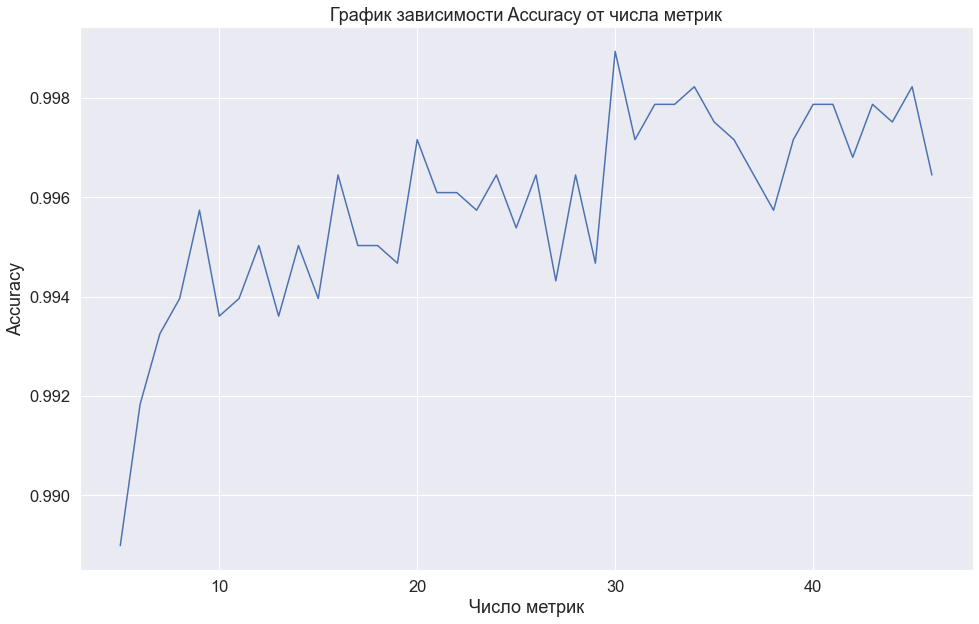

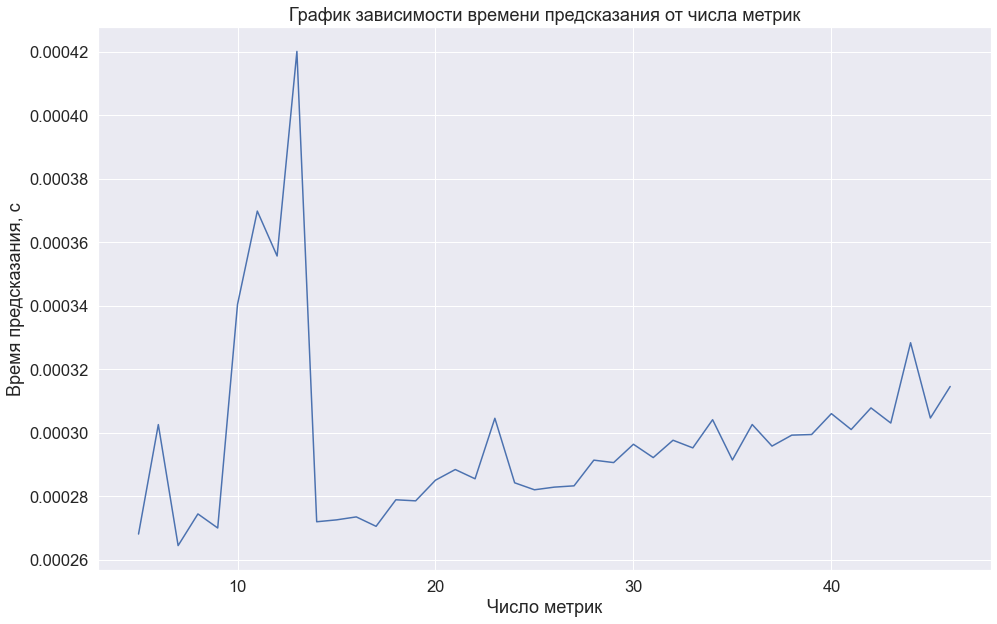

In [40]:
plot_acc_and_time(history, sorted_metrics)

### Определение осанки для ходячего положения

Сначала выделим ключевые метрики.

In [46]:
data = pd.read_csv('../'+DATASET_PATH, index_col=[0, 1])
data = data.reset_index(drop=True)
data = data[data['position'] == 3].drop(['position', 'age'], axis=1)
data.head()

,x_mean,x_std,x_max,x_min,x_energy,x_iqr,y_mean,y_std,y_max,y_min,...,x_iqr_pos1,y_iqr_pos1,z_iqr_pos1,xy_corr_pos1,xz_corr_pos1,yz_corr_pos1,height,mass,is_valid,sex
70,12685.04,2477.023409,22084.0,6396.0,1.669845e+08,3433.0,1969.00,3074.250090,12488.0,-3760.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1
71,12148.96,2494.978107,22084.0,6396.0,1.537599e+08,2141.0,1951.48,3311.899216,12488.0,-3760.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1
72,12151.88,3207.290657,25876.0,6396.0,1.578520e+08,2697.0,1784.28,3319.946075,12488.0,-5016.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1
73,12398.36,3620.581932,29072.0,6396.0,1.666969e+08,3260.0,753.16,2951.146042,10968.0,-5704.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1
74,12812.64,3791.848513,29072.0,8804.0,1.783981e+08,3707.0,97.68,2808.045249,8604.0,-5844.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1


In [47]:
y = data['is_valid']
X = data.drop('is_valid', axis=1)

In [48]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=1234
)

Исследуем зависимости от числа используемых метрик.

In [51]:
history = defaultdict(list)

params_grid = {
            'n_estimators': [100, 200, 300, 500],
            'max_depth' : np.arange(3, 7),
            'learning_rate': np.linspace(0.0125, 0.6, 10)
        }

In [52]:
for i in tqdm(range(5, len(sorted_metrics))):
    metrics = sorted_metrics[:i]
    X_train_cut = X_train[metrics]
    X_test_cut = X_test[metrics]
    
    model = getBestModelCB(X_train_cut, X_test_cut, y_train, y_test,
                        params_grid=params_grid)
    
    X_test_cut = X_test_cut.to_numpy()
    time_predict = min(timeit.Timer('model.predict(X_test_cut[0])', globals=globals()).repeat(repeat=100, number=1))
    history['time_predict'].append(time_predict)
    
    y_pred = model.predict(X_test_cut)
    accuracy = accuracy_score(y_test, y_pred)
    history['accuracy'].append(accuracy)

  0%|          | 0/42 [00:00<?, ?it/s]

0:	learn: 0.4181249	test: 0.4288376	best: 0.4288376 (0)	total: 1.42ms	remaining: 711ms
100:	learn: 0.0029640	test: 0.0189070	best: 0.0189070 (100)	total: 108ms	remaining: 427ms
200:	learn: 0.0028572	test: 0.0187095	best: 0.0187095 (200)	total: 217ms	remaining: 323ms
300:	learn: 0.0028571	test: 0.0187101	best: 0.0187095 (200)	total: 343ms	remaining: 227ms
400:	learn: 0.0025834	test: 0.0186600	best: 0.0186600 (400)	total: 472ms	remaining: 116ms
499:	learn: 0.0024791	test: 0.0189019	best: 0.0186600 (400)	total: 573ms	remaining: 0us

bestTest = 0.01865998346
bestIteration = 400

Shrink model to first 401 iterations.


  2%|▏         | 1/42 [01:01<41:52, 61.29s/it]

0:	learn: 0.4701197	test: 0.4832004	best: 0.4832004 (0)	total: 1.09ms	remaining: 543ms
100:	learn: 0.0066883	test: 0.0335058	best: 0.0335058 (100)	total: 90.1ms	remaining: 356ms
200:	learn: 0.0051772	test: 0.0318637	best: 0.0318637 (200)	total: 173ms	remaining: 258ms
300:	learn: 0.0050525	test: 0.0317811	best: 0.0317811 (300)	total: 254ms	remaining: 168ms
400:	learn: 0.0049926	test: 0.0318331	best: 0.0317811 (300)	total: 342ms	remaining: 84.5ms
499:	learn: 0.0048817	test: 0.0317623	best: 0.0317623 (499)	total: 428ms	remaining: 0us

bestTest = 0.03176234657
bestIteration = 499



  5%|▍         | 2/42 [02:00<39:55, 59.88s/it]

0:	learn: 0.4157996	test: 0.4243188	best: 0.4243188 (0)	total: 2.09ms	remaining: 1.04s
100:	learn: 0.0023042	test: 0.0157354	best: 0.0157354 (100)	total: 135ms	remaining: 533ms
200:	learn: 0.0022994	test: 0.0157329	best: 0.0157329 (200)	total: 221ms	remaining: 329ms
300:	learn: 0.0022772	test: 0.0157044	best: 0.0157044 (300)	total: 308ms	remaining: 204ms
400:	learn: 0.0022399	test: 0.0157636	best: 0.0157044 (300)	total: 397ms	remaining: 98.1ms


  7%|▋         | 3/42 [03:05<40:34, 62.42s/it]

499:	learn: 0.0019833	test: 0.0160329	best: 0.0157044 (300)	total: 486ms	remaining: 0us

bestTest = 0.0157044299
bestIteration = 300

Shrink model to first 301 iterations.
0:	learn: 0.4563260	test: 0.4663193	best: 0.4663193 (0)	total: 1.06ms	remaining: 532ms
100:	learn: 0.0025044	test: 0.0179943	best: 0.0179943 (100)	total: 84.3ms	remaining: 333ms
200:	learn: 0.0024780	test: 0.0179786	best: 0.0179786 (200)	total: 164ms	remaining: 244ms
300:	learn: 0.0023879	test: 0.0178121	best: 0.0178121 (300)	total: 248ms	remaining: 164ms
400:	learn: 0.0022959	test: 0.0180659	best: 0.0178121 (300)	total: 339ms	remaining: 83.8ms
499:	learn: 0.0020413	test: 0.0171719	best: 0.0171719 (499)	total: 427ms	remaining: 0us

bestTest = 0.01717194311
bestIteration = 499



 10%|▉         | 4/42 [04:15<41:30, 65.55s/it]

0:	learn: 0.3298171	test: 0.3699849	best: 0.3699849 (0)	total: 1.38ms	remaining: 688ms
100:	learn: 0.0025491	test: 0.0179531	best: 0.0179531 (100)	total: 108ms	remaining: 426ms
200:	learn: 0.0025438	test: 0.0180000	best: 0.0179531 (100)	total: 225ms	remaining: 335ms
300:	learn: 0.0025395	test: 0.0180369	best: 0.0179531 (100)	total: 333ms	remaining: 220ms
400:	learn: 0.0024142	test: 0.0179528	best: 0.0179528 (400)	total: 460ms	remaining: 113ms
499:	learn: 0.0022964	test: 0.0177315	best: 0.0177315 (499)	total: 587ms	remaining: 0us

bestTest = 0.01773153548
bestIteration = 499



 12%|█▏        | 5/42 [05:35<43:32, 70.60s/it]

0:	learn: 0.3040585	test: 0.3338062	best: 0.3338062 (0)	total: 1.29ms	remaining: 646ms
100:	learn: 0.0024460	test: 0.0169186	best: 0.0169186 (100)	total: 111ms	remaining: 440ms
200:	learn: 0.0024420	test: 0.0169157	best: 0.0169157 (200)	total: 219ms	remaining: 327ms
300:	learn: 0.0024285	test: 0.0168634	best: 0.0168634 (300)	total: 328ms	remaining: 217ms


 14%|█▍        | 6/42 [06:46<42:31, 70.86s/it]

400:	learn: 0.0024212	test: 0.0168532	best: 0.0168532 (400)	total: 439ms	remaining: 108ms
499:	learn: 0.0024114	test: 0.0168291	best: 0.0168291 (499)	total: 547ms	remaining: 0us

bestTest = 0.01682913045
bestIteration = 499

0:	learn: 0.3117851	test: 0.3363012	best: 0.3363012 (0)	total: 1.03ms	remaining: 516ms
100:	learn: 0.0027256	test: 0.0151979	best: 0.0151979 (100)	total: 77.6ms	remaining: 307ms
200:	learn: 0.0019699	test: 0.0140103	best: 0.0140103 (200)	total: 155ms	remaining: 230ms
300:	learn: 0.0017562	test: 0.0140105	best: 0.0140103 (200)	total: 239ms	remaining: 158ms
400:	learn: 0.0017444	test: 0.0139121	best: 0.0139121 (400)	total: 319ms	remaining: 78.8ms
499:	learn: 0.0015703	test: 0.0137801	best: 0.0137801 (499)	total: 393ms	remaining: 0us

bestTest = 0.0137800728
bestIteration = 499



 17%|█▋        | 7/42 [07:50<39:58, 68.52s/it]

0:	learn: 0.4256026	test: 0.4423924	best: 0.4423924 (0)	total: 6.28ms	remaining: 3.13s
100:	learn: 0.0019406	test: 0.0089805	best: 0.0089805 (100)	total: 147ms	remaining: 582ms
200:	learn: 0.0019384	test: 0.0089696	best: 0.0089696 (200)	total: 276ms	remaining: 410ms
300:	learn: 0.0017718	test: 0.0089258	best: 0.0089258 (300)	total: 394ms	remaining: 260ms
400:	learn: 0.0017703	test: 0.0089153	best: 0.0089153 (400)	total: 503ms	remaining: 124ms
499:	learn: 0.0017683	test: 0.0089022	best: 0.0089022 (499)	total: 617ms	remaining: 0us

bestTest = 0.008902181038
bestIteration = 499



 19%|█▉        | 8/42 [08:56<38:22, 67.73s/it]

0:	learn: 0.5263314	test: 0.5324765	best: 0.5324765 (0)	total: 2.67ms	remaining: 1.33s
100:	learn: 0.0025222	test: 0.0133801	best: 0.0133801 (100)	total: 154ms	remaining: 609ms
200:	learn: 0.0013649	test: 0.0113611	best: 0.0113611 (200)	total: 288ms	remaining: 428ms
300:	learn: 0.0013324	test: 0.0113336	best: 0.0113336 (300)	total: 422ms	remaining: 279ms
400:	learn: 0.0013299	test: 0.0113267	best: 0.0113267 (400)	total: 557ms	remaining: 137ms
499:	learn: 0.0013011	test: 0.0111512	best: 0.0111512 (499)	total: 696ms	remaining: 0us

bestTest = 0.01115122308
bestIteration = 499



 21%|██▏       | 9/42 [10:09<38:06, 69.29s/it]

0:	learn: 0.2790936	test: 0.2965221	best: 0.2965221 (0)	total: 4.62ms	remaining: 2.3s
100:	learn: 0.0013941	test: 0.0147327	best: 0.0147327 (100)	total: 160ms	remaining: 631ms
200:	learn: 0.0012981	test: 0.0143511	best: 0.0143511 (200)	total: 288ms	remaining: 429ms
300:	learn: 0.0011466	test: 0.0135925	best: 0.0135925 (300)	total: 412ms	remaining: 272ms
400:	learn: 0.0011384	test: 0.0136408	best: 0.0135925 (300)	total: 535ms	remaining: 132ms
499:	learn: 0.0011208	test: 0.0137655	best: 0.0135925 (300)	total: 654ms	remaining: 0us

bestTest = 0.01359245559
bestIteration = 300

Shrink model to first 301 iterations.


 24%|██▍       | 10/42 [11:21<37:26, 70.21s/it]

0:	learn: 0.4505022	test: 0.4597923	best: 0.4597923 (0)	total: 4.74ms	remaining: 2.37s
100:	learn: 0.0021854	test: 0.0122162	best: 0.0122162 (100)	total: 194ms	remaining: 767ms
200:	learn: 0.0014430	test: 0.0118730	best: 0.0118730 (200)	total: 316ms	remaining: 470ms
300:	learn: 0.0014417	test: 0.0118703	best: 0.0118703 (300)	total: 451ms	remaining: 298ms
400:	learn: 0.0013842	test: 0.0116496	best: 0.0116496 (400)	total: 582ms	remaining: 144ms
499:	learn: 0.0013830	test: 0.0116510	best: 0.0116496 (400)	total: 711ms	remaining: 0us

bestTest = 0.01164962984
bestIteration = 400

Shrink model to first 401 iterations.


 26%|██▌       | 11/42 [12:33<36:31, 70.69s/it]

0:	learn: 0.3488916	test: 0.3594194	best: 0.3594194 (0)	total: 1.62ms	remaining: 809ms
100:	learn: 0.0017061	test: 0.0174137	best: 0.0174137 (100)	total: 126ms	remaining: 498ms
200:	learn: 0.0016948	test: 0.0174352	best: 0.0174137 (100)	total: 304ms	remaining: 452ms
300:	learn: 0.0016052	test: 0.0172596	best: 0.0172596 (300)	total: 428ms	remaining: 283ms


 29%|██▊       | 12/42 [13:46<35:47, 71.57s/it]

400:	learn: 0.0013427	test: 0.0170814	best: 0.0170814 (400)	total: 543ms	remaining: 134ms
499:	learn: 0.0012824	test: 0.0169849	best: 0.0169849 (499)	total: 647ms	remaining: 0us

bestTest = 0.01698492872
bestIteration = 499

0:	learn: 0.4406986	test: 0.4436208	best: 0.4436208 (0)	total: 2.92ms	remaining: 1.46s
100:	learn: 0.0019818	test: 0.0100753	best: 0.0100753 (100)	total: 961ms	remaining: 3.79s
200:	learn: 0.0016179	test: 0.0102790	best: 0.0100753 (100)	total: 1.72s	remaining: 2.56s
300:	learn: 0.0014124	test: 0.0102471	best: 0.0100753 (100)	total: 2.69s	remaining: 1.78s
400:	learn: 0.0014088	test: 0.0102549	best: 0.0100753 (100)	total: 3.61s	remaining: 892ms
499:	learn: 0.0014053	test: 0.0102598	best: 0.0100753 (100)	total: 4.27s	remaining: 0us

bestTest = 0.01007526277
bestIteration = 100

Shrink model to first 101 iterations.


 31%|███       | 13/42 [15:25<38:28, 79.59s/it]

0:	learn: 0.3346166	test: 0.3485404	best: 0.3485404 (0)	total: 8.15ms	remaining: 4.07s
100:	learn: 0.0014072	test: 0.0109697	best: 0.0109697 (100)	total: 740ms	remaining: 2.92s
200:	learn: 0.0013982	test: 0.0109768	best: 0.0109697 (100)	total: 1.5s	remaining: 2.23s
300:	learn: 0.0013337	test: 0.0106965	best: 0.0106965 (300)	total: 2.47s	remaining: 1.63s
400:	learn: 0.0013330	test: 0.0106972	best: 0.0106965 (300)	total: 3.29s	remaining: 812ms
499:	learn: 0.0013298	test: 0.0107013	best: 0.0106965 (300)	total: 4.05s	remaining: 0us

bestTest = 0.01069651115
bestIteration = 300

Shrink model to first 301 iterations.


 33%|███▎      | 14/42 [19:29<1:00:23, 129.43s/it]

0:	learn: 0.3739949	test: 0.3803653	best: 0.3803653 (0)	total: 1.69ms	remaining: 845ms
100:	learn: 0.0015472	test: 0.0108326	best: 0.0108326 (100)	total: 150ms	remaining: 593ms
200:	learn: 0.0014793	test: 0.0107268	best: 0.0107268 (200)	total: 298ms	remaining: 444ms
300:	learn: 0.0014032	test: 0.0105710	best: 0.0105710 (300)	total: 449ms	remaining: 297ms
400:	learn: 0.0013969	test: 0.0105609	best: 0.0105609 (400)	total: 605ms	remaining: 149ms
499:	learn: 0.0013901	test: 0.0105402	best: 0.0105402 (499)	total: 759ms	remaining: 0us

bestTest = 0.01054023484
bestIteration = 499



 36%|███▌      | 15/42 [21:53<1:00:11, 133.77s/it]

0:	learn: 0.3899515	test: 0.3985196	best: 0.3985196 (0)	total: 2.58ms	remaining: 1.29s
100:	learn: 0.0024041	test: 0.0095397	best: 0.0095397 (100)	total: 1.08s	remaining: 4.28s
200:	learn: 0.0023998	test: 0.0095468	best: 0.0095397 (100)	total: 2s	remaining: 2.97s
300:	learn: 0.0017031	test: 0.0084371	best: 0.0084371 (300)	total: 2.69s	remaining: 1.78s
400:	learn: 0.0017010	test: 0.0084490	best: 0.0084371 (300)	total: 3.5s	remaining: 864ms
499:	learn: 0.0016987	test: 0.0084597	best: 0.0084371 (300)	total: 4.32s	remaining: 0us

bestTest = 0.008437133158
bestIteration = 300

Shrink model to first 301 iterations.


 38%|███▊      | 16/42 [24:58<1:04:40, 149.24s/it]

0:	learn: 0.4482820	test: 0.4637001	best: 0.4637001 (0)	total: 8.22ms	remaining: 4.1s
100:	learn: 0.0015808	test: 0.0082723	best: 0.0082723 (100)	total: 873ms	remaining: 3.45s
200:	learn: 0.0014316	test: 0.0081307	best: 0.0081307 (200)	total: 1.76s	remaining: 2.63s
300:	learn: 0.0014260	test: 0.0081225	best: 0.0081225 (300)	total: 2.57s	remaining: 1.7s
400:	learn: 0.0014224	test: 0.0081145	best: 0.0081145 (400)	total: 3.4s	remaining: 839ms
499:	learn: 0.0013667	test: 0.0081095	best: 0.0081095 (499)	total: 4.25s	remaining: 0us

bestTest = 0.008109450413
bestIteration = 499



 40%|████      | 17/42 [29:22<1:16:35, 183.84s/it]

0:	learn: 0.5410564	test: 0.5543476	best: 0.5543476 (0)	total: 8.72ms	remaining: 4.35s
100:	learn: 0.0023429	test: 0.0106144	best: 0.0106144 (100)	total: 1.14s	remaining: 4.5s
200:	learn: 0.0014470	test: 0.0102341	best: 0.0102341 (200)	total: 2.31s	remaining: 3.44s
300:	learn: 0.0013777	test: 0.0104909	best: 0.0102341 (200)	total: 3.23s	remaining: 2.13s
400:	learn: 0.0013573	test: 0.0106407	best: 0.0102341 (200)	total: 4.11s	remaining: 1.01s
499:	learn: 0.0013543	test: 0.0106482	best: 0.0102341 (200)	total: 5.23s	remaining: 0us

bestTest = 0.010234082
bestIteration = 200

Shrink model to first 201 iterations.


 43%|████▎     | 18/42 [34:05<1:25:24, 213.52s/it]

0:	learn: 0.4298408	test: 0.4411668	best: 0.4411668 (0)	total: 2.74ms	remaining: 1.36s
100:	learn: 0.0017537	test: 0.0098319	best: 0.0098319 (100)	total: 206ms	remaining: 813ms
200:	learn: 0.0014664	test: 0.0089162	best: 0.0089162 (200)	total: 610ms	remaining: 907ms
300:	learn: 0.0014285	test: 0.0088602	best: 0.0088602 (300)	total: 869ms	remaining: 575ms
400:	learn: 0.0014270	test: 0.0088582	best: 0.0088582 (400)	total: 1.08s	remaining: 266ms


 45%|████▌     | 19/42 [38:38<1:28:40, 231.32s/it]

499:	learn: 0.0014058	test: 0.0088021	best: 0.0088021 (499)	total: 1.28s	remaining: 0us

bestTest = 0.008802113061
bestIteration = 499

0:	learn: 0.3611834	test: 0.3801660	best: 0.3801660 (0)	total: 2ms	remaining: 1s
100:	learn: 0.0018964	test: 0.0100362	best: 0.0100362 (100)	total: 792ms	remaining: 3.13s
200:	learn: 0.0017739	test: 0.0097183	best: 0.0097183 (200)	total: 1.7s	remaining: 2.53s
300:	learn: 0.0016119	test: 0.0095608	best: 0.0095608 (300)	total: 2.35s	remaining: 1.55s
400:	learn: 0.0016083	test: 0.0095411	best: 0.0095411 (400)	total: 3.11s	remaining: 768ms
499:	learn: 0.0015562	test: 0.0096629	best: 0.0095411 (400)	total: 3.87s	remaining: 0us

bestTest = 0.009541061975
bestIteration = 400

Shrink model to first 401 iterations.


 48%|████▊     | 20/42 [42:25<1:24:24, 230.21s/it]

0:	learn: 0.4811699	test: 0.4960431	best: 0.4960431 (0)	total: 19.1ms	remaining: 9.54s
100:	learn: 0.0020388	test: 0.0123062	best: 0.0123062 (100)	total: 956ms	remaining: 3.77s
200:	learn: 0.0016649	test: 0.0118930	best: 0.0118930 (200)	total: 1.79s	remaining: 2.66s
300:	learn: 0.0015892	test: 0.0116982	best: 0.0116982 (300)	total: 2.69s	remaining: 1.77s
400:	learn: 0.0015857	test: 0.0117019	best: 0.0116982 (300)	total: 3.54s	remaining: 874ms
499:	learn: 0.0015825	test: 0.0117051	best: 0.0116982 (300)	total: 4.42s	remaining: 0us

bestTest = 0.01169824821
bestIteration = 300

Shrink model to first 301 iterations.


 50%|█████     | 21/42 [47:13<1:26:34, 247.36s/it]

0:	learn: 0.3302326	test: 0.3589823	best: 0.3589823 (0)	total: 16.1ms	remaining: 8.03s
100:	learn: 0.0027170	test: 0.0137607	best: 0.0137607 (100)	total: 745ms	remaining: 2.94s
200:	learn: 0.0027139	test: 0.0136942	best: 0.0136942 (200)	total: 1.57s	remaining: 2.33s
300:	learn: 0.0027090	test: 0.0136363	best: 0.0136363 (300)	total: 2.36s	remaining: 1.56s
400:	learn: 0.0026734	test: 0.0131864	best: 0.0131864 (400)	total: 3.14s	remaining: 776ms
499:	learn: 0.0020035	test: 0.0118764	best: 0.0118764 (499)	total: 3.97s	remaining: 0us

bestTest = 0.0118763674
bestIteration = 499



 52%|█████▏    | 22/42 [51:00<1:20:27, 241.38s/it]

0:	learn: 0.4539128	test: 0.4609871	best: 0.4609871 (0)	total: 19ms	remaining: 9.47s
100:	learn: 0.0013785	test: 0.0138778	best: 0.0138778 (100)	total: 695ms	remaining: 2.75s
200:	learn: 0.0012142	test: 0.0135268	best: 0.0135268 (200)	total: 1.44s	remaining: 2.15s
300:	learn: 0.0012108	test: 0.0135250	best: 0.0135250 (300)	total: 2.06s	remaining: 1.36s
400:	learn: 0.0011635	test: 0.0133959	best: 0.0133959 (400)	total: 2.74s	remaining: 676ms
499:	learn: 0.0011608	test: 0.0133945	best: 0.0133945 (499)	total: 3.49s	remaining: 0us

bestTest = 0.01339447933
bestIteration = 499



 55%|█████▍    | 23/42 [55:39<1:19:58, 252.57s/it]

0:	learn: 0.5247844	test: 0.5352583	best: 0.5352583 (0)	total: 9.03ms	remaining: 4.51s
100:	learn: 0.0020495	test: 0.0115246	best: 0.0115246 (100)	total: 982ms	remaining: 3.88s
200:	learn: 0.0016708	test: 0.0106645	best: 0.0106645 (200)	total: 2s	remaining: 2.98s
300:	learn: 0.0016411	test: 0.0106467	best: 0.0106467 (300)	total: 2.92s	remaining: 1.93s
400:	learn: 0.0015487	test: 0.0107700	best: 0.0106467 (300)	total: 3.82s	remaining: 944ms
499:	learn: 0.0015479	test: 0.0107693	best: 0.0106467 (300)	total: 4.68s	remaining: 0us

bestTest = 0.01064672557
bestIteration = 300

Shrink model to first 301 iterations.


 57%|█████▋    | 24/42 [59:43<1:15:03, 250.17s/it]

0:	learn: 0.3265205	test: 0.3261925	best: 0.3261925 (0)	total: 23.8ms	remaining: 11.9s
100:	learn: 0.0021960	test: 0.0082342	best: 0.0082342 (100)	total: 971ms	remaining: 3.84s
200:	learn: 0.0020200	test: 0.0080140	best: 0.0080140 (200)	total: 1.89s	remaining: 2.81s
300:	learn: 0.0020154	test: 0.0080194	best: 0.0080140 (200)	total: 2.83s	remaining: 1.87s
400:	learn: 0.0020104	test: 0.0080239	best: 0.0080140 (200)	total: 3.78s	remaining: 933ms
499:	learn: 0.0020028	test: 0.0080329	best: 0.0080140 (200)	total: 4.68s	remaining: 0us

bestTest = 0.008014025052
bestIteration = 200

Shrink model to first 201 iterations.


 60%|█████▉    | 25/42 [1:05:01<1:16:38, 270.52s/it]

0:	learn: 0.3311179	test: 0.3562080	best: 0.3562080 (0)	total: 6.74ms	remaining: 3.36s
100:	learn: 0.0022647	test: 0.0120699	best: 0.0120699 (100)	total: 672ms	remaining: 2.65s
200:	learn: 0.0022603	test: 0.0120711	best: 0.0120699 (100)	total: 1.47s	remaining: 2.19s
300:	learn: 0.0022547	test: 0.0120685	best: 0.0120685 (300)	total: 1.78s	remaining: 1.18s
400:	learn: 0.0022504	test: 0.0120673	best: 0.0120673 (400)	total: 2.6s	remaining: 643ms
499:	learn: 0.0013993	test: 0.0105693	best: 0.0105693 (499)	total: 3.51s	remaining: 0us

bestTest = 0.01056931317
bestIteration = 499



 62%|██████▏   | 26/42 [1:10:09<1:15:04, 281.55s/it]

0:	learn: 0.2607032	test: 0.2747732	best: 0.2747732 (0)	total: 6.46ms	remaining: 3.23s
100:	learn: 0.0013935	test: 0.0076202	best: 0.0076202 (100)	total: 521ms	remaining: 2.06s
200:	learn: 0.0013906	test: 0.0076123	best: 0.0076123 (200)	total: 1.07s	remaining: 1.59s
300:	learn: 0.0013872	test: 0.0075939	best: 0.0075939 (300)	total: 1.66s	remaining: 1.09s
400:	learn: 0.0013830	test: 0.0075775	best: 0.0075775 (400)	total: 2.28s	remaining: 564ms


 64%|██████▍   | 27/42 [1:14:09<1:07:17, 269.17s/it]

499:	learn: 0.0013751	test: 0.0075365	best: 0.0075365 (499)	total: 2.67s	remaining: 0us

bestTest = 0.007536499013
bestIteration = 499

0:	learn: 0.4817193	test: 0.4973858	best: 0.4973858 (0)	total: 5.63ms	remaining: 2.81s
100:	learn: 0.0019293	test: 0.0070140	best: 0.0070140 (100)	total: 249ms	remaining: 985ms
200:	learn: 0.0014436	test: 0.0062389	best: 0.0062389 (200)	total: 487ms	remaining: 724ms
300:	learn: 0.0011999	test: 0.0060001	best: 0.0060001 (300)	total: 737ms	remaining: 487ms
400:	learn: 0.0011987	test: 0.0059984	best: 0.0059984 (400)	total: 977ms	remaining: 241ms


 67%|██████▋   | 28/42 [1:16:28<53:43, 230.23s/it]  

499:	learn: 0.0011309	test: 0.0058590	best: 0.0058590 (499)	total: 1.21s	remaining: 0us

bestTest = 0.005859036523
bestIteration = 499

0:	learn: 0.2112047	test: 0.2257889	best: 0.2257889 (0)	total: 5.13ms	remaining: 2.56s
100:	learn: 0.0011934	test: 0.0075574	best: 0.0075574 (100)	total: 992ms	remaining: 3.92s
200:	learn: 0.0011477	test: 0.0074733	best: 0.0074733 (200)	total: 2.17s	remaining: 3.23s
300:	learn: 0.0011456	test: 0.0074629	best: 0.0074629 (300)	total: 3.12s	remaining: 2.06s
400:	learn: 0.0011315	test: 0.0074416	best: 0.0074416 (400)	total: 4.33s	remaining: 1.07s
499:	learn: 0.0011277	test: 0.0074115	best: 0.0074115 (499)	total: 5.27s	remaining: 0us

bestTest = 0.007411537839
bestIteration = 499



 69%|██████▉   | 29/42 [1:20:31<50:40, 233.87s/it]

0:	learn: 0.4359052	test: 0.4496452	best: 0.4496452 (0)	total: 3.17ms	remaining: 1.58s
100:	learn: 0.0022243	test: 0.0069975	best: 0.0069975 (100)	total: 948ms	remaining: 3.75s
200:	learn: 0.0016936	test: 0.0063856	best: 0.0063856 (200)	total: 1.86s	remaining: 2.76s
300:	learn: 0.0016927	test: 0.0063872	best: 0.0063856 (200)	total: 2.69s	remaining: 1.78s
400:	learn: 0.0015625	test: 0.0062648	best: 0.0062648 (400)	total: 3.61s	remaining: 892ms
499:	learn: 0.0015618	test: 0.0062666	best: 0.0062648 (400)	total: 4.52s	remaining: 0us

bestTest = 0.006264827972
bestIteration = 400

Shrink model to first 401 iterations.


 71%|███████▏  | 30/42 [1:25:14<49:44, 248.69s/it]

0:	learn: 0.5169560	test: 0.5160820	best: 0.5160820 (0)	total: 2.05ms	remaining: 1.02s
100:	learn: 0.0019461	test: 0.0049273	best: 0.0049273 (100)	total: 239ms	remaining: 942ms
200:	learn: 0.0013722	test: 0.0039784	best: 0.0039784 (200)	total: 477ms	remaining: 709ms
300:	learn: 0.0013051	test: 0.0038277	best: 0.0038277 (300)	total: 743ms	remaining: 491ms
400:	learn: 0.0012957	test: 0.0037978	best: 0.0037978 (400)	total: 997ms	remaining: 246ms


 74%|███████▍  | 31/42 [1:28:50<43:47, 238.89s/it]

499:	learn: 0.0012894	test: 0.0037816	best: 0.0037816 (499)	total: 1.29s	remaining: 0us

bestTest = 0.003781639273
bestIteration = 499

0:	learn: 0.4975028	test: 0.5034324	best: 0.5034324 (0)	total: 3.07ms	remaining: 1.53s
100:	learn: 0.0031283	test: 0.0075945	best: 0.0075945 (100)	total: 975ms	remaining: 3.85s
200:	learn: 0.0022520	test: 0.0058351	best: 0.0058351 (200)	total: 1.68s	remaining: 2.5s
300:	learn: 0.0022060	test: 0.0057797	best: 0.0057797 (300)	total: 2.44s	remaining: 1.61s
400:	learn: 0.0020194	test: 0.0054089	best: 0.0054089 (400)	total: 3.34s	remaining: 825ms
499:	learn: 0.0020177	test: 0.0054070	best: 0.0054070 (499)	total: 4.36s	remaining: 0us

bestTest = 0.005406957936
bestIteration = 499



 76%|███████▌  | 32/42 [1:31:27<35:41, 214.18s/it]

0:	learn: 0.5050027	test: 0.5095922	best: 0.5095922 (0)	total: 2.1ms	remaining: 1.05s
100:	learn: 0.0026631	test: 0.0070571	best: 0.0070571 (100)	total: 209ms	remaining: 827ms
200:	learn: 0.0018579	test: 0.0054187	best: 0.0054187 (200)	total: 421ms	remaining: 626ms
300:	learn: 0.0016223	test: 0.0048652	best: 0.0048652 (300)	total: 630ms	remaining: 417ms
400:	learn: 0.0016022	test: 0.0048052	best: 0.0048052 (400)	total: 836ms	remaining: 206ms


 79%|███████▊  | 33/42 [1:34:25<30:29, 203.32s/it]

499:	learn: 0.0016005	test: 0.0047999	best: 0.0047999 (499)	total: 1.04s	remaining: 0us

bestTest = 0.00479987621
bestIteration = 499

0:	learn: 0.3176011	test: 0.3297667	best: 0.3297667 (0)	total: 2.11ms	remaining: 1.05s
100:	learn: 0.0012282	test: 0.0064774	best: 0.0064774 (100)	total: 211ms	remaining: 834ms
200:	learn: 0.0012019	test: 0.0064241	best: 0.0064241 (200)	total: 414ms	remaining: 616ms
300:	learn: 0.0011982	test: 0.0064133	best: 0.0064133 (300)	total: 617ms	remaining: 408ms
400:	learn: 0.0011938	test: 0.0064025	best: 0.0064025 (400)	total: 819ms	remaining: 202ms


 81%|████████  | 34/42 [1:36:03<22:54, 171.80s/it]

499:	learn: 0.0011888	test: 0.0063915	best: 0.0063915 (499)	total: 1.02s	remaining: 0us

bestTest = 0.006391540585
bestIteration = 499

0:	learn: 0.3008904	test: 0.3196568	best: 0.3196568 (0)	total: 7.85ms	remaining: 3.92s
100:	learn: 0.0014728	test: 0.0068686	best: 0.0068686 (100)	total: 288ms	remaining: 1.14s
200:	learn: 0.0013725	test: 0.0064391	best: 0.0064391 (200)	total: 499ms	remaining: 743ms
300:	learn: 0.0013610	test: 0.0063711	best: 0.0063711 (300)	total: 743ms	remaining: 491ms
400:	learn: 0.0012978	test: 0.0061938	best: 0.0061938 (400)	total: 1s	remaining: 247ms


 83%|████████▎ | 35/42 [1:38:09<18:26, 158.08s/it]

499:	learn: 0.0012886	test: 0.0061571	best: 0.0061571 (499)	total: 1.39s	remaining: 0us

bestTest = 0.006157088647
bestIteration = 499

0:	learn: 0.2855119	test: 0.2977298	best: 0.2977298 (0)	total: 8.56ms	remaining: 4.27s
100:	learn: 0.0016748	test: 0.0106572	best: 0.0106572 (100)	total: 150ms	remaining: 591ms
200:	learn: 0.0016707	test: 0.0106659	best: 0.0106572 (100)	total: 274ms	remaining: 407ms
300:	learn: 0.0016590	test: 0.0106950	best: 0.0106572 (100)	total: 399ms	remaining: 264ms
400:	learn: 0.0016477	test: 0.0107254	best: 0.0106572 (100)	total: 522ms	remaining: 129ms
499:	learn: 0.0016368	test: 0.0107514	best: 0.0106572 (100)	total: 650ms	remaining: 0us

bestTest = 0.01065720339
bestIteration = 100

Shrink model to first 101 iterations.


 86%|████████▌ | 36/42 [1:39:51<14:07, 141.18s/it]

0:	learn: 0.3035634	test: 0.3270678	best: 0.3270678 (0)	total: 6.54ms	remaining: 3.26s
100:	learn: 0.0018857	test: 0.0111695	best: 0.0111695 (100)	total: 546ms	remaining: 2.16s
200:	learn: 0.0016045	test: 0.0105136	best: 0.0105136 (200)	total: 1.2s	remaining: 1.78s
300:	learn: 0.0016000	test: 0.0105074	best: 0.0105074 (300)	total: 1.83s	remaining: 1.21s
400:	learn: 0.0015828	test: 0.0105089	best: 0.0105074 (300)	total: 2.43s	remaining: 600ms
499:	learn: 0.0015782	test: 0.0105052	best: 0.0105052 (499)	total: 3.04s	remaining: 0us

bestTest = 0.01050517623
bestIteration = 499



 88%|████████▊ | 37/42 [1:42:44<12:34, 150.90s/it]

0:	learn: 0.2601706	test: 0.2755148	best: 0.2755148 (0)	total: 13.4ms	remaining: 6.66s
100:	learn: 0.0015559	test: 0.0078990	best: 0.0078990 (100)	total: 934ms	remaining: 3.69s
200:	learn: 0.0015521	test: 0.0078887	best: 0.0078887 (200)	total: 1.82s	remaining: 2.71s
300:	learn: 0.0015489	test: 0.0078769	best: 0.0078769 (300)	total: 2.73s	remaining: 1.81s
400:	learn: 0.0014078	test: 0.0076773	best: 0.0076773 (400)	total: 3.67s	remaining: 905ms


 90%|█████████ | 38/42 [1:48:41<14:11, 212.76s/it]

499:	learn: 0.0014063	test: 0.0076672	best: 0.0076672 (499)	total: 4.51s	remaining: 0us

bestTest = 0.007667216273
bestIteration = 499

0:	learn: 0.4077553	test: 0.4297866	best: 0.4297866 (0)	total: 1.79ms	remaining: 893ms
100:	learn: 0.0021605	test: 0.0074048	best: 0.0074048 (100)	total: 216ms	remaining: 853ms
200:	learn: 0.0017684	test: 0.0067722	best: 0.0067722 (200)	total: 409ms	remaining: 608ms
300:	learn: 0.0017092	test: 0.0065667	best: 0.0065667 (300)	total: 602ms	remaining: 398ms
400:	learn: 0.0016501	test: 0.0064312	best: 0.0064312 (400)	total: 788ms	remaining: 194ms


 93%|█████████▎| 39/42 [1:52:42<11:03, 221.10s/it]

499:	learn: 0.0016476	test: 0.0064200	best: 0.0064200 (499)	total: 951ms	remaining: 0us

bestTest = 0.006420002461
bestIteration = 499

0:	learn: 0.3152519	test: 0.3522174	best: 0.3522174 (0)	total: 2.18ms	remaining: 1.09s
100:	learn: 0.0027376	test: 0.0130885	best: 0.0130885 (100)	total: 477ms	remaining: 1.88s
200:	learn: 0.0013065	test: 0.0086713	best: 0.0086713 (200)	total: 1.24s	remaining: 1.85s
300:	learn: 0.0011526	test: 0.0080902	best: 0.0080902 (300)	total: 2.26s	remaining: 1.49s
400:	learn: 0.0011085	test: 0.0079764	best: 0.0079764 (400)	total: 3.1s	remaining: 765ms
499:	learn: 0.0010949	test: 0.0079453	best: 0.0079453 (499)	total: 4.11s	remaining: 0us

bestTest = 0.007945323581
bestIteration = 499



 95%|█████████▌| 40/42 [1:54:41<06:20, 190.38s/it]

0:	learn: 0.4529333	test: 0.4622034	best: 0.4622034 (0)	total: 4.16ms	remaining: 2.08s
100:	learn: 0.0017880	test: 0.0057260	best: 0.0057260 (100)	total: 183ms	remaining: 724ms
200:	learn: 0.0016959	test: 0.0054352	best: 0.0054352 (200)	total: 354ms	remaining: 527ms
300:	learn: 0.0016479	test: 0.0051966	best: 0.0051966 (300)	total: 526ms	remaining: 348ms
400:	learn: 0.0016453	test: 0.0051908	best: 0.0051908 (400)	total: 698ms	remaining: 172ms
499:	learn: 0.0016414	test: 0.0051788	best: 0.0051788 (499)	total: 867ms	remaining: 0us

bestTest = 0.005178800847
bestIteration = 499



 98%|█████████▊| 41/42 [1:58:25<03:20, 200.51s/it]

0:	learn: 0.4543868	test: 0.4574831	best: 0.4574831 (0)	total: 5.7ms	remaining: 2.84s
100:	learn: 0.0018082	test: 0.0072051	best: 0.0072051 (100)	total: 218ms	remaining: 861ms
200:	learn: 0.0017146	test: 0.0067999	best: 0.0067999 (200)	total: 393ms	remaining: 584ms
300:	learn: 0.0015066	test: 0.0060712	best: 0.0060712 (300)	total: 582ms	remaining: 385ms
400:	learn: 0.0012851	test: 0.0056631	best: 0.0056631 (400)	total: 760ms	remaining: 188ms


100%|██████████| 42/42 [2:00:18<00:00, 171.87s/it]

499:	learn: 0.0012835	test: 0.0056561	best: 0.0056561 (499)	total: 949ms	remaining: 0us

bestTest = 0.005656128011
bestIteration = 499



In [53]:
# сохранение истории
with open('history_valid_3.json', 'w') as fp:
    json.dump(history, fp)

In [54]:
# загрузка истории
with open('history_valid_3.json', 'r') as fp:
    history = json.load(fp)

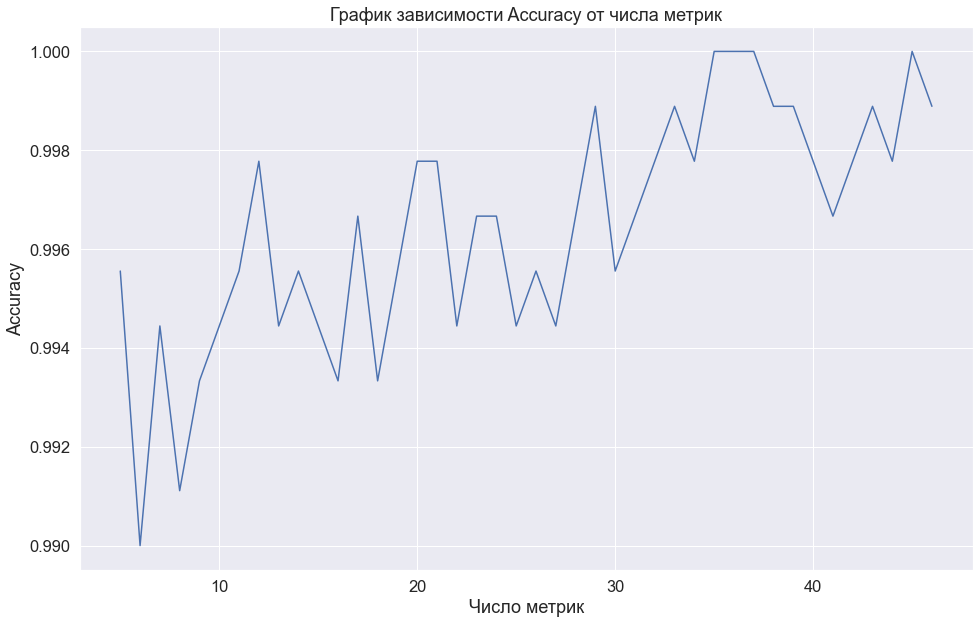

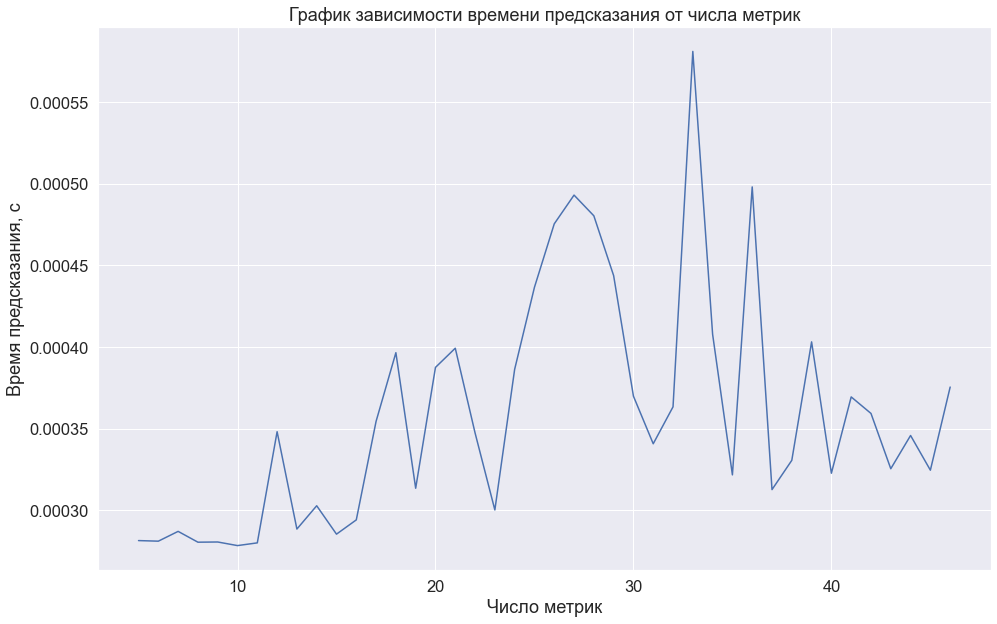

In [55]:
plot_acc_and_time(history, sorted_metrics)

### Определение позиции

In [56]:
data = pd.read_csv('../datasets/added_pos1_metrics_windowed.csv', index_col=[0, 1])
data = data.reset_index(drop=True)
data = data.drop(['is_valid', 'age'], axis=1)
data.head()

,x_mean,x_std,x_max,x_min,x_energy,x_iqr,y_mean,y_std,y_max,y_min,...,x_iqr_pos1,y_iqr_pos1,z_iqr_pos1,xy_corr_pos1,xz_corr_pos1,yz_corr_pos1,height,mass,position,sex
0,11156.76,123.532772,11380.0,10836.0,1.244884e+08,177.0,1158.80,73.172275,1348.0,920.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,1,1
1,11156.88,128.858961,11380.0,10836.0,1.244924e+08,193.0,1137.96,69.416023,1300.0,920.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,1,1
2,11154.36,134.410311,11532.0,10836.0,1.244376e+08,190.0,1088.32,171.829072,1380.0,164.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,1,1
3,10998.28,415.506022,11532.0,9384.0,1.211331e+08,323.0,853.36,499.190851,1380.0,-1032.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,1,1
4,10883.04,409.575930,11532.0,9384.0,1.186066e+08,543.0,537.68,622.192456,1380.0,-1032.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,1,1


In [57]:
y = data['position']
X = data.drop('position', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=1234
)

In [62]:
history = defaultdict(list)


params_grid = {
            'n_estimators': [200, 300, 500],
            'max_depth' : np.arange(3, 6),
            'learning_rate': np.linspace(0.5, 0.6, 8)
        }

In [63]:
for i in tqdm(range(5, len(sorted_metrics))):
    metrics = sorted_metrics[:i]
    X_train_cut = X_train[metrics]
    X_test_cut = X_test[metrics]
    
    model = getBestModelCB(X_train[metrics], X_test[metrics], y_train, y_test,
                        params_grid=params_grid,
                        loss_function='MultiClass')
    
    X_test_cut = X_test_cut.to_numpy()
    time_predict = min(timeit.Timer('model.predict(X_test_cut[0])', globals=globals()).repeat(repeat=100, number=1))
    history['time_predict'].append(time_predict)
    
    y_pred = model.predict(X_test_cut)
    accuracy = accuracy_score(y_test, y_pred)
    history['accuracy'].append(accuracy)

  0%|          | 0/42 [00:00<?, ?it/s]

0:	learn: 0.7844178	test: 0.7905444	best: 0.7905444 (0)	total: 3.33ms	remaining: 1.66s
100:	learn: 0.0610827	test: 0.0835199	best: 0.0835199 (100)	total: 1.09s	remaining: 4.32s
200:	learn: 0.0297500	test: 0.0619745	best: 0.0619745 (200)	total: 2.24s	remaining: 3.33s
300:	learn: 0.0189259	test: 0.0546912	best: 0.0546912 (300)	total: 3.32s	remaining: 2.19s
400:	learn: 0.0132936	test: 0.0498707	best: 0.0498707 (400)	total: 4.39s	remaining: 1.08s
499:	learn: 0.0101656	test: 0.0482833	best: 0.0482833 (499)	total: 5.75s	remaining: 0us

bestTest = 0.04828330365
bestIteration = 499



  2%|▏         | 1/42 [01:22<56:22, 82.49s/it]

0:	learn: 0.7145523	test: 0.7170198	best: 0.7170198 (0)	total: 23.4ms	remaining: 11.7s
100:	learn: 0.0446464	test: 0.0769722	best: 0.0769722 (100)	total: 1.01s	remaining: 4.01s
200:	learn: 0.0211790	test: 0.0598482	best: 0.0598482 (200)	total: 2.21s	remaining: 3.29s
300:	learn: 0.0125008	test: 0.0524914	best: 0.0524914 (300)	total: 3.33s	remaining: 2.2s
400:	learn: 0.0085229	test: 0.0494702	best: 0.0494702 (400)	total: 4.33s	remaining: 1.07s
499:	learn: 0.0061596	test: 0.0465188	best: 0.0465188 (499)	total: 5.36s	remaining: 0us

bestTest = 0.04651875305
bestIteration = 499



  5%|▍         | 2/42 [04:44<1:41:58, 152.97s/it]

0:	learn: 0.6957954	test: 0.6909354	best: 0.6909354 (0)	total: 2.37ms	remaining: 1.18s
100:	learn: 0.0305936	test: 0.0545859	best: 0.0545859 (100)	total: 214ms	remaining: 846ms
200:	learn: 0.0137147	test: 0.0393031	best: 0.0393031 (200)	total: 421ms	remaining: 627ms
300:	learn: 0.0079047	test: 0.0342688	best: 0.0342688 (300)	total: 627ms	remaining: 415ms
400:	learn: 0.0051348	test: 0.0311042	best: 0.0311042 (400)	total: 908ms	remaining: 224ms


  7%|▋         | 3/42 [08:28<2:00:23, 185.21s/it]

499:	learn: 0.0038081	test: 0.0291847	best: 0.0291847 (499)	total: 1.16s	remaining: 0us

bestTest = 0.0291847125
bestIteration = 499

0:	learn: 0.7400811	test: 0.7364912	best: 0.7364912 (0)	total: 2.21ms	remaining: 1.1s
100:	learn: 0.0337751	test: 0.0575699	best: 0.0575699 (100)	total: 213ms	remaining: 840ms
200:	learn: 0.0135164	test: 0.0386104	best: 0.0386104 (200)	total: 401ms	remaining: 596ms
300:	learn: 0.0082388	test: 0.0319433	best: 0.0319433 (300)	total: 587ms	remaining: 388ms
400:	learn: 0.0054824	test: 0.0285103	best: 0.0285103 (400)	total: 777ms	remaining: 192ms


 10%|▉         | 4/42 [09:58<1:33:24, 147.49s/it]

499:	learn: 0.0040407	test: 0.0270843	best: 0.0270843 (499)	total: 979ms	remaining: 0us

bestTest = 0.02708426974
bestIteration = 499

0:	learn: 0.7263979	test: 0.7294979	best: 0.7294979 (0)	total: 3.46ms	remaining: 1.73s
100:	learn: 0.0262078	test: 0.0469275	best: 0.0469275 (100)	total: 209ms	remaining: 826ms
200:	learn: 0.0109718	test: 0.0309967	best: 0.0309967 (200)	total: 551ms	remaining: 820ms
300:	learn: 0.0065713	test: 0.0256715	best: 0.0256715 (300)	total: 772ms	remaining: 510ms
400:	learn: 0.0043080	test: 0.0232171	best: 0.0232171 (400)	total: 968ms	remaining: 239ms


 12%|█▏        | 5/42 [11:21<1:16:46, 124.50s/it]

499:	learn: 0.0031973	test: 0.0218632	best: 0.0218632 (499)	total: 1.2s	remaining: 0us

bestTest = 0.02186323339
bestIteration = 499

0:	learn: 0.7487083	test: 0.7456856	best: 0.7456856 (0)	total: 9.01ms	remaining: 4.49s
100:	learn: 0.0298046	test: 0.0490368	best: 0.0490368 (100)	total: 1.02s	remaining: 4.03s
200:	learn: 0.0121947	test: 0.0345441	best: 0.0345441 (200)	total: 1.97s	remaining: 2.92s
300:	learn: 0.0068410	test: 0.0285339	best: 0.0285339 (300)	total: 2.87s	remaining: 1.9s
400:	learn: 0.0047306	test: 0.0261734	best: 0.0261734 (400)	total: 3.73s	remaining: 922ms
499:	learn: 0.0035199	test: 0.0249022	best: 0.0249022 (499)	total: 4.61s	remaining: 0us

bestTest = 0.02490218624
bestIteration = 499



 14%|█▍        | 6/42 [13:29<1:15:16, 125.46s/it]

0:	learn: 0.7265103	test: 0.7192460	best: 0.7192460 (0)	total: 4.89ms	remaining: 2.44s
100:	learn: 0.0255634	test: 0.0416745	best: 0.0416745 (100)	total: 302ms	remaining: 1.19s
200:	learn: 0.0111139	test: 0.0282363	best: 0.0282363 (200)	total: 599ms	remaining: 891ms
300:	learn: 0.0064511	test: 0.0242615	best: 0.0242615 (300)	total: 925ms	remaining: 612ms
400:	learn: 0.0043765	test: 0.0214996	best: 0.0214996 (400)	total: 1.23s	remaining: 303ms


 17%|█▋        | 7/42 [16:31<1:23:58, 143.96s/it]

499:	learn: 0.0032406	test: 0.0204406	best: 0.0204406 (499)	total: 1.81s	remaining: 0us

bestTest = 0.02044060106
bestIteration = 499

0:	learn: 0.7390443	test: 0.7316459	best: 0.7316459 (0)	total: 6.59ms	remaining: 3.29s
100:	learn: 0.0272354	test: 0.0421634	best: 0.0421634 (100)	total: 1.13s	remaining: 4.48s
200:	learn: 0.0114143	test: 0.0278414	best: 0.0278414 (200)	total: 2.37s	remaining: 3.52s
300:	learn: 0.0067774	test: 0.0226045	best: 0.0226045 (300)	total: 3.51s	remaining: 2.32s
400:	learn: 0.0045189	test: 0.0200768	best: 0.0200768 (400)	total: 4.71s	remaining: 1.16s
499:	learn: 0.0033926	test: 0.0189930	best: 0.0189930 (499)	total: 5.88s	remaining: 0us

bestTest = 0.01899300886
bestIteration = 499



 19%|█▉        | 8/42 [18:05<1:12:33, 128.05s/it]

0:	learn: 0.7378711	test: 0.7340772	best: 0.7340772 (0)	total: 10.1ms	remaining: 5.03s
100:	learn: 0.0281402	test: 0.0486723	best: 0.0486723 (100)	total: 1.28s	remaining: 5.08s
200:	learn: 0.0111929	test: 0.0330531	best: 0.0330531 (200)	total: 2.46s	remaining: 3.65s
300:	learn: 0.0064797	test: 0.0279794	best: 0.0279794 (300)	total: 3.63s	remaining: 2.4s
400:	learn: 0.0044269	test: 0.0258759	best: 0.0258759 (400)	total: 4.84s	remaining: 1.2s
499:	learn: 0.0033260	test: 0.0247827	best: 0.0247827 (499)	total: 5.99s	remaining: 0us

bestTest = 0.02478274293
bestIteration = 499



 21%|██▏       | 9/42 [20:16<1:11:04, 129.23s/it]

0:	learn: 0.7312601	test: 0.7316345	best: 0.7316345 (0)	total: 4.39ms	remaining: 2.19s
100:	learn: 0.0260485	test: 0.0451729	best: 0.0451729 (100)	total: 1.23s	remaining: 4.87s
200:	learn: 0.0105204	test: 0.0297612	best: 0.0297612 (200)	total: 2.48s	remaining: 3.69s
300:	learn: 0.0061316	test: 0.0248346	best: 0.0248346 (300)	total: 3.73s	remaining: 2.46s
400:	learn: 0.0041654	test: 0.0222928	best: 0.0222928 (400)	total: 4.97s	remaining: 1.23s
499:	learn: 0.0030143	test: 0.0208876	best: 0.0208876 (499)	total: 6.22s	remaining: 0us

bestTest = 0.02088762602
bestIteration = 499



 24%|██▍       | 10/42 [23:41<1:21:17, 152.41s/it]

0:	learn: 0.7493045	test: 0.7475755	best: 0.7475755 (0)	total: 4.49ms	remaining: 2.24s
100:	learn: 0.0252921	test: 0.0423045	best: 0.0423045 (100)	total: 1.3s	remaining: 5.15s
200:	learn: 0.0112420	test: 0.0306099	best: 0.0306099 (200)	total: 2.46s	remaining: 3.67s
300:	learn: 0.0065277	test: 0.0258031	best: 0.0258031 (300)	total: 3.66s	remaining: 2.42s
400:	learn: 0.0044536	test: 0.0229455	best: 0.0229455 (400)	total: 4.85s	remaining: 1.2s
499:	learn: 0.0033453	test: 0.0218010	best: 0.0218010 (499)	total: 6.01s	remaining: 0us

bestTest = 0.02180104382
bestIteration = 499



 26%|██▌       | 11/42 [26:11<1:18:23, 151.71s/it]

0:	learn: 0.7121545	test: 0.7173727	best: 0.7173727 (0)	total: 15.9ms	remaining: 7.91s
100:	learn: 0.0212189	test: 0.0394702	best: 0.0394702 (100)	total: 1.75s	remaining: 6.9s
200:	learn: 0.0081042	test: 0.0263053	best: 0.0263053 (200)	total: 3.29s	remaining: 4.89s
300:	learn: 0.0046941	test: 0.0221995	best: 0.0221995 (300)	total: 4.6s	remaining: 3.04s
400:	learn: 0.0029894	test: 0.0198448	best: 0.0198448 (400)	total: 5.77s	remaining: 1.42s
499:	learn: 0.0022421	test: 0.0188545	best: 0.0188545 (499)	total: 6.96s	remaining: 0us

bestTest = 0.01885446408
bestIteration = 499



 29%|██▊       | 12/42 [30:51<1:35:23, 190.80s/it]

0:	learn: 0.7434307	test: 0.7422282	best: 0.7422282 (0)	total: 2.23ms	remaining: 1.11s
100:	learn: 0.0317008	test: 0.0494922	best: 0.0494922 (100)	total: 186ms	remaining: 736ms
200:	learn: 0.0122865	test: 0.0296197	best: 0.0296197 (200)	total: 378ms	remaining: 562ms
300:	learn: 0.0066305	test: 0.0231767	best: 0.0231767 (300)	total: 566ms	remaining: 374ms
400:	learn: 0.0044307	test: 0.0201323	best: 0.0201323 (400)	total: 762ms	remaining: 188ms


 31%|███       | 13/42 [32:39<1:20:01, 165.57s/it]

499:	learn: 0.0032960	test: 0.0183617	best: 0.0183617 (499)	total: 988ms	remaining: 0us

bestTest = 0.01836165117
bestIteration = 499

0:	learn: 0.7204214	test: 0.7122449	best: 0.7122449 (0)	total: 2.87ms	remaining: 1.43s
100:	learn: 0.0258582	test: 0.0438661	best: 0.0438661 (100)	total: 248ms	remaining: 980ms
200:	learn: 0.0108631	test: 0.0291940	best: 0.0291940 (200)	total: 493ms	remaining: 733ms
300:	learn: 0.0059614	test: 0.0230912	best: 0.0230912 (300)	total: 734ms	remaining: 485ms
400:	learn: 0.0039305	test: 0.0206278	best: 0.0206278 (400)	total: 975ms	remaining: 241ms


 33%|███▎      | 14/42 [34:22<1:08:26, 146.65s/it]

499:	learn: 0.0029068	test: 0.0192451	best: 0.0192451 (499)	total: 1.21s	remaining: 0us

bestTest = 0.01924513455
bestIteration = 499

0:	learn: 0.6762103	test: 0.6733805	best: 0.6733805 (0)	total: 7.15ms	remaining: 3.57s
100:	learn: 0.0201399	test: 0.0384599	best: 0.0384599 (100)	total: 440ms	remaining: 1.74s
200:	learn: 0.0081617	test: 0.0273700	best: 0.0273700 (200)	total: 1.09s	remaining: 1.62s
300:	learn: 0.0045220	test: 0.0224278	best: 0.0224278 (300)	total: 1.4s	remaining: 927ms
400:	learn: 0.0031251	test: 0.0201397	best: 0.0201397 (400)	total: 1.68s	remaining: 415ms


 36%|███▌      | 15/42 [35:56<58:54, 130.90s/it]  

499:	learn: 0.0023275	test: 0.0190526	best: 0.0190526 (499)	total: 1.95s	remaining: 0us

bestTest = 0.01905262105
bestIteration = 499

0:	learn: 0.6871364	test: 0.6856915	best: 0.6856915 (0)	total: 7.73ms	remaining: 3.86s
100:	learn: 0.0196764	test: 0.0369998	best: 0.0369998 (100)	total: 271ms	remaining: 1.07s
200:	learn: 0.0078209	test: 0.0230227	best: 0.0230227 (200)	total: 615ms	remaining: 914ms
300:	learn: 0.0042018	test: 0.0183378	best: 0.0183378 (300)	total: 893ms	remaining: 590ms
400:	learn: 0.0027663	test: 0.0165725	best: 0.0165725 (400)	total: 1.16s	remaining: 286ms


 38%|███▊      | 16/42 [37:33<52:21, 120.81s/it]

499:	learn: 0.0020715	test: 0.0155576	best: 0.0155576 (499)	total: 1.41s	remaining: 0us

bestTest = 0.01555761655
bestIteration = 499

0:	learn: 0.6392289	test: 0.6303933	best: 0.6303933 (0)	total: 3.02ms	remaining: 1.51s
100:	learn: 0.0204396	test: 0.0373537	best: 0.0373537 (100)	total: 277ms	remaining: 1.1s
200:	learn: 0.0078138	test: 0.0244499	best: 0.0244499 (200)	total: 552ms	remaining: 821ms
300:	learn: 0.0044006	test: 0.0197125	best: 0.0197125 (300)	total: 845ms	remaining: 559ms
400:	learn: 0.0029704	test: 0.0176567	best: 0.0176567 (400)	total: 1.12s	remaining: 277ms


 40%|████      | 17/42 [39:15<47:57, 115.12s/it]

499:	learn: 0.0021749	test: 0.0163227	best: 0.0163227 (499)	total: 1.41s	remaining: 0us

bestTest = 0.01632266486
bestIteration = 499

0:	learn: 0.6348741	test: 0.6310980	best: 0.6310980 (0)	total: 11.3ms	remaining: 5.66s
100:	learn: 0.0203164	test: 0.0374493	best: 0.0374493 (100)	total: 300ms	remaining: 1.19s
200:	learn: 0.0073215	test: 0.0249664	best: 0.0249664 (200)	total: 577ms	remaining: 859ms
300:	learn: 0.0041094	test: 0.0204528	best: 0.0204528 (300)	total: 849ms	remaining: 561ms
400:	learn: 0.0028213	test: 0.0181140	best: 0.0181140 (400)	total: 1.13s	remaining: 279ms


 43%|████▎     | 18/42 [40:47<43:11, 107.99s/it]

499:	learn: 0.0020990	test: 0.0168355	best: 0.0168355 (499)	total: 1.4s	remaining: 0us

bestTest = 0.0168355059
bestIteration = 499

0:	learn: 0.6088942	test: 0.6023145	best: 0.6023145 (0)	total: 3.27ms	remaining: 1.63s
100:	learn: 0.0169105	test: 0.0341128	best: 0.0341128 (100)	total: 274ms	remaining: 1.08s
200:	learn: 0.0062221	test: 0.0223470	best: 0.0223470 (200)	total: 542ms	remaining: 806ms
300:	learn: 0.0036046	test: 0.0193656	best: 0.0193656 (300)	total: 806ms	remaining: 533ms
400:	learn: 0.0023938	test: 0.0171572	best: 0.0171572 (400)	total: 1.1s	remaining: 271ms


 45%|████▌     | 19/42 [42:14<39:03, 101.88s/it]

499:	learn: 0.0017288	test: 0.0163247	best: 0.0163247 (499)	total: 1.36s	remaining: 0us

bestTest = 0.01632469566
bestIteration = 499

0:	learn: 0.5751330	test: 0.5701228	best: 0.5701228 (0)	total: 3.02ms	remaining: 1.51s
100:	learn: 0.0170678	test: 0.0313894	best: 0.0313894 (100)	total: 276ms	remaining: 1.09s
200:	learn: 0.0063138	test: 0.0195208	best: 0.0195208 (200)	total: 546ms	remaining: 812ms
300:	learn: 0.0035164	test: 0.0158152	best: 0.0158152 (300)	total: 819ms	remaining: 542ms
400:	learn: 0.0023705	test: 0.0142595	best: 0.0142595 (400)	total: 1.08s	remaining: 268ms


 48%|████▊     | 20/42 [43:43<35:52, 97.84s/it] 

499:	learn: 0.0017025	test: 0.0133572	best: 0.0133572 (499)	total: 1.35s	remaining: 0us

bestTest = 0.01335724936
bestIteration = 499

0:	learn: 0.6174307	test: 0.6157232	best: 0.6157232 (0)	total: 8.85ms	remaining: 4.42s
100:	learn: 0.0186570	test: 0.0344586	best: 0.0344586 (100)	total: 286ms	remaining: 1.13s
200:	learn: 0.0066573	test: 0.0222688	best: 0.0222688 (200)	total: 556ms	remaining: 827ms
300:	learn: 0.0038360	test: 0.0192477	best: 0.0192477 (300)	total: 823ms	remaining: 544ms
400:	learn: 0.0024842	test: 0.0167178	best: 0.0167178 (400)	total: 1.09s	remaining: 269ms


 50%|█████     | 21/42 [45:12<33:21, 95.29s/it]

499:	learn: 0.0018426	test: 0.0158521	best: 0.0158521 (499)	total: 1.37s	remaining: 0us

bestTest = 0.01585210042
bestIteration = 499

0:	learn: 0.6419026	test: 0.6385874	best: 0.6385874 (0)	total: 2.89ms	remaining: 1.44s
100:	learn: 0.0172232	test: 0.0329017	best: 0.0329017 (100)	total: 280ms	remaining: 1.11s
200:	learn: 0.0066346	test: 0.0220874	best: 0.0220874 (200)	total: 556ms	remaining: 826ms
300:	learn: 0.0036833	test: 0.0183144	best: 0.0183144 (300)	total: 871ms	remaining: 576ms
400:	learn: 0.0024169	test: 0.0167907	best: 0.0167907 (400)	total: 1.26s	remaining: 311ms


 52%|█████▏    | 22/42 [46:42<31:11, 93.59s/it]

499:	learn: 0.0018225	test: 0.0155488	best: 0.0155488 (499)	total: 1.54s	remaining: 0us

bestTest = 0.01554880619
bestIteration = 499

0:	learn: 0.6045109	test: 0.5959463	best: 0.5959463 (0)	total: 3.01ms	remaining: 1.5s
100:	learn: 0.0154400	test: 0.0337793	best: 0.0337793 (100)	total: 267ms	remaining: 1.05s
200:	learn: 0.0053470	test: 0.0213132	best: 0.0213132 (200)	total: 533ms	remaining: 794ms
300:	learn: 0.0030379	test: 0.0182517	best: 0.0182517 (300)	total: 801ms	remaining: 530ms
400:	learn: 0.0021328	test: 0.0172521	best: 0.0172521 (400)	total: 1.06s	remaining: 263ms


 55%|█████▍    | 23/42 [48:15<29:37, 93.56s/it]

499:	learn: 0.0016153	test: 0.0166361	best: 0.0166361 (499)	total: 1.33s	remaining: 0us

bestTest = 0.01663607644
bestIteration = 499

0:	learn: 0.6051809	test: 0.5987924	best: 0.5987924 (0)	total: 3.08ms	remaining: 1.54s
100:	learn: 0.0157741	test: 0.0337149	best: 0.0337149 (100)	total: 268ms	remaining: 1.06s
200:	learn: 0.0059094	test: 0.0223394	best: 0.0223394 (200)	total: 534ms	remaining: 794ms
300:	learn: 0.0031777	test: 0.0189405	best: 0.0189405 (300)	total: 800ms	remaining: 529ms
400:	learn: 0.0021727	test: 0.0177711	best: 0.0177711 (400)	total: 1.06s	remaining: 263ms


 57%|█████▋    | 24/42 [49:45<27:44, 92.46s/it]

499:	learn: 0.0016358	test: 0.0167890	best: 0.0167890 (499)	total: 1.33s	remaining: 0us

bestTest = 0.01678904209
bestIteration = 499

0:	learn: 0.6094962	test: 0.6002915	best: 0.6002915 (0)	total: 3.36ms	remaining: 1.68s
100:	learn: 0.0115753	test: 0.0226424	best: 0.0226424 (100)	total: 298ms	remaining: 1.18s
200:	learn: 0.0047430	test: 0.0148483	best: 0.0148483 (200)	total: 590ms	remaining: 878ms
300:	learn: 0.0025317	test: 0.0114948	best: 0.0114948 (300)	total: 884ms	remaining: 584ms
400:	learn: 0.0017237	test: 0.0097026	best: 0.0097026 (400)	total: 1.18s	remaining: 290ms


 60%|█████▉    | 25/42 [51:19<26:21, 93.02s/it]

499:	learn: 0.0012885	test: 0.0089677	best: 0.0089677 (499)	total: 1.46s	remaining: 0us

bestTest = 0.008967737377
bestIteration = 499

0:	learn: 0.6222726	test: 0.6180499	best: 0.6180499 (0)	total: 6.36ms	remaining: 3.17s
100:	learn: 0.0158715	test: 0.0270569	best: 0.0270569 (100)	total: 305ms	remaining: 1.2s
200:	learn: 0.0059091	test: 0.0156412	best: 0.0156412 (200)	total: 605ms	remaining: 899ms
300:	learn: 0.0034361	test: 0.0119007	best: 0.0119007 (300)	total: 910ms	remaining: 602ms
400:	learn: 0.0022408	test: 0.0102964	best: 0.0102964 (400)	total: 1.21s	remaining: 299ms


 62%|██████▏   | 26/42 [52:55<25:00, 93.77s/it]

499:	learn: 0.0016177	test: 0.0092442	best: 0.0092442 (499)	total: 1.51s	remaining: 0us

bestTest = 0.009244243174
bestIteration = 499

0:	learn: 0.5791837	test: 0.5734903	best: 0.5734903 (0)	total: 3.37ms	remaining: 1.68s
100:	learn: 0.0122036	test: 0.0257790	best: 0.0257790 (100)	total: 297ms	remaining: 1.17s
200:	learn: 0.0044643	test: 0.0160211	best: 0.0160211 (200)	total: 585ms	remaining: 870ms
300:	learn: 0.0025136	test: 0.0125278	best: 0.0125278 (300)	total: 872ms	remaining: 577ms
400:	learn: 0.0016404	test: 0.0113002	best: 0.0113002 (400)	total: 1.17s	remaining: 288ms


 64%|██████▍   | 27/42 [54:32<23:40, 94.72s/it]

499:	learn: 0.0012137	test: 0.0105430	best: 0.0105430 (499)	total: 1.45s	remaining: 0us

bestTest = 0.01054300395
bestIteration = 499

0:	learn: 0.6485003	test: 0.6418181	best: 0.6418181 (0)	total: 3.34ms	remaining: 1.67s
100:	learn: 0.0144825	test: 0.0266508	best: 0.0266508 (100)	total: 301ms	remaining: 1.19s
200:	learn: 0.0055631	test: 0.0163869	best: 0.0163869 (200)	total: 600ms	remaining: 893ms
300:	learn: 0.0030349	test: 0.0127556	best: 0.0127556 (300)	total: 898ms	remaining: 594ms
400:	learn: 0.0019734	test: 0.0108857	best: 0.0108857 (400)	total: 1.19s	remaining: 294ms


 67%|██████▋   | 28/42 [56:07<22:06, 94.76s/it]

499:	learn: 0.0014810	test: 0.0100795	best: 0.0100795 (499)	total: 1.48s	remaining: 0us

bestTest = 0.01007953129
bestIteration = 499

0:	learn: 0.6261260	test: 0.6207083	best: 0.6207083 (0)	total: 2.57ms	remaining: 1.28s
100:	learn: 0.0210551	test: 0.0340224	best: 0.0340224 (100)	total: 212ms	remaining: 839ms
200:	learn: 0.0081846	test: 0.0214871	best: 0.0214871 (200)	total: 433ms	remaining: 644ms
300:	learn: 0.0042989	test: 0.0155083	best: 0.0155083 (300)	total: 645ms	remaining: 427ms
400:	learn: 0.0029043	test: 0.0134484	best: 0.0134484 (400)	total: 873ms	remaining: 215ms


 69%|██████▉   | 29/42 [57:36<20:10, 93.08s/it]

499:	learn: 0.0022279	test: 0.0121210	best: 0.0121210 (499)	total: 1.09s	remaining: 0us

bestTest = 0.01212098088
bestIteration = 499

0:	learn: 0.6250759	test: 0.6234922	best: 0.6234922 (0)	total: 3.33ms	remaining: 1.66s
100:	learn: 0.0147963	test: 0.0272770	best: 0.0272770 (100)	total: 299ms	remaining: 1.18s
200:	learn: 0.0052088	test: 0.0160940	best: 0.0160940 (200)	total: 596ms	remaining: 886ms
300:	learn: 0.0030638	test: 0.0132946	best: 0.0132946 (300)	total: 882ms	remaining: 583ms
400:	learn: 0.0020768	test: 0.0116565	best: 0.0116565 (400)	total: 1.17s	remaining: 289ms


 71%|███████▏  | 30/42 [59:10<18:42, 93.51s/it]

499:	learn: 0.0015575	test: 0.0107795	best: 0.0107795 (499)	total: 1.46s	remaining: 0us

bestTest = 0.01077945359
bestIteration = 499

0:	learn: 0.6122293	test: 0.6070811	best: 0.6070811 (0)	total: 2.65ms	remaining: 1.32s
100:	learn: 0.0209834	test: 0.0357269	best: 0.0357269 (100)	total: 243ms	remaining: 961ms
200:	learn: 0.0076614	test: 0.0205920	best: 0.0205920 (200)	total: 466ms	remaining: 693ms
300:	learn: 0.0039634	test: 0.0156831	best: 0.0156831 (300)	total: 693ms	remaining: 458ms
400:	learn: 0.0027573	test: 0.0138247	best: 0.0138247 (400)	total: 934ms	remaining: 231ms


 74%|███████▍  | 31/42 [1:00:44<17:07, 93.43s/it]

499:	learn: 0.0020435	test: 0.0124796	best: 0.0124796 (499)	total: 1.17s	remaining: 0us

bestTest = 0.01247960589
bestIteration = 499

0:	learn: 0.6043293	test: 0.6041767	best: 0.6041767 (0)	total: 3.46ms	remaining: 1.72s
100:	learn: 0.0129725	test: 0.0244481	best: 0.0244481 (100)	total: 318ms	remaining: 1.26s
200:	learn: 0.0049300	test: 0.0150531	best: 0.0150531 (200)	total: 636ms	remaining: 946ms
300:	learn: 0.0027979	test: 0.0123884	best: 0.0123884 (300)	total: 988ms	remaining: 653ms
400:	learn: 0.0018714	test: 0.0106588	best: 0.0106588 (400)	total: 1.31s	remaining: 324ms


 76%|███████▌  | 32/42 [1:02:23<15:52, 95.27s/it]

499:	learn: 0.0013838	test: 0.0096626	best: 0.0096626 (499)	total: 1.63s	remaining: 0us

bestTest = 0.009662555122
bestIteration = 499

0:	learn: 0.5813304	test: 0.5712713	best: 0.5712713 (0)	total: 5.16ms	remaining: 2.57s
100:	learn: 0.0200508	test: 0.0353320	best: 0.0353320 (100)	total: 236ms	remaining: 933ms
200:	learn: 0.0071949	test: 0.0219629	best: 0.0219629 (200)	total: 470ms	remaining: 700ms
300:	learn: 0.0040024	test: 0.0171418	best: 0.0171418 (300)	total: 702ms	remaining: 464ms
400:	learn: 0.0025552	test: 0.0147904	best: 0.0147904 (400)	total: 932ms	remaining: 230ms


 79%|███████▊  | 33/42 [1:03:59<14:19, 95.47s/it]

499:	learn: 0.0018045	test: 0.0131849	best: 0.0131849 (499)	total: 1.17s	remaining: 0us

bestTest = 0.01318489668
bestIteration = 499

0:	learn: 0.5952967	test: 0.5942570	best: 0.5942570 (0)	total: 3.62ms	remaining: 1.81s
100:	learn: 0.0133798	test: 0.0247977	best: 0.0247977 (100)	total: 333ms	remaining: 1.31s
200:	learn: 0.0045689	test: 0.0146346	best: 0.0146346 (200)	total: 666ms	remaining: 991ms
300:	learn: 0.0025318	test: 0.0119332	best: 0.0119332 (300)	total: 997ms	remaining: 659ms
400:	learn: 0.0017312	test: 0.0107609	best: 0.0107609 (400)	total: 1.34s	remaining: 331ms


 81%|████████  | 34/42 [1:05:41<12:59, 97.40s/it]

499:	learn: 0.0012904	test: 0.0101838	best: 0.0101838 (499)	total: 1.67s	remaining: 0us

bestTest = 0.01018376061
bestIteration = 499

0:	learn: 0.5545378	test: 0.5480744	best: 0.5480744 (0)	total: 11.9ms	remaining: 5.95s
100:	learn: 0.0120444	test: 0.0238336	best: 0.0238336 (100)	total: 371ms	remaining: 1.47s
200:	learn: 0.0043912	test: 0.0150308	best: 0.0150308 (200)	total: 716ms	remaining: 1.06s
300:	learn: 0.0025694	test: 0.0122081	best: 0.0122081 (300)	total: 1.06s	remaining: 702ms
400:	learn: 0.0015833	test: 0.0100853	best: 0.0100853 (400)	total: 1.41s	remaining: 348ms


 83%|████████▎ | 35/42 [1:07:24<11:34, 99.20s/it]

499:	learn: 0.0011630	test: 0.0095388	best: 0.0095388 (499)	total: 1.75s	remaining: 0us

bestTest = 0.009538835493
bestIteration = 499

0:	learn: 0.6030338	test: 0.6005308	best: 0.6005308 (0)	total: 3.68ms	remaining: 1.83s
100:	learn: 0.0138105	test: 0.0246192	best: 0.0246192 (100)	total: 356ms	remaining: 1.41s
200:	learn: 0.0052213	test: 0.0145570	best: 0.0145570 (200)	total: 709ms	remaining: 1.05s
300:	learn: 0.0029350	test: 0.0117233	best: 0.0117233 (300)	total: 1.06s	remaining: 699ms
400:	learn: 0.0020017	test: 0.0098512	best: 0.0098512 (400)	total: 1.4s	remaining: 345ms


 86%|████████▌ | 36/42 [1:09:07<10:01, 100.21s/it]

499:	learn: 0.0014601	test: 0.0089115	best: 0.0089115 (499)	total: 1.74s	remaining: 0us

bestTest = 0.008911527175
bestIteration = 499

0:	learn: 0.5473380	test: 0.5392936	best: 0.5392936 (0)	total: 7.6ms	remaining: 3.79s
100:	learn: 0.0109539	test: 0.0239262	best: 0.0239262 (100)	total: 365ms	remaining: 1.44s
200:	learn: 0.0042290	test: 0.0155330	best: 0.0155330 (200)	total: 714ms	remaining: 1.06s
300:	learn: 0.0023025	test: 0.0127142	best: 0.0127142 (300)	total: 1.06s	remaining: 699ms
400:	learn: 0.0015551	test: 0.0112706	best: 0.0112706 (400)	total: 1.4s	remaining: 346ms


 88%|████████▊ | 37/42 [1:10:52<08:27, 101.56s/it]

499:	learn: 0.0011376	test: 0.0105698	best: 0.0105698 (499)	total: 1.74s	remaining: 0us

bestTest = 0.01056979436
bestIteration = 499

0:	learn: 0.6174764	test: 0.6179791	best: 0.6179791 (0)	total: 2.76ms	remaining: 1.38s
100:	learn: 0.0236912	test: 0.0379090	best: 0.0379090 (100)	total: 241ms	remaining: 953ms
200:	learn: 0.0096733	test: 0.0236426	best: 0.0236426 (200)	total: 488ms	remaining: 726ms
300:	learn: 0.0052338	test: 0.0178962	best: 0.0178962 (300)	total: 743ms	remaining: 491ms
400:	learn: 0.0030771	test: 0.0144561	best: 0.0144561 (400)	total: 981ms	remaining: 242ms


 90%|█████████ | 38/42 [1:12:30<06:42, 100.57s/it]

499:	learn: 0.0022508	test: 0.0133702	best: 0.0133702 (499)	total: 1.22s	remaining: 0us

bestTest = 0.01337019432
bestIteration = 499

0:	learn: 0.6392943	test: 0.6325773	best: 0.6325773 (0)	total: 2.88ms	remaining: 1.44s
100:	learn: 0.0233293	test: 0.0378409	best: 0.0378409 (100)	total: 247ms	remaining: 978ms
200:	learn: 0.0087021	test: 0.0223331	best: 0.0223331 (200)	total: 489ms	remaining: 727ms
300:	learn: 0.0046398	test: 0.0166748	best: 0.0166748 (300)	total: 742ms	remaining: 491ms
400:	learn: 0.0029904	test: 0.0143960	best: 0.0143960 (400)	total: 982ms	remaining: 242ms


 93%|█████████▎| 39/42 [1:14:10<05:01, 100.35s/it]

499:	learn: 0.0021753	test: 0.0126486	best: 0.0126486 (499)	total: 1.22s	remaining: 0us

bestTest = 0.01264862525
bestIteration = 499

0:	learn: 0.6162127	test: 0.6150161	best: 0.6150161 (0)	total: 3.91ms	remaining: 1.95s
100:	learn: 0.0136909	test: 0.0261518	best: 0.0261518 (100)	total: 361ms	remaining: 1.43s
200:	learn: 0.0050516	test: 0.0164118	best: 0.0164118 (200)	total: 716ms	remaining: 1.06s
300:	learn: 0.0028656	test: 0.0130199	best: 0.0130199 (300)	total: 1.07s	remaining: 708ms
400:	learn: 0.0019079	test: 0.0116133	best: 0.0116133 (400)	total: 1.43s	remaining: 353ms


 95%|█████████▌| 40/42 [1:15:55<03:23, 101.91s/it]

499:	learn: 0.0014097	test: 0.0106016	best: 0.0106016 (499)	total: 1.78s	remaining: 0us

bestTest = 0.01060155575
bestIteration = 499

0:	learn: 0.5520780	test: 0.5384667	best: 0.5384667 (0)	total: 3.99ms	remaining: 1.99s
100:	learn: 0.0113580	test: 0.0257747	best: 0.0257747 (100)	total: 382ms	remaining: 1.51s
200:	learn: 0.0042756	test: 0.0175168	best: 0.0175168 (200)	total: 754ms	remaining: 1.12s
300:	learn: 0.0024597	test: 0.0146466	best: 0.0146466 (300)	total: 1.12s	remaining: 741ms
400:	learn: 0.0016377	test: 0.0129421	best: 0.0129421 (400)	total: 1.49s	remaining: 367ms


 98%|█████████▊| 41/42 [1:17:46<01:44, 104.59s/it]

499:	learn: 0.0012069	test: 0.0121228	best: 0.0121228 (499)	total: 1.85s	remaining: 0us

bestTest = 0.01212281418
bestIteration = 499

0:	learn: 0.6140770	test: 0.6146502	best: 0.6146502 (0)	total: 7.09ms	remaining: 3.54s
100:	learn: 0.0121354	test: 0.0255016	best: 0.0255016 (100)	total: 389ms	remaining: 1.54s
200:	learn: 0.0045137	test: 0.0164911	best: 0.0164911 (200)	total: 767ms	remaining: 1.14s
300:	learn: 0.0024165	test: 0.0131479	best: 0.0131479 (300)	total: 1.14s	remaining: 756ms
400:	learn: 0.0016581	test: 0.0116600	best: 0.0116600 (400)	total: 1.52s	remaining: 375ms


100%|██████████| 42/42 [1:19:36<00:00, 113.72s/it]

499:	learn: 0.0012500	test: 0.0110403	best: 0.0110403 (499)	total: 1.89s	remaining: 0us

bestTest = 0.01104025558
bestIteration = 499



In [64]:
# сохранение истории
with open('history_pos.json', 'w') as fp:
    json.dump(history, fp)

In [65]:
# сохранение истории
with open('history_pos.json', 'r') as fp:
    json.load(fp)

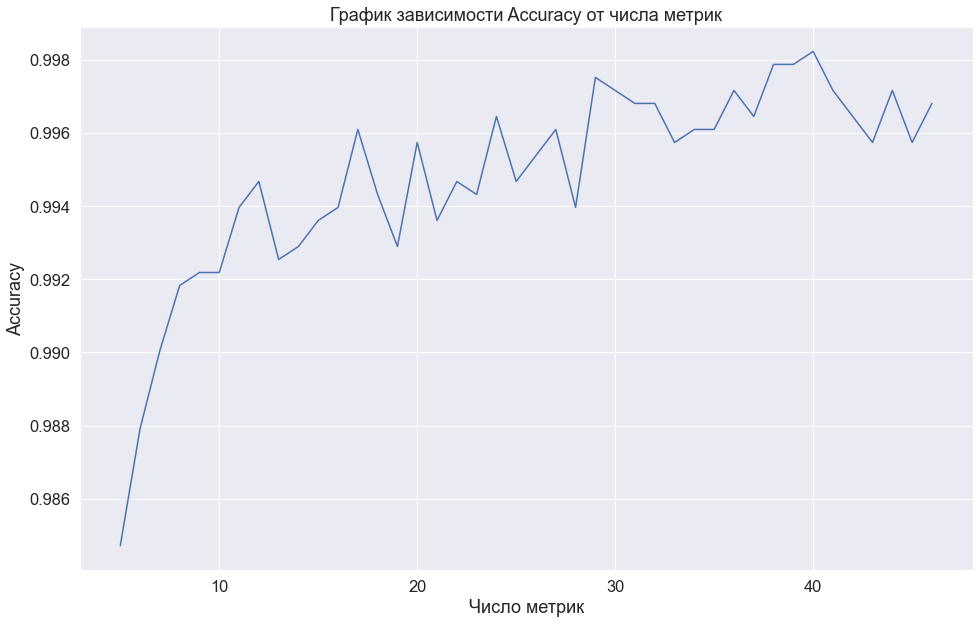

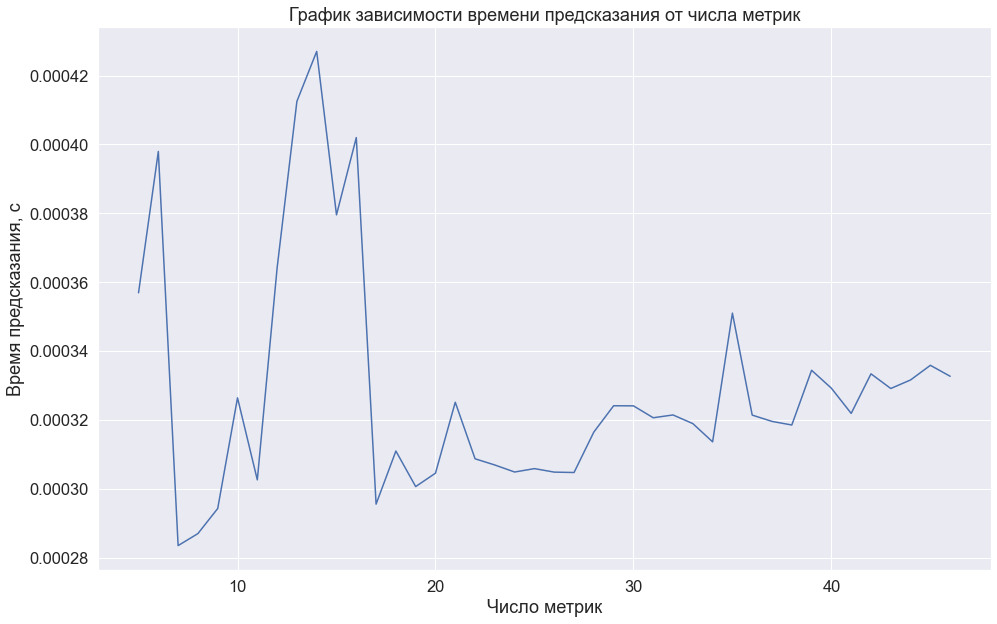

In [66]:
plot_acc_and_time(history, sorted_metrics)

### Определение осанки для сидячего положения

In [67]:
data = pd.read_csv('../datasets/added_pos1_metrics_windowed.csv', index_col=[0, 1])
data = data.reset_index(drop=True)
data = data[data['position'] == 1].drop(['position', 'age'], axis=1)
data.head()

,x_mean,x_std,x_max,x_min,x_energy,x_iqr,y_mean,y_std,y_max,y_min,...,x_iqr_pos1,y_iqr_pos1,z_iqr_pos1,xy_corr_pos1,xz_corr_pos1,yz_corr_pos1,height,mass,is_valid,sex
0,11156.76,123.532772,11380.0,10836.0,1.244884e+08,177.0,1158.80,73.172275,1348.0,920.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1
1,11156.88,128.858961,11380.0,10836.0,1.244924e+08,193.0,1137.96,69.416023,1300.0,920.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1
2,11154.36,134.410311,11532.0,10836.0,1.244376e+08,190.0,1088.32,171.829072,1380.0,164.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1
3,10998.28,415.506022,11532.0,9384.0,1.211331e+08,323.0,853.36,499.190851,1380.0,-1032.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1
4,10883.04,409.575930,11532.0,9384.0,1.186066e+08,543.0,537.68,622.192456,1380.0,-1032.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1


In [68]:
y = data['is_valid']
X = data.drop('is_valid', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=1234
)

history = defaultdict(list)

params_grid = {
            'n_estimators': [200, 300, 500],
            'max_depth' : np.arange(3, 6),
            'learning_rate': np.linspace(0.5, 0.6, 8)
        }

In [69]:
for i in tqdm(range(5, len(sorted_metrics))):
    metrics = sorted_metrics[:i]
    X_train_cut = X_train[metrics]
    X_test_cut = X_test[metrics]
    
    model = getBestModelCB(X_train_cut, X_test_cut, y_train, y_test,
                        params_grid=params_grid)
    
    X_test_cut = X_test_cut.to_numpy()
    time_predict = min(timeit.Timer('model.predict(X_test_cut[0])', globals=globals()).repeat(repeat=100, number=1))
    history['time_predict'].append(time_predict)
    
    y_pred = model.predict(X_test_cut)
    accuracy = accuracy_score(y_test, y_pred)
    history['accuracy'].append(accuracy)

  0%|          | 0/42 [00:00<?, ?it/s]

0:	learn: 0.3352282	test: 0.3358272	best: 0.3358272 (0)	total: 3.23ms	remaining: 1.61s
100:	learn: 0.0044068	test: 0.0354903	best: 0.0354903 (100)	total: 108ms	remaining: 426ms
200:	learn: 0.0044031	test: 0.0354963	best: 0.0354903 (100)	total: 179ms	remaining: 267ms
300:	learn: 0.0044023	test: 0.0354985	best: 0.0354903 (100)	total: 284ms	remaining: 187ms
400:	learn: 0.0041903	test: 0.0356405	best: 0.0354903 (100)	total: 355ms	remaining: 87.7ms
499:	learn: 0.0039297	test: 0.0346779	best: 0.0346779 (499)	total: 427ms	remaining: 0us

bestTest = 0.03467793552
bestIteration = 499



  2%|▏         | 1/42 [00:40<27:34, 40.36s/it]

0:	learn: 0.2898182	test: 0.2931295	best: 0.2931295 (0)	total: 1.11ms	remaining: 555ms
100:	learn: 0.0018983	test: 0.0103785	best: 0.0103785 (100)	total: 87.7ms	remaining: 347ms
200:	learn: 0.0018983	test: 0.0103785	best: 0.0103785 (200)	total: 170ms	remaining: 253ms
300:	learn: 0.0018032	test: 0.0103455	best: 0.0103455 (300)	total: 297ms	remaining: 196ms
400:	learn: 0.0017614	test: 0.0102521	best: 0.0102521 (400)	total: 389ms	remaining: 96.1ms
499:	learn: 0.0015294	test: 0.0100920	best: 0.0100920 (499)	total: 479ms	remaining: 0us

bestTest = 0.01009197826
bestIteration = 499



  5%|▍         | 2/42 [01:20<26:39, 39.98s/it]

0:	learn: 0.2171147	test: 0.2204941	best: 0.2204941 (0)	total: 1.17ms	remaining: 584ms
100:	learn: 0.0019085	test: 0.0118771	best: 0.0118771 (100)	total: 89.2ms	remaining: 352ms
200:	learn: 0.0018030	test: 0.0116900	best: 0.0116900 (200)	total: 173ms	remaining: 258ms
300:	learn: 0.0016049	test: 0.0109808	best: 0.0109808 (300)	total: 290ms	remaining: 192ms
400:	learn: 0.0014819	test: 0.0105800	best: 0.0105800 (400)	total: 384ms	remaining: 94.9ms
499:	learn: 0.0014339	test: 0.0104677	best: 0.0104677 (499)	total: 476ms	remaining: 0us

bestTest = 0.01046766155
bestIteration = 499



  7%|▋         | 3/42 [02:02<26:43, 41.12s/it]

0:	learn: 0.1928364	test: 0.2033718	best: 0.2033718 (0)	total: 1.14ms	remaining: 567ms
100:	learn: 0.0025523	test: 0.0113558	best: 0.0113558 (100)	total: 86.4ms	remaining: 341ms
200:	learn: 0.0020672	test: 0.0108279	best: 0.0108279 (200)	total: 170ms	remaining: 253ms
300:	learn: 0.0020604	test: 0.0108379	best: 0.0108279 (200)	total: 288ms	remaining: 190ms
400:	learn: 0.0020562	test: 0.0108443	best: 0.0108279 (200)	total: 381ms	remaining: 94ms
499:	learn: 0.0018400	test: 0.0101624	best: 0.0101624 (499)	total: 472ms	remaining: 0us

bestTest = 0.01016244039
bestIteration = 499



 10%|▉         | 4/42 [02:43<25:55, 40.95s/it]

0:	learn: 0.2647245	test: 0.2640879	best: 0.2640879 (0)	total: 1.01ms	remaining: 507ms
100:	learn: 0.0018478	test: 0.0065760	best: 0.0065760 (100)	total: 76.4ms	remaining: 302ms
200:	learn: 0.0016972	test: 0.0066489	best: 0.0065760 (100)	total: 149ms	remaining: 222ms
300:	learn: 0.0016969	test: 0.0066492	best: 0.0065760 (100)	total: 250ms	remaining: 165ms
400:	learn: 0.0016969	test: 0.0066492	best: 0.0065760 (100)	total: 326ms	remaining: 80.6ms
499:	learn: 0.0015612	test: 0.0064143	best: 0.0064143 (499)	total: 397ms	remaining: 0us

bestTest = 0.00641431749
bestIteration = 499



 12%|█▏        | 5/42 [03:23<25:05, 40.69s/it]

0:	learn: 0.3134571	test: 0.3179161	best: 0.3179161 (0)	total: 937us	remaining: 468ms
100:	learn: 0.0020691	test: 0.0064271	best: 0.0064271 (100)	total: 70.6ms	remaining: 279ms
200:	learn: 0.0018609	test: 0.0061867	best: 0.0061867 (200)	total: 136ms	remaining: 202ms
300:	learn: 0.0017621	test: 0.0061022	best: 0.0061022 (300)	total: 206ms	remaining: 136ms
400:	learn: 0.0017288	test: 0.0060486	best: 0.0060486 (400)	total: 303ms	remaining: 74.8ms
499:	learn: 0.0017246	test: 0.0060502	best: 0.0060486 (400)	total: 368ms	remaining: 0us

bestTest = 0.006048638516
bestIteration = 400

Shrink model to first 401 iterations.


 14%|█▍        | 6/42 [04:04<24:29, 40.82s/it]

0:	learn: 0.2853988	test: 0.2880350	best: 0.2880350 (0)	total: 1.04ms	remaining: 518ms
100:	learn: 0.0024892	test: 0.0114587	best: 0.0114587 (100)	total: 82.8ms	remaining: 327ms
200:	learn: 0.0024888	test: 0.0114597	best: 0.0114587 (100)	total: 163ms	remaining: 242ms
300:	learn: 0.0024883	test: 0.0114612	best: 0.0114587 (100)	total: 277ms	remaining: 183ms
400:	learn: 0.0024837	test: 0.0114758	best: 0.0114587 (100)	total: 376ms	remaining: 92.8ms
499:	learn: 0.0021416	test: 0.0109454	best: 0.0109454 (499)	total: 450ms	remaining: 0us

bestTest = 0.01094537607
bestIteration = 499



 17%|█▋        | 7/42 [04:46<23:57, 41.06s/it]

0:	learn: 0.3099739	test: 0.3023649	best: 0.3023649 (0)	total: 4.07ms	remaining: 2.03s
100:	learn: 0.0024431	test: 0.0093344	best: 0.0093344 (100)	total: 154ms	remaining: 607ms
200:	learn: 0.0024308	test: 0.0093695	best: 0.0093344 (100)	total: 242ms	remaining: 360ms
300:	learn: 0.0024189	test: 0.0093776	best: 0.0093344 (100)	total: 322ms	remaining: 213ms
400:	learn: 0.0024051	test: 0.0093910	best: 0.0093344 (100)	total: 388ms	remaining: 95.9ms


 19%|█▉        | 8/42 [05:26<23:12, 40.95s/it]

499:	learn: 0.0017436	test: 0.0083063	best: 0.0083063 (499)	total: 475ms	remaining: 0us

bestTest = 0.008306307172
bestIteration = 499

0:	learn: 0.2796372	test: 0.2601729	best: 0.2601729 (0)	total: 1.13ms	remaining: 337ms
100:	learn: 0.0016713	test: 0.0154275	best: 0.0154275 (100)	total: 91.2ms	remaining: 180ms
200:	learn: 0.0015711	test: 0.0153499	best: 0.0153499 (200)	total: 181ms	remaining: 89.1ms


 21%|██▏       | 9/42 [06:00<21:21, 38.83s/it]

299:	learn: 0.0014487	test: 0.0154263	best: 0.0153499 (200)	total: 309ms	remaining: 0us

bestTest = 0.01534992533
bestIteration = 200

Shrink model to first 201 iterations.
0:	learn: 0.2343570	test: 0.2360453	best: 0.2360453 (0)	total: 1.26ms	remaining: 630ms
100:	learn: 0.0012412	test: 0.0054595	best: 0.0054595 (100)	total: 108ms	remaining: 425ms
200:	learn: 0.0012375	test: 0.0054821	best: 0.0054595 (100)	total: 216ms	remaining: 322ms
300:	learn: 0.0012342	test: 0.0054995	best: 0.0054595 (100)	total: 319ms	remaining: 211ms
400:	learn: 0.0012280	test: 0.0055197	best: 0.0054595 (100)	total: 431ms	remaining: 107ms
499:	learn: 0.0011706	test: 0.0055203	best: 0.0054595 (100)	total: 536ms	remaining: 0us

bestTest = 0.005459548619
bestIteration = 100

Shrink model to first 101 iterations.


 24%|██▍       | 10/42 [06:45<21:42, 40.69s/it]

0:	learn: 0.2965265	test: 0.2939872	best: 0.2939872 (0)	total: 1.09ms	remaining: 546ms
100:	learn: 0.0025877	test: 0.0084589	best: 0.0084589 (100)	total: 83.7ms	remaining: 331ms
200:	learn: 0.0025875	test: 0.0084592	best: 0.0084589 (100)	total: 163ms	remaining: 243ms
300:	learn: 0.0025845	test: 0.0084647	best: 0.0084589 (100)	total: 262ms	remaining: 173ms
400:	learn: 0.0025808	test: 0.0084717	best: 0.0084589 (100)	total: 424ms	remaining: 105ms


 26%|██▌       | 11/42 [07:29<21:27, 41.53s/it]

499:	learn: 0.0019670	test: 0.0078933	best: 0.0078933 (499)	total: 516ms	remaining: 0us

bestTest = 0.00789333506
bestIteration = 499

0:	learn: 0.2556166	test: 0.2469628	best: 0.2469628 (0)	total: 1.36ms	remaining: 681ms
100:	learn: 0.0013933	test: 0.0101211	best: 0.0101211 (100)	total: 114ms	remaining: 451ms
200:	learn: 0.0013838	test: 0.0101393	best: 0.0101211 (100)	total: 231ms	remaining: 344ms
300:	learn: 0.0013748	test: 0.0101446	best: 0.0101211 (100)	total: 342ms	remaining: 226ms


 29%|██▊       | 12/42 [08:16<21:39, 43.33s/it]

400:	learn: 0.0013677	test: 0.0101411	best: 0.0101211 (100)	total: 459ms	remaining: 113ms
499:	learn: 0.0012428	test: 0.0098543	best: 0.0098543 (499)	total: 562ms	remaining: 0us

bestTest = 0.009854318102
bestIteration = 499

0:	learn: 0.2816824	test: 0.2671392	best: 0.2671392 (0)	total: 3.72ms	remaining: 1.86s
100:	learn: 0.0019493	test: 0.0105598	best: 0.0105598 (100)	total: 144ms	remaining: 568ms
200:	learn: 0.0019472	test: 0.0105593	best: 0.0105593 (200)	total: 243ms	remaining: 361ms
300:	learn: 0.0019439	test: 0.0105575	best: 0.0105575 (300)	total: 332ms	remaining: 220ms
400:	learn: 0.0019419	test: 0.0105571	best: 0.0105571 (400)	total: 418ms	remaining: 103ms


 31%|███       | 13/42 [09:02<21:20, 44.15s/it]

499:	learn: 0.0019394	test: 0.0105558	best: 0.0105558 (499)	total: 509ms	remaining: 0us

bestTest = 0.010555795
bestIteration = 499

0:	learn: 0.2343314	test: 0.2403858	best: 0.2403858 (0)	total: 1.34ms	remaining: 668ms
100:	learn: 0.0014128	test: 0.0100384	best: 0.0100384 (100)	total: 109ms	remaining: 429ms
200:	learn: 0.0013934	test: 0.0099919	best: 0.0099919 (200)	total: 217ms	remaining: 323ms
300:	learn: 0.0013348	test: 0.0099933	best: 0.0099919 (200)	total: 326ms	remaining: 215ms


 33%|███▎      | 14/42 [09:50<21:04, 45.16s/it]

400:	learn: 0.0013259	test: 0.0099705	best: 0.0099705 (400)	total: 446ms	remaining: 110ms
499:	learn: 0.0012706	test: 0.0101632	best: 0.0099705 (400)	total: 557ms	remaining: 0us

bestTest = 0.009970481165
bestIteration = 400

Shrink model to first 401 iterations.
0:	learn: 0.2563314	test: 0.2664934	best: 0.2664934 (0)	total: 1.35ms	remaining: 674ms
100:	learn: 0.0013772	test: 0.0086889	best: 0.0086889 (100)	total: 116ms	remaining: 459ms
200:	learn: 0.0011197	test: 0.0077056	best: 0.0077056 (200)	total: 236ms	remaining: 351ms
300:	learn: 0.0011128	test: 0.0077066	best: 0.0077056 (200)	total: 350ms	remaining: 231ms
400:	learn: 0.0010767	test: 0.0076776	best: 0.0076776 (400)	total: 471ms	remaining: 116ms
499:	learn: 0.0010711	test: 0.0076829	best: 0.0076776 (400)	total: 584ms	remaining: 0us

bestTest = 0.007677581882
bestIteration = 400

Shrink model to first 401 iterations.


 36%|███▌      | 15/42 [10:37<20:37, 45.85s/it]

0:	learn: 0.3305560	test: 0.3444615	best: 0.3444615 (0)	total: 1.04ms	remaining: 520ms
100:	learn: 0.0020680	test: 0.0113517	best: 0.0113517 (100)	total: 79.8ms	remaining: 315ms
200:	learn: 0.0013647	test: 0.0108817	best: 0.0108817 (200)	total: 154ms	remaining: 229ms
300:	learn: 0.0013646	test: 0.0108817	best: 0.0108817 (300)	total: 232ms	remaining: 153ms
400:	learn: 0.0013499	test: 0.0108618	best: 0.0108618 (400)	total: 310ms	remaining: 76.5ms
499:	learn: 0.0013286	test: 0.0108361	best: 0.0108361 (499)	total: 387ms	remaining: 0us

bestTest = 0.01083610936
bestIteration = 499



 38%|███▊      | 16/42 [11:23<19:48, 45.69s/it]

0:	learn: 0.2761861	test: 0.2551569	best: 0.2551569 (0)	total: 1.27ms	remaining: 634ms
100:	learn: 0.0012840	test: 0.0070790	best: 0.0070790 (100)	total: 94ms	remaining: 372ms
200:	learn: 0.0010890	test: 0.0070617	best: 0.0070617 (200)	total: 184ms	remaining: 273ms
300:	learn: 0.0010826	test: 0.0070383	best: 0.0070383 (300)	total: 278ms	remaining: 183ms
400:	learn: 0.0010456	test: 0.0068358	best: 0.0068358 (400)	total: 367ms	remaining: 90.5ms
499:	learn: 0.0010361	test: 0.0068329	best: 0.0068329 (499)	total: 456ms	remaining: 0us

bestTest = 0.006832942519
bestIteration = 499



 40%|████      | 17/42 [12:09<19:10, 46.00s/it]

0:	learn: 0.2213132	test: 0.2345107	best: 0.2345107 (0)	total: 5.62ms	remaining: 2.81s
100:	learn: 0.0011491	test: 0.0110816	best: 0.0110816 (100)	total: 154ms	remaining: 608ms
200:	learn: 0.0011465	test: 0.0110669	best: 0.0110669 (200)	total: 275ms	remaining: 409ms
300:	learn: 0.0011366	test: 0.0110108	best: 0.0110108 (300)	total: 393ms	remaining: 260ms
400:	learn: 0.0011280	test: 0.0109662	best: 0.0109662 (400)	total: 520ms	remaining: 128ms
499:	learn: 0.0010596	test: 0.0107391	best: 0.0107391 (499)	total: 638ms	remaining: 0us

bestTest = 0.01073906903
bestIteration = 499



 43%|████▎     | 18/42 [12:58<18:41, 46.72s/it]

0:	learn: 0.2660664	test: 0.2734224	best: 0.2734224 (0)	total: 1.2ms	remaining: 598ms
100:	learn: 0.0012627	test: 0.0067902	best: 0.0067902 (100)	total: 93.6ms	remaining: 370ms
200:	learn: 0.0012565	test: 0.0068100	best: 0.0067902 (100)	total: 183ms	remaining: 272ms
300:	learn: 0.0012505	test: 0.0068265	best: 0.0067902 (100)	total: 279ms	remaining: 185ms
400:	learn: 0.0012444	test: 0.0068273	best: 0.0067902 (100)	total: 370ms	remaining: 91.3ms
499:	learn: 0.0012387	test: 0.0068271	best: 0.0067902 (100)	total: 459ms	remaining: 0us

bestTest = 0.006790222543
bestIteration = 100

Shrink model to first 101 iterations.


 45%|████▌     | 19/42 [13:45<17:56, 46.80s/it]

0:	learn: 0.2405972	test: 0.2478489	best: 0.2478489 (0)	total: 1.28ms	remaining: 638ms
100:	learn: 0.0014085	test: 0.0157706	best: 0.0157706 (100)	total: 100ms	remaining: 396ms
200:	learn: 0.0012029	test: 0.0152750	best: 0.0152750 (200)	total: 198ms	remaining: 295ms
300:	learn: 0.0011940	test: 0.0151574	best: 0.0151574 (300)	total: 303ms	remaining: 200ms


 48%|████▊     | 20/42 [14:32<17:13, 46.96s/it]

400:	learn: 0.0011896	test: 0.0150970	best: 0.0150970 (400)	total: 405ms	remaining: 100ms
499:	learn: 0.0011781	test: 0.0149379	best: 0.0149379 (499)	total: 495ms	remaining: 0us

bestTest = 0.01493792776
bestIteration = 499

0:	learn: 0.2144759	test: 0.2290939	best: 0.2290939 (0)	total: 1.4ms	remaining: 699ms
100:	learn: 0.0013330	test: 0.0090681	best: 0.0090681 (100)	total: 113ms	remaining: 447ms
200:	learn: 0.0013011	test: 0.0091012	best: 0.0090681 (100)	total: 231ms	remaining: 344ms
300:	learn: 0.0012532	test: 0.0090545	best: 0.0090545 (300)	total: 367ms	remaining: 243ms
400:	learn: 0.0012392	test: 0.0090305	best: 0.0090305 (400)	total: 489ms	remaining: 121ms
499:	learn: 0.0012233	test: 0.0089994	best: 0.0089994 (499)	total: 600ms	remaining: 0us

bestTest = 0.008999428244
bestIteration = 499



 50%|█████     | 21/42 [15:21<16:38, 47.54s/it]

0:	learn: 0.3693783	test: 0.3731928	best: 0.3731928 (0)	total: 3.91ms	remaining: 1.95s
100:	learn: 0.0019436	test: 0.0134411	best: 0.0134411 (100)	total: 164ms	remaining: 646ms
200:	learn: 0.0018479	test: 0.0133075	best: 0.0133075 (200)	total: 263ms	remaining: 392ms
300:	learn: 0.0016428	test: 0.0131589	best: 0.0131589 (300)	total: 361ms	remaining: 238ms
400:	learn: 0.0016416	test: 0.0131556	best: 0.0131556 (400)	total: 460ms	remaining: 114ms
499:	learn: 0.0016416	test: 0.0131556	best: 0.0131556 (400)	total: 560ms	remaining: 0us

bestTest = 0.01315563413
bestIteration = 400

Shrink model to first 401 iterations.


 52%|█████▏    | 22/42 [16:07<15:40, 47.02s/it]

0:	learn: 0.2271916	test: 0.2334651	best: 0.2334651 (0)	total: 1.38ms	remaining: 690ms
100:	learn: 0.0008468	test: 0.0109919	best: 0.0109919 (100)	total: 114ms	remaining: 452ms
200:	learn: 0.0008097	test: 0.0107809	best: 0.0107809 (200)	total: 233ms	remaining: 347ms
300:	learn: 0.0008053	test: 0.0107854	best: 0.0107809 (200)	total: 345ms	remaining: 228ms
400:	learn: 0.0008002	test: 0.0107852	best: 0.0107809 (200)	total: 463ms	remaining: 114ms
499:	learn: 0.0007961	test: 0.0107891	best: 0.0107809 (200)	total: 577ms	remaining: 0us

bestTest = 0.01078090983
bestIteration = 200

Shrink model to first 201 iterations.


 55%|█████▍    | 23/42 [16:54<14:57, 47.25s/it]

0:	learn: 0.2053247	test: 0.2206141	best: 0.2206141 (0)	total: 1.43ms	remaining: 713ms
100:	learn: 0.0019964	test: 0.0137567	best: 0.0137567 (100)	total: 122ms	remaining: 481ms
200:	learn: 0.0019964	test: 0.0137567	best: 0.0137567 (100)	total: 250ms	remaining: 372ms
300:	learn: 0.0019964	test: 0.0137567	best: 0.0137567 (100)	total: 373ms	remaining: 247ms
400:	learn: 0.0019964	test: 0.0137567	best: 0.0137567 (100)	total: 503ms	remaining: 124ms
499:	learn: 0.0019937	test: 0.0137547	best: 0.0137547 (499)	total: 626ms	remaining: 0us

bestTest = 0.01375473325
bestIteration = 499



 57%|█████▋    | 24/42 [17:42<14:12, 47.38s/it]

0:	learn: 0.2727597	test: 0.2811186	best: 0.2811186 (0)	total: 1.28ms	remaining: 638ms
100:	learn: 0.0013930	test: 0.0059409	best: 0.0059409 (100)	total: 102ms	remaining: 404ms
200:	learn: 0.0013786	test: 0.0059346	best: 0.0059346 (200)	total: 199ms	remaining: 296ms
300:	learn: 0.0013767	test: 0.0059309	best: 0.0059309 (300)	total: 302ms	remaining: 200ms
400:	learn: 0.0013708	test: 0.0059207	best: 0.0059207 (400)	total: 405ms	remaining: 99.9ms
499:	learn: 0.0013596	test: 0.0059172	best: 0.0059172 (499)	total: 511ms	remaining: 0us

bestTest = 0.005917237044
bestIteration = 499



 60%|█████▉    | 25/42 [18:31<13:35, 47.97s/it]

0:	learn: 0.2624874	test: 0.2698240	best: 0.2698240 (0)	total: 2.46ms	remaining: 1.23s
100:	learn: 0.0013068	test: 0.0095129	best: 0.0095129 (100)	total: 134ms	remaining: 529ms
200:	learn: 0.0012324	test: 0.0093077	best: 0.0093077 (200)	total: 237ms	remaining: 353ms
300:	learn: 0.0012283	test: 0.0092962	best: 0.0092962 (300)	total: 335ms	remaining: 222ms
400:	learn: 0.0012235	test: 0.0092810	best: 0.0092810 (400)	total: 434ms	remaining: 107ms


 62%|██████▏   | 26/42 [19:21<12:56, 48.56s/it]

499:	learn: 0.0012188	test: 0.0092675	best: 0.0092675 (499)	total: 536ms	remaining: 0us

bestTest = 0.00926750945
bestIteration = 499

0:	learn: 0.2507540	test: 0.2579576	best: 0.2579576 (0)	total: 1.72ms	remaining: 858ms
100:	learn: 0.0010043	test: 0.0140479	best: 0.0140479 (100)	total: 129ms	remaining: 511ms
200:	learn: 0.0009970	test: 0.0139863	best: 0.0139863 (200)	total: 259ms	remaining: 386ms
300:	learn: 0.0009888	test: 0.0139156	best: 0.0139156 (300)	total: 386ms	remaining: 255ms
400:	learn: 0.0009816	test: 0.0138571	best: 0.0138571 (400)	total: 518ms	remaining: 128ms
499:	learn: 0.0009751	test: 0.0138043	best: 0.0138043 (499)	total: 642ms	remaining: 0us

bestTest = 0.01380427764
bestIteration = 499



 64%|██████▍   | 27/42 [20:13<12:22, 49.52s/it]

0:	learn: 0.2551444	test: 0.2722718	best: 0.2722718 (0)	total: 2.63ms	remaining: 1.31s
100:	learn: 0.0013039	test: 0.0143313	best: 0.0143313 (100)	total: 144ms	remaining: 568ms
200:	learn: 0.0012395	test: 0.0142463	best: 0.0142463 (200)	total: 280ms	remaining: 417ms
300:	learn: 0.0010817	test: 0.0146393	best: 0.0142463 (200)	total: 414ms	remaining: 274ms
400:	learn: 0.0010578	test: 0.0147948	best: 0.0142463 (200)	total: 551ms	remaining: 136ms
499:	learn: 0.0010507	test: 0.0147891	best: 0.0142463 (200)	total: 683ms	remaining: 0us

bestTest = 0.01424625651
bestIteration = 200

Shrink model to first 201 iterations.


 67%|██████▋   | 28/42 [21:05<11:43, 50.25s/it]

0:	learn: 0.2700103	test: 0.2798478	best: 0.2798478 (0)	total: 1.27ms	remaining: 633ms
100:	learn: 0.0014113	test: 0.0136738	best: 0.0136738 (100)	total: 108ms	remaining: 428ms
200:	learn: 0.0013148	test: 0.0134103	best: 0.0134103 (200)	total: 223ms	remaining: 331ms
300:	learn: 0.0013010	test: 0.0134255	best: 0.0134103 (200)	total: 328ms	remaining: 217ms


 69%|██████▉   | 29/42 [21:55<10:50, 50.02s/it]

400:	learn: 0.0012965	test: 0.0134441	best: 0.0134103 (200)	total: 446ms	remaining: 110ms
499:	learn: 0.0012908	test: 0.0134636	best: 0.0134103 (200)	total: 551ms	remaining: 0us

bestTest = 0.01341031439
bestIteration = 200

Shrink model to first 201 iterations.
0:	learn: 0.2466276	test: 0.2579509	best: 0.2579509 (0)	total: 1.32ms	remaining: 659ms
100:	learn: 0.0016539	test: 0.0165043	best: 0.0165043 (100)	total: 103ms	remaining: 407ms
200:	learn: 0.0014511	test: 0.0152718	best: 0.0152718 (200)	total: 206ms	remaining: 307ms
300:	learn: 0.0013995	test: 0.0151509	best: 0.0151509 (300)	total: 308ms	remaining: 204ms
400:	learn: 0.0012326	test: 0.0140835	best: 0.0140835 (400)	total: 417ms	remaining: 103ms
499:	learn: 0.0012243	test: 0.0140811	best: 0.0140811 (499)	total: 516ms	remaining: 0us

bestTest = 0.01408108879
bestIteration = 499



 71%|███████▏  | 30/42 [22:45<09:59, 49.99s/it]

0:	learn: 0.2941796	test: 0.2953815	best: 0.2953815 (0)	total: 3.37ms	remaining: 1.68s
100:	learn: 0.0016474	test: 0.0139908	best: 0.0139908 (100)	total: 108ms	remaining: 427ms
200:	learn: 0.0016443	test: 0.0139738	best: 0.0139738 (200)	total: 197ms	remaining: 293ms
300:	learn: 0.0016423	test: 0.0139653	best: 0.0139653 (300)	total: 291ms	remaining: 192ms
400:	learn: 0.0016387	test: 0.0139482	best: 0.0139482 (400)	total: 378ms	remaining: 93.4ms
499:	learn: 0.0016352	test: 0.0139317	best: 0.0139317 (499)	total: 463ms	remaining: 0us

bestTest = 0.01393171557
bestIteration = 499



 74%|███████▍  | 31/42 [23:35<09:10, 50.01s/it]

0:	learn: 0.2581535	test: 0.2651425	best: 0.2651425 (0)	total: 3.25ms	remaining: 1.62s
100:	learn: 0.0011573	test: 0.0117248	best: 0.0117248 (100)	total: 165ms	remaining: 654ms
200:	learn: 0.0011512	test: 0.0117194	best: 0.0117194 (200)	total: 279ms	remaining: 414ms
300:	learn: 0.0011473	test: 0.0117187	best: 0.0117187 (300)	total: 382ms	remaining: 252ms
400:	learn: 0.0011396	test: 0.0117246	best: 0.0117187 (300)	total: 492ms	remaining: 122ms
499:	learn: 0.0011310	test: 0.0116960	best: 0.0116960 (499)	total: 607ms	remaining: 0us

bestTest = 0.01169601176
bestIteration = 499



 76%|███████▌  | 32/42 [24:27<08:27, 50.78s/it]

0:	learn: 0.2507149	test: 0.2634057	best: 0.2634057 (0)	total: 1.61ms	remaining: 805ms
100:	learn: 0.0023085	test: 0.0087823	best: 0.0087823 (100)	total: 148ms	remaining: 583ms
200:	learn: 0.0022960	test: 0.0088013	best: 0.0087823 (100)	total: 297ms	remaining: 442ms
300:	learn: 0.0022846	test: 0.0088160	best: 0.0087823 (100)	total: 441ms	remaining: 291ms
400:	learn: 0.0022181	test: 0.0086729	best: 0.0086729 (400)	total: 593ms	remaining: 146ms
499:	learn: 0.0012427	test: 0.0065684	best: 0.0065684 (499)	total: 739ms	remaining: 0us

bestTest = 0.006568364678
bestIteration = 499



 79%|███████▊  | 33/42 [25:21<07:46, 51.83s/it]

0:	learn: 0.3135905	test: 0.3070945	best: 0.3070945 (0)	total: 1.35ms	remaining: 674ms
100:	learn: 0.0014114	test: 0.0095262	best: 0.0095262 (100)	total: 110ms	remaining: 434ms
200:	learn: 0.0013276	test: 0.0091127	best: 0.0091127 (200)	total: 225ms	remaining: 334ms
300:	learn: 0.0011332	test: 0.0089592	best: 0.0089592 (300)	total: 333ms	remaining: 220ms


 81%|████████  | 34/42 [26:13<06:53, 51.64s/it]

400:	learn: 0.0011254	test: 0.0089961	best: 0.0089592 (300)	total: 447ms	remaining: 110ms
499:	learn: 0.0010404	test: 0.0088477	best: 0.0088477 (499)	total: 557ms	remaining: 0us

bestTest = 0.00884772948
bestIteration = 499

0:	learn: 0.2316353	test: 0.2492742	best: 0.2492742 (0)	total: 4.1ms	remaining: 2.05s
100:	learn: 0.0011616	test: 0.0119263	best: 0.0119263 (100)	total: 134ms	remaining: 529ms
200:	learn: 0.0011320	test: 0.0119099	best: 0.0119099 (200)	total: 254ms	remaining: 378ms
300:	learn: 0.0011221	test: 0.0118823	best: 0.0118823 (300)	total: 361ms	remaining: 239ms
400:	learn: 0.0011140	test: 0.0118586	best: 0.0118586 (400)	total: 478ms	remaining: 118ms
499:	learn: 0.0011038	test: 0.0118203	best: 0.0118203 (499)	total: 606ms	remaining: 0us

bestTest = 0.01182031318
bestIteration = 499



 83%|████████▎ | 35/42 [27:06<06:04, 52.04s/it]

0:	learn: 0.2432066	test: 0.2395146	best: 0.2395146 (0)	total: 1.63ms	remaining: 816ms
100:	learn: 0.0014061	test: 0.0106395	best: 0.0106395 (100)	total: 146ms	remaining: 576ms
200:	learn: 0.0010966	test: 0.0102039	best: 0.0102039 (200)	total: 294ms	remaining: 437ms
300:	learn: 0.0010317	test: 0.0105556	best: 0.0102039 (200)	total: 436ms	remaining: 288ms
400:	learn: 0.0010232	test: 0.0105488	best: 0.0102039 (200)	total: 585ms	remaining: 145ms
499:	learn: 0.0010169	test: 0.0105306	best: 0.0102039 (200)	total: 727ms	remaining: 0us

bestTest = 0.01020394996
bestIteration = 200

Shrink model to first 201 iterations.


 86%|████████▌ | 36/42 [28:00<05:16, 52.73s/it]

0:	learn: 0.2861508	test: 0.2768746	best: 0.2768746 (0)	total: 1.36ms	remaining: 679ms
100:	learn: 0.0013202	test: 0.0132388	best: 0.0132388 (100)	total: 111ms	remaining: 440ms
200:	learn: 0.0012434	test: 0.0133670	best: 0.0132388 (100)	total: 226ms	remaining: 336ms
300:	learn: 0.0012380	test: 0.0133583	best: 0.0132388 (100)	total: 341ms	remaining: 225ms


 88%|████████▊ | 37/42 [28:52<04:23, 52.62s/it]

400:	learn: 0.0012313	test: 0.0133466	best: 0.0132388 (100)	total: 462ms	remaining: 114ms
499:	learn: 0.0012238	test: 0.0133306	best: 0.0132388 (100)	total: 568ms	remaining: 0us

bestTest = 0.01323875727
bestIteration = 100

Shrink model to first 101 iterations.
0:	learn: 0.1665609	test: 0.1796137	best: 0.1796137 (0)	total: 1.72ms	remaining: 857ms
100:	learn: 0.0014188	test: 0.0111954	best: 0.0111954 (100)	total: 149ms	remaining: 588ms
200:	learn: 0.0012287	test: 0.0109895	best: 0.0109895 (200)	total: 301ms	remaining: 447ms
300:	learn: 0.0012234	test: 0.0109811	best: 0.0109811 (300)	total: 450ms	remaining: 298ms
400:	learn: 0.0012169	test: 0.0109709	best: 0.0109709 (400)	total: 606ms	remaining: 150ms
499:	learn: 0.0012109	test: 0.0109625	best: 0.0109625 (499)	total: 753ms	remaining: 0us

bestTest = 0.01096247939
bestIteration = 499



 90%|█████████ | 38/42 [29:47<03:33, 53.32s/it]

0:	learn: 0.2739133	test: 0.2841369	best: 0.2841369 (0)	total: 1.34ms	remaining: 670ms
100:	learn: 0.0017828	test: 0.0084007	best: 0.0084007 (100)	total: 109ms	remaining: 431ms
200:	learn: 0.0016763	test: 0.0085667	best: 0.0084007 (100)	total: 227ms	remaining: 337ms
300:	learn: 0.0016714	test: 0.0085859	best: 0.0084007 (100)	total: 344ms	remaining: 227ms
400:	learn: 0.0016676	test: 0.0085724	best: 0.0084007 (100)	total: 467ms	remaining: 115ms
499:	learn: 0.0016585	test: 0.0085480	best: 0.0084007 (100)	total: 580ms	remaining: 0us

bestTest = 0.008400735534
bestIteration = 100

Shrink model to first 101 iterations.


 93%|█████████▎| 39/42 [30:40<02:39, 53.13s/it]

0:	learn: 0.3090634	test: 0.3036900	best: 0.3036900 (0)	total: 3.76ms	remaining: 1.88s
100:	learn: 0.0018766	test: 0.0093726	best: 0.0093726 (100)	total: 157ms	remaining: 621ms
200:	learn: 0.0018737	test: 0.0093604	best: 0.0093604 (200)	total: 253ms	remaining: 376ms
300:	learn: 0.0018681	test: 0.0093363	best: 0.0093363 (300)	total: 340ms	remaining: 225ms
400:	learn: 0.0018626	test: 0.0093107	best: 0.0093107 (400)	total: 427ms	remaining: 106ms


 95%|█████████▌| 40/42 [31:31<01:44, 52.41s/it]

499:	learn: 0.0018575	test: 0.0092902	best: 0.0092902 (499)	total: 521ms	remaining: 0us

bestTest = 0.009290172719
bestIteration = 499

0:	learn: 0.2305101	test: 0.2484496	best: 0.2484496 (0)	total: 1.74ms	remaining: 866ms
100:	learn: 0.0011857	test: 0.0089095	best: 0.0089095 (100)	total: 160ms	remaining: 631ms
200:	learn: 0.0011431	test: 0.0088587	best: 0.0088587 (200)	total: 322ms	remaining: 479ms
300:	learn: 0.0011125	test: 0.0089997	best: 0.0088587 (200)	total: 479ms	remaining: 317ms
400:	learn: 0.0011024	test: 0.0090176	best: 0.0088587 (200)	total: 644ms	remaining: 159ms
499:	learn: 0.0010953	test: 0.0090345	best: 0.0088587 (200)	total: 796ms	remaining: 0us

bestTest = 0.008858696439
bestIteration = 200

Shrink model to first 201 iterations.


 98%|█████████▊| 41/42 [32:29<00:54, 54.21s/it]

0:	learn: 0.2924745	test: 0.2880775	best: 0.2880775 (0)	total: 1.43ms	remaining: 711ms
100:	learn: 0.0015469	test: 0.0094223	best: 0.0094223 (100)	total: 117ms	remaining: 462ms
200:	learn: 0.0013230	test: 0.0087619	best: 0.0087619 (200)	total: 240ms	remaining: 357ms
300:	learn: 0.0013194	test: 0.0087714	best: 0.0087619 (200)	total: 362ms	remaining: 239ms
400:	learn: 0.0013180	test: 0.0087929	best: 0.0087619 (200)	total: 485ms	remaining: 120ms
499:	learn: 0.0013139	test: 0.0087961	best: 0.0087619 (200)	total: 598ms	remaining: 0us

bestTest = 0.008761893993
bestIteration = 200

Shrink model to first 201 iterations.


100%|██████████| 42/42 [33:25<00:00, 47.74s/it]


In [70]:
# сохранение истории
with open('history_valid_1.json', 'w') as fp:
    json.dump(history, fp)

In [71]:
# загрузка истории
with open('history_valid_1.json', 'r') as fp:
    history = json.load(fp)

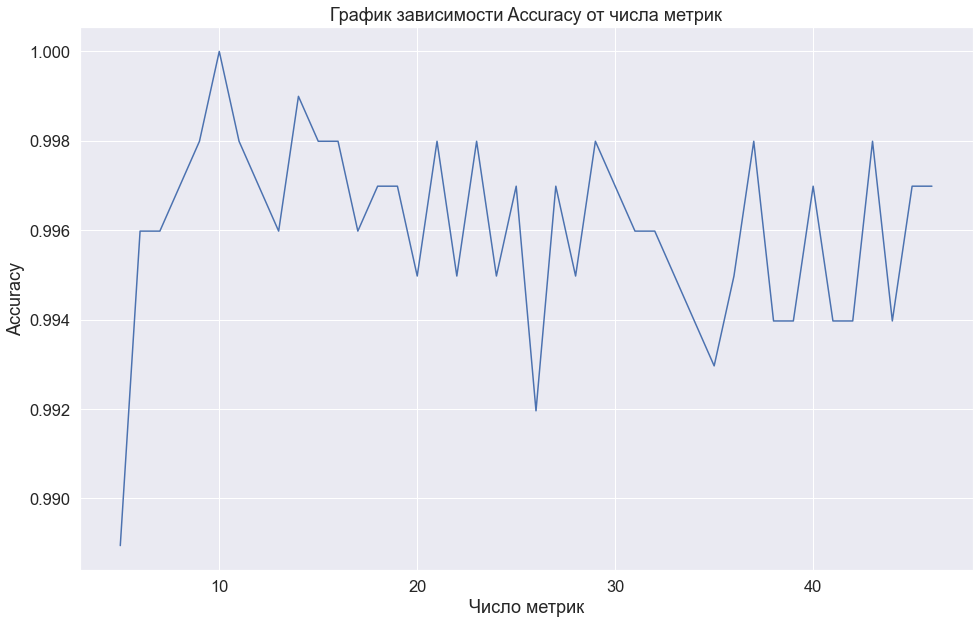

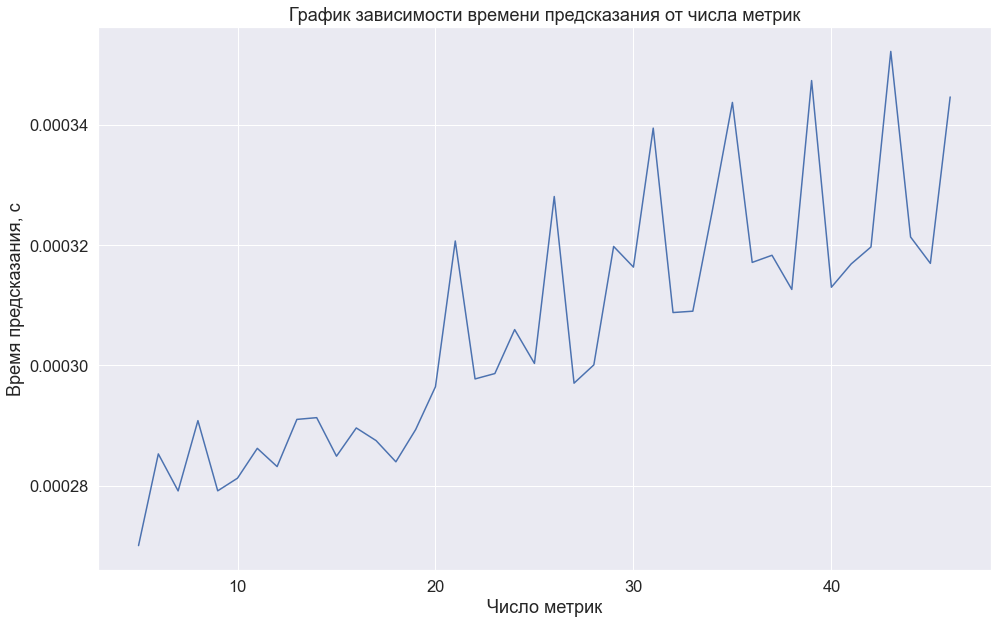

In [72]:
plot_acc_and_time(history, sorted_metrics)

### Определение осанки для стоячего положения

In [73]:
data = pd.read_csv('../'+DATASET_PATH, index_col=[0, 1])
data = data.reset_index(drop=True)
data = data[data['position'] == 2].drop(['position', 'age'], axis=1)
data.head()

,x_mean,x_std,x_max,x_min,x_energy,x_iqr,y_mean,y_std,y_max,y_min,...,x_iqr_pos1,y_iqr_pos1,z_iqr_pos1,xy_corr_pos1,xz_corr_pos1,yz_corr_pos1,height,mass,is_valid,sex
44,12316.28,235.528208,12820.0,11556.0,1.517457e+08,315.0,-61.16,327.249348,960.0,-792.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1
45,12299.04,235.876441,12820.0,11556.0,1.513215e+08,302.0,51.00,352.250772,960.0,-792.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1
46,12331.88,277.328936,13052.0,11556.0,1.521514e+08,343.0,105.52,321.585858,960.0,-744.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1
47,12427.68,283.239945,13052.0,11556.0,1.545267e+08,399.0,46.28,361.610876,960.0,-892.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1
48,12539.80,257.864031,13052.0,11988.0,1.573124e+08,384.0,-1.24,361.704023,696.0,-892.0,...,196.0,132.0,485.0,-0.203383,0.750925,-0.452449,185,75,0,1


In [74]:
y = data['is_valid']
X = data.drop('is_valid', axis=1)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.7, random_state=1234
)

history = defaultdict(list)

params_grid = {
            'n_estimators': [200, 300, 500],
            'max_depth' : np.arange(3, 6),
            'learning_rate': np.linspace(0.5, 0.6, 8)
        }

In [75]:
for i in tqdm(range(5, len(sorted_metrics))):
    metrics = sorted_metrics[:i]
    X_train_cut = X_train[metrics]
    X_test_cut = X_test[metrics]
    
    model = getBestModelCB(X_train_cut, X_test_cut, y_train, y_test,
                        params_grid=params_grid)
    
    X_test_cut = X_test_cut.to_numpy()
    time_predict = min(timeit.Timer('model.predict(X_test_cut[0])', globals=globals()).repeat(repeat=100, number=1))
    history['time_predict'].append(time_predict)
    
    y_pred = model.predict(X_test_cut)
    accuracy = accuracy_score(y_test, y_pred)
    history['accuracy'].append(accuracy)

  0%|          | 0/42 [00:00<?, ?it/s]

0:	learn: 0.3453810	test: 0.3664432	best: 0.3664432 (0)	total: 1.08ms	remaining: 215ms
100:	learn: 0.0033977	test: 0.0435889	best: 0.0435889 (100)	total: 92.9ms	remaining: 91.1ms
199:	learn: 0.0028993	test: 0.0440210	best: 0.0435889 (100)	total: 179ms	remaining: 0us

bestTest = 0.04358892052
bestIteration = 100

Shrink model to first 101 iterations.


  2%|▏         | 1/42 [00:27<18:49, 27.56s/it]

0:	learn: 0.3460896	test: 0.3464070	best: 0.3464070 (0)	total: 1.05ms	remaining: 209ms
100:	learn: 0.0034670	test: 0.0205103	best: 0.0205103 (100)	total: 85.9ms	remaining: 84.2ms
199:	learn: 0.0033448	test: 0.0198822	best: 0.0198822 (199)	total: 164ms	remaining: 0us

bestTest = 0.01988222883
bestIteration = 199



  5%|▍         | 2/42 [00:56<18:46, 28.16s/it]

0:	learn: 0.3667997	test: 0.3730438	best: 0.3730438 (0)	total: 1.08ms	remaining: 540ms
100:	learn: 0.0038854	test: 0.0239442	best: 0.0239442 (100)	total: 86.4ms	remaining: 341ms
200:	learn: 0.0038609	test: 0.0239216	best: 0.0239216 (200)	total: 168ms	remaining: 249ms
300:	learn: 0.0038473	test: 0.0239233	best: 0.0239216 (200)	total: 287ms	remaining: 190ms
400:	learn: 0.0038074	test: 0.0241435	best: 0.0239216 (200)	total: 375ms	remaining: 92.5ms
499:	learn: 0.0038008	test: 0.0241771	best: 0.0239216 (200)	total: 462ms	remaining: 0us

bestTest = 0.02392161764
bestIteration = 200

Shrink model to first 201 iterations.


  7%|▋         | 3/42 [01:35<21:44, 33.45s/it]

0:	learn: 0.4636412	test: 0.4662694	best: 0.4662694 (0)	total: 2.86ms	remaining: 569ms
100:	learn: 0.0050306	test: 0.0140015	best: 0.0140015 (100)	total: 91.3ms	remaining: 89.5ms
199:	learn: 0.0040632	test: 0.0125872	best: 0.0125872 (199)	total: 153ms	remaining: 0us

bestTest = 0.01258724823
bestIteration = 199



 10%|▉         | 4/42 [02:03<19:37, 30.99s/it]

0:	learn: 0.3481548	test: 0.3697956	best: 0.3697956 (0)	total: 1.08ms	remaining: 215ms
100:	learn: 0.0033383	test: 0.0173354	best: 0.0173354 (100)	total: 91.5ms	remaining: 89.7ms
199:	learn: 0.0033335	test: 0.0173192	best: 0.0173192 (199)	total: 182ms	remaining: 0us

bestTest = 0.01731922905
bestIteration = 199



 12%|█▏        | 5/42 [02:30<18:16, 29.65s/it]

0:	learn: 0.4529286	test: 0.4524132	best: 0.4524132 (0)	total: 2.91ms	remaining: 869ms
100:	learn: 0.0043580	test: 0.0116049	best: 0.0116049 (100)	total: 110ms	remaining: 217ms
200:	learn: 0.0042237	test: 0.0114778	best: 0.0114778 (200)	total: 173ms	remaining: 85.2ms


 14%|█▍        | 6/42 [03:02<18:22, 30.62s/it]

299:	learn: 0.0042177	test: 0.0114646	best: 0.0114646 (299)	total: 268ms	remaining: 0us

bestTest = 0.0114645998
bestIteration = 299

0:	learn: 0.4056808	test: 0.4345037	best: 0.4345037 (0)	total: 993us	remaining: 198ms
100:	learn: 0.0027427	test: 0.0095842	best: 0.0095842 (100)	total: 76.8ms	remaining: 75.2ms
199:	learn: 0.0024120	test: 0.0094128	best: 0.0094128 (199)	total: 148ms	remaining: 0us

bestTest = 0.009412792583
bestIteration = 199



 17%|█▋        | 7/42 [03:30<17:21, 29.76s/it]

0:	learn: 0.3948024	test: 0.3924993	best: 0.3924993 (0)	total: 996us	remaining: 198ms
100:	learn: 0.0047556	test: 0.0163448	best: 0.0163448 (100)	total: 82.3ms	remaining: 80.7ms
199:	learn: 0.0036665	test: 0.0147098	best: 0.0147098 (199)	total: 162ms	remaining: 0us

bestTest = 0.0147098084
bestIteration = 199



 19%|█▉        | 8/42 [03:59<16:38, 29.37s/it]

0:	learn: 0.3774905	test: 0.3672815	best: 0.3672815 (0)	total: 1.19ms	remaining: 593ms
100:	learn: 0.0022907	test: 0.0147164	best: 0.0147164 (100)	total: 97ms	remaining: 383ms
200:	learn: 0.0020311	test: 0.0139310	best: 0.0139310 (200)	total: 190ms	remaining: 283ms
300:	learn: 0.0019960	test: 0.0138209	best: 0.0138209 (300)	total: 323ms	remaining: 214ms
400:	learn: 0.0018060	test: 0.0132228	best: 0.0132228 (400)	total: 423ms	remaining: 105ms


 21%|██▏       | 9/42 [04:44<18:50, 34.26s/it]

499:	learn: 0.0017988	test: 0.0132161	best: 0.0132161 (499)	total: 537ms	remaining: 0us

bestTest = 0.01321614185
bestIteration = 499

0:	learn: 0.3426815	test: 0.3395934	best: 0.3395934 (0)	total: 1.22ms	remaining: 242ms
100:	learn: 0.0019044	test: 0.0136327	best: 0.0136327 (100)	total: 98.3ms	remaining: 96.4ms
199:	learn: 0.0017568	test: 0.0133088	best: 0.0133088 (199)	total: 190ms	remaining: 0us

bestTest = 0.01330876001
bestIteration = 199



 24%|██▍       | 10/42 [05:13<17:30, 32.81s/it]

0:	learn: 0.3168973	test: 0.3135495	best: 0.3135495 (0)	total: 5.28ms	remaining: 1.05s
100:	learn: 0.0023048	test: 0.0126555	best: 0.0126555 (100)	total: 167ms	remaining: 163ms


 26%|██▌       | 11/42 [05:44<16:37, 32.18s/it]

199:	learn: 0.0022515	test: 0.0127216	best: 0.0126555 (100)	total: 292ms	remaining: 0us

bestTest = 0.01265550722
bestIteration = 100

Shrink model to first 101 iterations.
0:	learn: 0.2830786	test: 0.2790596	best: 0.2790596 (0)	total: 1.3ms	remaining: 260ms
100:	learn: 0.0028815	test: 0.0083815	best: 0.0083815 (100)	total: 112ms	remaining: 110ms


 29%|██▊       | 12/42 [06:17<16:11, 32.39s/it]

199:	learn: 0.0023261	test: 0.0079717	best: 0.0079717 (199)	total: 226ms	remaining: 0us

bestTest = 0.007971746798
bestIteration = 199

0:	learn: 0.3919400	test: 0.3917585	best: 0.3917585 (0)	total: 3.09ms	remaining: 1.54s
100:	learn: 0.0032485	test: 0.0085952	best: 0.0085952 (100)	total: 144ms	remaining: 568ms
200:	learn: 0.0032483	test: 0.0085940	best: 0.0085940 (200)	total: 222ms	remaining: 331ms
300:	learn: 0.0032483	test: 0.0085940	best: 0.0085940 (200)	total: 291ms	remaining: 193ms
400:	learn: 0.0030988	test: 0.0083416	best: 0.0083416 (400)	total: 361ms	remaining: 89.1ms


 31%|███       | 13/42 [07:00<17:09, 35.51s/it]

499:	learn: 0.0030980	test: 0.0083363	best: 0.0083363 (499)	total: 437ms	remaining: 0us

bestTest = 0.008336281095
bestIteration = 499

0:	learn: 0.3548946	test: 0.3650911	best: 0.3650911 (0)	total: 1.11ms	remaining: 220ms
100:	learn: 0.0024539	test: 0.0146024	best: 0.0146024 (100)	total: 93.4ms	remaining: 91.6ms
199:	learn: 0.0024509	test: 0.0145955	best: 0.0145955 (199)	total: 176ms	remaining: 0us

bestTest = 0.01459552996
bestIteration = 199



 33%|███▎      | 14/42 [07:31<15:59, 34.26s/it]

0:	learn: 0.3130965	test: 0.3127766	best: 0.3127766 (0)	total: 3.63ms	remaining: 1.08s
100:	learn: 0.0018903	test: 0.0098099	best: 0.0098099 (100)	total: 122ms	remaining: 240ms


 36%|███▌      | 15/42 [08:09<15:52, 35.28s/it]

200:	learn: 0.0018811	test: 0.0097899	best: 0.0097899 (200)	total: 214ms	remaining: 105ms
299:	learn: 0.0018252	test: 0.0097068	best: 0.0097068 (299)	total: 310ms	remaining: 0us

bestTest = 0.009706794442
bestIteration = 299

0:	learn: 0.3028769	test: 0.3057774	best: 0.3057774 (0)	total: 2.3ms	remaining: 457ms
100:	learn: 0.0023308	test: 0.0090534	best: 0.0090534 (100)	total: 124ms	remaining: 121ms


 38%|███▊      | 16/42 [08:42<15:00, 34.64s/it]

199:	learn: 0.0016988	test: 0.0082041	best: 0.0082041 (199)	total: 222ms	remaining: 0us

bestTest = 0.008204057448
bestIteration = 199

0:	learn: 0.3231384	test: 0.3237270	best: 0.3237270 (0)	total: 4.36ms	remaining: 2.17s
100:	learn: 0.0014885	test: 0.0139986	best: 0.0139986 (100)	total: 180ms	remaining: 710ms
200:	learn: 0.0014451	test: 0.0138572	best: 0.0138572 (200)	total: 293ms	remaining: 435ms
300:	learn: 0.0014399	test: 0.0138398	best: 0.0138398 (300)	total: 408ms	remaining: 270ms


 40%|████      | 17/42 [09:29<16:01, 38.45s/it]

400:	learn: 0.0012869	test: 0.0134772	best: 0.0134772 (400)	total: 524ms	remaining: 129ms
499:	learn: 0.0012819	test: 0.0134575	best: 0.0134575 (499)	total: 636ms	remaining: 0us

bestTest = 0.01345751953
bestIteration = 499

0:	learn: 0.3594306	test: 0.3643048	best: 0.3643048 (0)	total: 1.35ms	remaining: 675ms
100:	learn: 0.0021009	test: 0.0077361	best: 0.0077361 (100)	total: 117ms	remaining: 460ms
200:	learn: 0.0016442	test: 0.0070599	best: 0.0070599 (200)	total: 239ms	remaining: 356ms
300:	learn: 0.0016335	test: 0.0070446	best: 0.0070446 (300)	total: 355ms	remaining: 235ms
400:	learn: 0.0016259	test: 0.0070377	best: 0.0070377 (400)	total: 476ms	remaining: 117ms
499:	learn: 0.0016165	test: 0.0070232	best: 0.0070232 (499)	total: 590ms	remaining: 0us

bestTest = 0.007023248027
bestIteration = 499



 43%|████▎     | 18/42 [10:16<16:21, 40.88s/it]

0:	learn: 0.3670765	test: 0.3623942	best: 0.3623942 (0)	total: 1.14ms	remaining: 227ms
100:	learn: 0.0025244	test: 0.0117049	best: 0.0117049 (100)	total: 90.6ms	remaining: 88.8ms
199:	learn: 0.0025140	test: 0.0116946	best: 0.0116946 (199)	total: 175ms	remaining: 0us

bestTest = 0.01169464556
bestIteration = 199



 45%|████▌     | 19/42 [10:49<14:45, 38.52s/it]

0:	learn: 0.3272651	test: 0.3271631	best: 0.3271631 (0)	total: 1.46ms	remaining: 726ms
100:	learn: 0.0026250	test: 0.0087199	best: 0.0087199 (100)	total: 112ms	remaining: 442ms
200:	learn: 0.0026203	test: 0.0087303	best: 0.0087199 (100)	total: 227ms	remaining: 337ms
300:	learn: 0.0026165	test: 0.0087420	best: 0.0087199 (100)	total: 336ms	remaining: 222ms


 48%|████▊     | 20/42 [11:37<15:10, 41.37s/it]

400:	learn: 0.0017092	test: 0.0087576	best: 0.0087199 (100)	total: 454ms	remaining: 112ms
499:	learn: 0.0017030	test: 0.0087479	best: 0.0087199 (100)	total: 564ms	remaining: 0us

bestTest = 0.008719875938
bestIteration = 100

Shrink model to first 101 iterations.
0:	learn: 0.3773542	test: 0.3607827	best: 0.3607827 (0)	total: 986us	remaining: 492ms
100:	learn: 0.0046386	test: 0.0111430	best: 0.0111430 (100)	total: 77.3ms	remaining: 305ms
200:	learn: 0.0046385	test: 0.0111430	best: 0.0111430 (200)	total: 150ms	remaining: 223ms
300:	learn: 0.0021457	test: 0.0086341	best: 0.0086341 (300)	total: 232ms	remaining: 154ms
400:	learn: 0.0021446	test: 0.0086339	best: 0.0086339 (400)	total: 310ms	remaining: 76.6ms
499:	learn: 0.0020597	test: 0.0088456	best: 0.0086339 (400)	total: 389ms	remaining: 0us

bestTest = 0.008633857503
bestIteration = 400

Shrink model to first 401 iterations.


 50%|█████     | 21/42 [12:22<14:52, 42.50s/it]

0:	learn: 0.3266886	test: 0.3091500	best: 0.3091500 (0)	total: 1.39ms	remaining: 414ms
100:	learn: 0.0015855	test: 0.0098931	best: 0.0098931 (100)	total: 121ms	remaining: 238ms
200:	learn: 0.0015155	test: 0.0098387	best: 0.0098387 (200)	total: 247ms	remaining: 122ms
299:	learn: 0.0015019	test: 0.0098111	best: 0.0098111 (299)	total: 365ms	remaining: 0us

bestTest = 0.009811126161
bestIteration = 299



 52%|█████▏    | 22/42 [13:00<13:44, 41.20s/it]

0:	learn: 0.4137932	test: 0.4184178	best: 0.4184178 (0)	total: 3.92ms	remaining: 1.17s
100:	learn: 0.0015307	test: 0.0146257	best: 0.0146257 (100)	total: 163ms	remaining: 320ms


 55%|█████▍    | 23/42 [13:38<12:41, 40.06s/it]

200:	learn: 0.0014511	test: 0.0145661	best: 0.0145661 (200)	total: 264ms	remaining: 130ms
299:	learn: 0.0014443	test: 0.0145491	best: 0.0145491 (299)	total: 360ms	remaining: 0us

bestTest = 0.01454907716
bestIteration = 299

0:	learn: 0.3578802	test: 0.3511427	best: 0.3511427 (0)	total: 1.15ms	remaining: 573ms
100:	learn: 0.0015190	test: 0.0069536	best: 0.0069536 (100)	total: 100ms	remaining: 397ms
200:	learn: 0.0014753	test: 0.0069245	best: 0.0069245 (200)	total: 197ms	remaining: 293ms
300:	learn: 0.0014503	test: 0.0069502	best: 0.0069245 (200)	total: 291ms	remaining: 193ms
400:	learn: 0.0014415	test: 0.0069546	best: 0.0069245 (200)	total: 378ms	remaining: 93.4ms
499:	learn: 0.0014326	test: 0.0069521	best: 0.0069245 (200)	total: 465ms	remaining: 0us

bestTest = 0.006924530444
bestIteration = 200

Shrink model to first 201 iterations.


 57%|█████▋    | 24/42 [14:25<12:40, 42.22s/it]

0:	learn: 0.3508718	test: 0.3549897	best: 0.3549897 (0)	total: 4.77ms	remaining: 949ms
100:	learn: 0.0014896	test: 0.0106824	best: 0.0106824 (100)	total: 187ms	remaining: 183ms


 60%|█████▉    | 25/42 [15:01<11:29, 40.55s/it]

199:	learn: 0.0014831	test: 0.0106523	best: 0.0106523 (199)	total: 320ms	remaining: 0us

bestTest = 0.01065231058
bestIteration = 199

0:	learn: 0.3207099	test: 0.3199336	best: 0.3199336 (0)	total: 4.77ms	remaining: 950ms
100:	learn: 0.0015026	test: 0.0125299	best: 0.0125299 (100)	total: 186ms	remaining: 182ms


 62%|██████▏   | 26/42 [15:38<10:27, 39.20s/it]

199:	learn: 0.0013500	test: 0.0118476	best: 0.0118476 (199)	total: 319ms	remaining: 0us

bestTest = 0.01184756534
bestIteration = 199

0:	learn: 0.4443962	test: 0.4607604	best: 0.4607604 (0)	total: 1.05ms	remaining: 209ms
100:	learn: 0.0031596	test: 0.0153381	best: 0.0153381 (100)	total: 84.3ms	remaining: 82.6ms
199:	learn: 0.0024829	test: 0.0133609	best: 0.0133609 (199)	total: 163ms	remaining: 0us

bestTest = 0.01336091687
bestIteration = 199



 64%|██████▍   | 27/42 [16:13<09:33, 38.22s/it]

0:	learn: 0.3365641	test: 0.3310085	best: 0.3310085 (0)	total: 6.33ms	remaining: 1.26s
100:	learn: 0.0019382	test: 0.0128608	best: 0.0128608 (100)	total: 202ms	remaining: 198ms


 67%|██████▋   | 28/42 [16:50<08:48, 37.73s/it]

199:	learn: 0.0017104	test: 0.0125454	best: 0.0125454 (199)	total: 344ms	remaining: 0us

bestTest = 0.01254544407
bestIteration = 199

0:	learn: 0.4295722	test: 0.4427864	best: 0.4427864 (0)	total: 1.08ms	remaining: 537ms
100:	learn: 0.0026270	test: 0.0108475	best: 0.0108475 (100)	total: 93.6ms	remaining: 370ms
200:	learn: 0.0024540	test: 0.0104069	best: 0.0104069 (200)	total: 182ms	remaining: 270ms
300:	learn: 0.0024215	test: 0.0102466	best: 0.0102466 (300)	total: 278ms	remaining: 184ms
400:	learn: 0.0024064	test: 0.0102142	best: 0.0102142 (400)	total: 366ms	remaining: 90.4ms
499:	learn: 0.0023994	test: 0.0101973	best: 0.0101973 (499)	total: 452ms	remaining: 0us

bestTest = 0.01019734104
bestIteration = 499



 69%|██████▉   | 29/42 [17:38<08:50, 40.83s/it]

0:	learn: 0.3623768	test: 0.3622162	best: 0.3622162 (0)	total: 6.47ms	remaining: 1.29s
100:	learn: 0.0018879	test: 0.0109324	best: 0.0109324 (100)	total: 195ms	remaining: 191ms


 71%|███████▏  | 30/42 [18:15<07:57, 39.78s/it]

199:	learn: 0.0016079	test: 0.0103753	best: 0.0103753 (199)	total: 330ms	remaining: 0us

bestTest = 0.01037529342
bestIteration = 199

0:	learn: 0.4211889	test: 0.4304875	best: 0.4304875 (0)	total: 1.1ms	remaining: 219ms
100:	learn: 0.0023394	test: 0.0095202	best: 0.0095202 (100)	total: 88.7ms	remaining: 86.9ms
199:	learn: 0.0022062	test: 0.0094319	best: 0.0094319 (199)	total: 171ms	remaining: 0us

bestTest = 0.00943194582
bestIteration = 199



 74%|███████▍  | 31/42 [18:52<07:07, 38.86s/it]

0:	learn: 0.4455307	test: 0.4429897	best: 0.4429897 (0)	total: 1.1ms	remaining: 219ms
100:	learn: 0.0025602	test: 0.0089083	best: 0.0089083 (100)	total: 101ms	remaining: 99ms
199:	learn: 0.0025539	test: 0.0089057	best: 0.0089057 (199)	total: 191ms	remaining: 0us

bestTest = 0.008905738548
bestIteration = 199



 76%|███████▌  | 32/42 [19:31<06:29, 38.92s/it]

0:	learn: 0.3112056	test: 0.3156584	best: 0.3156584 (0)	total: 1.66ms	remaining: 331ms
100:	learn: 0.0027329	test: 0.0127873	best: 0.0127873 (100)	total: 152ms	remaining: 149ms


 79%|███████▊  | 33/42 [20:10<05:49, 38.86s/it]

199:	learn: 0.0027329	test: 0.0127873	best: 0.0127873 (100)	total: 306ms	remaining: 0us

bestTest = 0.01278731746
bestIteration = 100

Shrink model to first 101 iterations.
0:	learn: 0.3436822	test: 0.3626940	best: 0.3626940 (0)	total: 1.3ms	remaining: 259ms
100:	learn: 0.0021403	test: 0.0127746	best: 0.0127746 (100)	total: 110ms	remaining: 108ms


 81%|████████  | 34/42 [20:49<05:11, 38.90s/it]

199:	learn: 0.0020097	test: 0.0126309	best: 0.0126309 (199)	total: 227ms	remaining: 0us

bestTest = 0.01263086078
bestIteration = 199

0:	learn: 0.3556651	test: 0.3624249	best: 0.3624249 (0)	total: 1.33ms	remaining: 266ms
100:	learn: 0.0024377	test: 0.0097941	best: 0.0097941 (100)	total: 123ms	remaining: 120ms


 83%|████████▎ | 35/42 [21:28<04:31, 38.81s/it]

199:	learn: 0.0024365	test: 0.0098050	best: 0.0097941 (100)	total: 244ms	remaining: 0us

bestTest = 0.009794114078
bestIteration = 100

Shrink model to first 101 iterations.
0:	learn: 0.2781852	test: 0.2732403	best: 0.2732403 (0)	total: 1.6ms	remaining: 478ms
100:	learn: 0.0017246	test: 0.0062745	best: 0.0062745 (100)	total: 152ms	remaining: 299ms
200:	learn: 0.0016746	test: 0.0063170	best: 0.0062745 (100)	total: 306ms	remaining: 151ms
299:	learn: 0.0016611	test: 0.0063291	best: 0.0062745 (100)	total: 456ms	remaining: 0us

bestTest = 0.006274490906
bestIteration = 100

Shrink model to first 101 iterations.


 86%|████████▌ | 36/42 [22:13<04:04, 40.72s/it]

0:	learn: 0.4275842	test: 0.4336438	best: 0.4336438 (0)	total: 3.62ms	remaining: 1.81s
100:	learn: 0.0029217	test: 0.0095393	best: 0.0095393 (100)	total: 155ms	remaining: 613ms
200:	learn: 0.0029100	test: 0.0095620	best: 0.0095393 (100)	total: 251ms	remaining: 374ms
300:	learn: 0.0028982	test: 0.0095526	best: 0.0095393 (100)	total: 343ms	remaining: 227ms
400:	learn: 0.0028823	test: 0.0095234	best: 0.0095234 (400)	total: 435ms	remaining: 107ms


 88%|████████▊ | 37/42 [23:05<03:40, 44.18s/it]

499:	learn: 0.0028661	test: 0.0094867	best: 0.0094867 (499)	total: 533ms	remaining: 0us

bestTest = 0.009486696832
bestIteration = 499

0:	learn: 0.4342152	test: 0.4272585	best: 0.4272585 (0)	total: 1.71ms	remaining: 340ms
100:	learn: 0.0038712	test: 0.0095684	best: 0.0095684 (100)	total: 154ms	remaining: 151ms


 90%|█████████ | 38/42 [23:48<02:55, 43.84s/it]

199:	learn: 0.0038643	test: 0.0095564	best: 0.0095564 (199)	total: 285ms	remaining: 0us

bestTest = 0.009556385681
bestIteration = 199

0:	learn: 0.3627182	test: 0.3656458	best: 0.3656458 (0)	total: 3.28ms	remaining: 653ms
100:	learn: 0.0024926	test: 0.0130763	best: 0.0130763 (100)	total: 791ms	remaining: 775ms
199:	learn: 0.0022164	test: 0.0124274	best: 0.0124274 (199)	total: 1.61s	remaining: 0us

bestTest = 0.01242735083
bestIteration = 199



 93%|█████████▎| 39/42 [24:34<02:13, 44.44s/it]

0:	learn: 0.3109425	test: 0.3156894	best: 0.3156894 (0)	total: 6.73ms	remaining: 1.34s
100:	learn: 0.0026587	test: 0.0122887	best: 0.0122887 (100)	total: 718ms	remaining: 703ms
199:	learn: 0.0020886	test: 0.0110462	best: 0.0110462 (199)	total: 1.56s	remaining: 0us

bestTest = 0.01104624341
bestIteration = 199



 95%|█████████▌| 40/42 [27:04<02:32, 76.30s/it]

0:	learn: 0.3960053	test: 0.3900894	best: 0.3900894 (0)	total: 2.7ms	remaining: 538ms
100:	learn: 0.0017302	test: 0.0077839	best: 0.0077839 (100)	total: 672ms	remaining: 659ms
199:	learn: 0.0015015	test: 0.0069343	best: 0.0069343 (199)	total: 1.35s	remaining: 0us

bestTest = 0.006934343034
bestIteration = 199



 98%|█████████▊| 41/42 [29:43<01:41, 101.03s/it]

0:	learn: 0.3863712	test: 0.3836056	best: 0.3836056 (0)	total: 21.5ms	remaining: 4.28s
100:	learn: 0.0022040	test: 0.0119003	best: 0.0119003 (100)	total: 709ms	remaining: 695ms
199:	learn: 0.0018606	test: 0.0122681	best: 0.0119003 (100)	total: 1.49s	remaining: 0us

bestTest = 0.01190032745
bestIteration = 100

Shrink model to first 101 iterations.


100%|██████████| 42/42 [32:21<00:00, 46.21s/it] 


In [76]:
# сохранение истории
with open('history_valid_2.json', 'w') as fp:
    json.dump(history, fp)

In [77]:
# загрузка истории
with open('history_valid_1.json', 'r') as fp:
    history = json.load(fp)

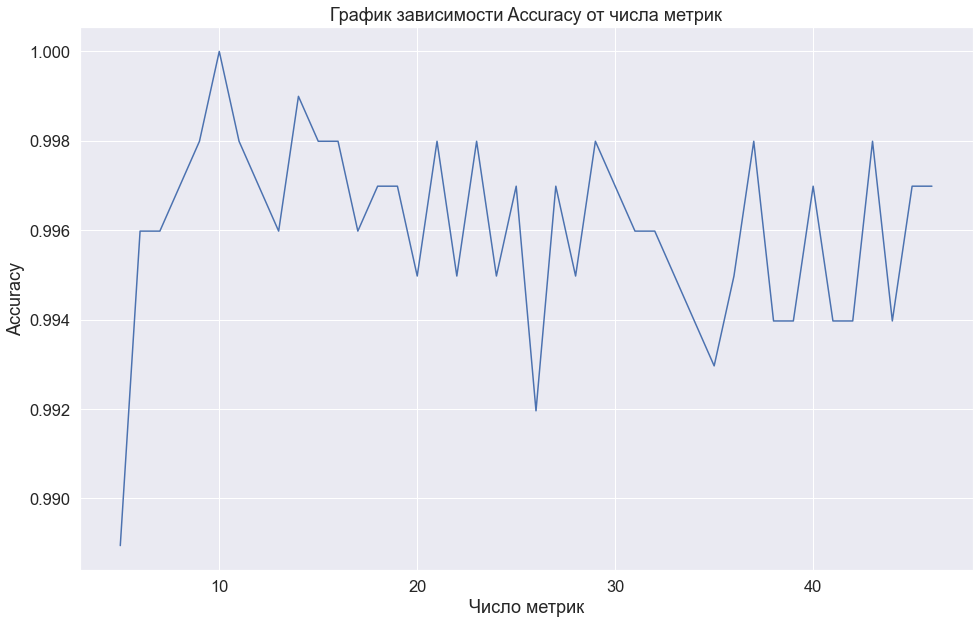

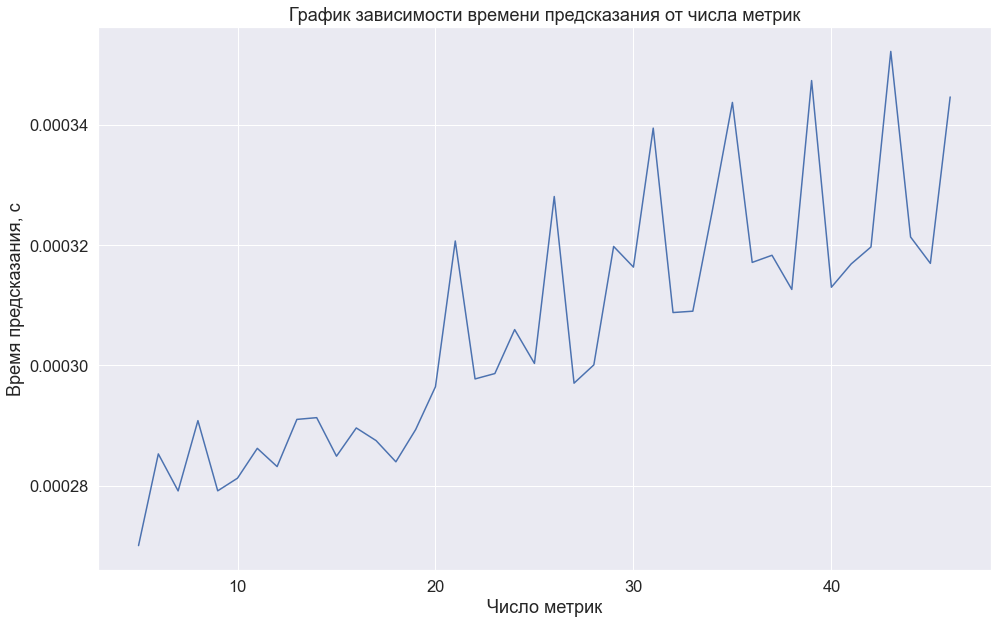

In [78]:
plot_acc_and_time(history, sorted_metrics)

### Исследование влияние размера окна
Взьмем минимальное число метрик  - 5, чтобы не было везде лучшей точности

In [3]:
sorted_metrics = ['z_mean',
 'y_mean',
 'z_energy',
 'x_mean_pos1',
 'y_energy',
 'sma',
 'z_min',
 'y_min_pos1',
 'x_min_pos1',
 'x_energy',
 'y_mean_pos1',
 'y_max_pos1',
 'x_mean',
 'mass',
 'y_iqr_pos1',
 'y_min',
 'xz_corr_pos1',
 'sma_pos1',
 'y_max',
 'z_max',
 'x_min',
 'y_iqr',
 'z_iqr_pos1',
 'x_iqr',
 'z_max_pos1',
 'x_iqr_pos1',
 'xy_corr_pos1',
 'x_max_pos1',
 'xz_corr',
 'z_std_pos1',
 'z_min_pos1',
 'x_energy_pos1',
 'x_std_pos1',
 'yz_corr_pos1',
 'y_std',
 'z_std',
 'x_std',
 'xy_corr',
 'x_max',
 'z_iqr',
 'z_energy_pos1',
 'z_mean_pos1',
 'y_std_pos1',
 'height',
 'yz_corr',
 'y_energy_pos1']

In [11]:
window_sizes = [50, 100, 150, 200]

In [12]:
params_grid = {
        'n_estimators': [200, 300, 500],
        'max_depth' : np.arange(3, 6),
        'learning_rate': np.linspace(0.5, 0.6, 8)
    }

In [13]:
history = defaultdict(list)

In [14]:
for window_size in tqdm(window_sizes):
    load_path = '../datasets/added_pos1_metrics_windowed_' + str(window_size) + '.csv'
    data = pd.read_csv(load_path, index_col=[0, 1])
    data = data.reset_index(drop=True)
    data = data.drop(['position', 'age'], axis=1)

    y = data['is_valid']
    X = data.drop('is_valid', axis=1)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, train_size=0.7, random_state=1234
    )

    
    metrics = sorted_metrics[:5]
    
    model = getBestModelCB(X_train[metrics], X_test[metrics], y_train, y_test,
                        params_grid=params_grid)
    
    X_test_cut = X_test[metrics].to_numpy()
    
    time_predict = min(timeit.Timer('model.predict(X_test_cut[0])', globals=globals()).repeat(repeat=100, number=1))    
    y_pred = model.predict(X_test_cut)
    
    history['time_predict'].append(time_predict)
    accuracy = accuracy_score(y_test, y_pred)
    history['accuracy'].append(accuracy)

  0%|          | 0/4 [00:00<?, ?it/s]

0:	learn: 0.4155836	test: 0.4203333	best: 0.4203333 (0)	total: 13.6ms	remaining: 6.81s
100:	learn: 0.0213291	test: 0.0523563	best: 0.0523563 (100)	total: 1.49s	remaining: 5.88s
200:	learn: 0.0097124	test: 0.0482224	best: 0.0482224 (200)	total: 2.9s	remaining: 4.31s
300:	learn: 0.0086003	test: 0.0486407	best: 0.0482224 (200)	total: 4.07s	remaining: 2.69s
400:	learn: 0.0075144	test: 0.0475976	best: 0.0475976 (400)	total: 5.26s	remaining: 1.3s
499:	learn: 0.0066019	test: 0.0475707	best: 0.0475707 (499)	total: 6.47s	remaining: 0us

bestTest = 0.04757069096
bestIteration = 499



 25%|██▌       | 1/4 [06:55<20:47, 415.94s/it]

0:	learn: 0.4472793	test: 0.4526040	best: 0.4526040 (0)	total: 9.2ms	remaining: 4.59s
100:	learn: 0.0238079	test: 0.0452657	best: 0.0452657 (100)	total: 948ms	remaining: 3.75s
200:	learn: 0.0095909	test: 0.0352422	best: 0.0352422 (200)	total: 1.91s	remaining: 2.84s
300:	learn: 0.0085854	test: 0.0350323	best: 0.0350323 (300)	total: 2.77s	remaining: 1.83s
400:	learn: 0.0068694	test: 0.0325825	best: 0.0325825 (400)	total: 3.38s	remaining: 835ms
499:	learn: 0.0066815	test: 0.0325940	best: 0.0325825 (400)	total: 3.94s	remaining: 0us

bestTest = 0.03258253659
bestIteration = 400

Shrink model to first 401 iterations.


 50%|█████     | 2/4 [09:52<09:10, 275.14s/it]

0:	learn: 0.4562857	test: 0.4461335	best: 0.4461335 (0)	total: 5.44ms	remaining: 2.71s
100:	learn: 0.0119925	test: 0.0438563	best: 0.0438563 (100)	total: 373ms	remaining: 1.48s
200:	learn: 0.0076693	test: 0.0402676	best: 0.0402676 (200)	total: 712ms	remaining: 1.06s
300:	learn: 0.0075758	test: 0.0401937	best: 0.0401937 (300)	total: 1.03s	remaining: 679ms
400:	learn: 0.0073494	test: 0.0401659	best: 0.0401659 (400)	total: 1.34s	remaining: 331ms
499:	learn: 0.0069808	test: 0.0400308	best: 0.0400308 (499)	total: 1.66s	remaining: 0us

bestTest = 0.04003078945
bestIteration = 499



 75%|███████▌  | 3/4 [12:04<03:29, 209.79s/it]

0:	learn: 0.4636826	test: 0.4836643	best: 0.4836643 (0)	total: 6.1ms	remaining: 1.21s
100:	learn: 0.0103728	test: 0.0683939	best: 0.0683939 (100)	total: 613ms	remaining: 601ms
199:	learn: 0.0052411	test: 0.0630161	best: 0.0630161 (199)	total: 1.22s	remaining: 0us

bestTest = 0.06301607265
bestIteration = 199



100%|██████████| 4/4 [13:40<00:00, 205.25s/it]


In [15]:
history

defaultdict(list,
            {'time_predict': [0.0005704340001102537,
              0.000584453999181278,
              0.000541990993951913,
              0.0005446889990707859],
             'accuracy': [0.9836301493074294,
              0.9893428063943162,
              0.9844617092119867,
              0.9789631855747558]})

In [ ]:
# сохранение истории
with open('history_window.json', 'w') as fp:
    json.dump(history, fp)